In [1]:
!pip install tenseal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.2 MB/s eta 0:00:00


In [2]:
from google.colab import files
import json
import numpy as np
import tenseal as ts

# Upload the JSON file (This is still done on the server)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

with open(filename, "r") as f:
    data = json.load(f)

Saving MMU (1).json to MMU (1).json


In [3]:
# First, let's inspect what users we actually have in the original data
print("Users in original data:", list(data.keys())[:10])  # Show first 10 user IDs
print("Total users in data:", len(data))

# Check if user '1' exists in the original data
if '1' not in data:
    print("WARNING: User '1' does not exist in the original data!")
    # Let's use the first available user instead
    first_user_id = list(data.keys())[0]
    print(f"Using first available user: {first_user_id}")
else:
    first_user_id = '1'

Users in original data: ['1', '2', '3', '5', '6', '7', '8', '9', '10', '11']
Total users in data: 43


In [4]:
# Secure storage for private keys
user_private_keys = {}

# Database to store encrypted data
encrypted_database = {}

print("\n=== BUILDING ENCRYPTED DATABASE WITH NORMALIZATION ===")


def normalize_vector(v):
    import numpy as np
    v = np.array(v, dtype=np.float64)
    norm = np.linalg.norm(v)
    return (v / norm).tolist() if norm > 0 else v.tolist()

for user_id, user_data in data.items():
    print(f"Processing User {user_id}...")

    try:
        # Generate encryption context
        user_context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=8192,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
        )
        user_context.generate_galois_keys()
        user_context.global_scale = 2 ** 40

        # Store private key
        user_private_key = user_context.serialize(save_secret_key=True)
        user_private_keys[user_id] = user_private_key
        print(f"  ✓ Private key stored for user {user_id}")

        # Create public context
        user_public_context = user_context.copy()
        user_public_context.make_context_public()

        # ============================================
        # NORMALIZE EACH VECTOR BEFORE ENCRYPTION
        # ============================================
        user_encrypted_features = []
        for vec in user_data["features"]:
            # THIS IS THE KEY LINE - NORMALIZE FIRST!
            normalized_vec = normalize_vector(vec)

            # Encrypt the normalized vector
            enc_vec = ts.ckks_vector(user_public_context, normalized_vec)
            user_encrypted_features.append(enc_vec.serialize())

        # Store in database
        user_public_key = user_public_context.serialize()
        encrypted_database[user_id] = {
            'public_key': user_public_key,
            'encrypted_features': user_encrypted_features
        }

        print(f"  ✓ Added User {user_id} to database with {len(user_encrypted_features)} NORMALIZED features")

    except Exception as e:
        print(f"  ✗ Error with User {user_id}: {e}")
        continue

print(f"✓ Enrollment completed. Stored private keys for {len(user_private_keys)} users")


=== BUILDING ENCRYPTED DATABASE WITH NORMALIZATION ===
Processing User 1...
  ✓ Private key stored for user 1
  ✓ Added User 1 to database with 10 NORMALIZED features
Processing User 2...
  ✓ Private key stored for user 2
  ✓ Added User 2 to database with 10 NORMALIZED features
Processing User 3...
  ✓ Private key stored for user 3
  ✓ Added User 3 to database with 10 NORMALIZED features
Processing User 5...
  ✓ Private key stored for user 5
  ✓ Added User 5 to database with 10 NORMALIZED features
Processing User 6...
  ✓ Private key stored for user 6
  ✓ Added User 6 to database with 10 NORMALIZED features
Processing User 7...
  ✓ Private key stored for user 7
  ✓ Added User 7 to database with 10 NORMALIZED features
Processing User 8...
  ✓ Private key stored for user 8
  ✓ Added User 8 to database with 10 NORMALIZED features
Processing User 9...
  ✓ Private key stored for user 9
  ✓ Added User 9 to database with 10 NORMALIZED features
Processing User 10...
  ✓ Private key stored for

In [5]:
# Verify the database was built correctly
print("\n=== DATABASE VERIFICATION ===")
print("Users in encrypted database:", sorted(list(encrypted_database.keys()))[:10])
print(f"Total users in encrypted database: {len(encrypted_database)}")

# Check if specific users exist
for user_id in ['1', '2', '3', '44']:
    if user_id in encrypted_database:
        print(f"✓ User {user_id} found in database")
    else:
        print(f"✗ User {user_id} NOT found in database")


=== DATABASE VERIFICATION ===
Users in encrypted database: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18']
Total users in encrypted database: 43
✓ User 1 found in database
✓ User 2 found in database
✓ User 3 found in database
✓ User 44 found in database


In [6]:
def cosine_similarity_encrypted_public(v1, v2):
    """
    Compute cosine similarity using only homomorphic operations.
    Returns encrypted similarity score.
    """
    # Encrypted dot product
    dot_product = v1.dot(v2)

    # Encrypted squared norms
    norm_sq_v1 = v1.dot(v1)
    norm_sq_v2 = v2.dot(v2)

    # We can't decrypt the norms on server, so we return the encrypted components
    # Client will decrypt and compute final similarity
    return dot_product, norm_sq_v1, norm_sq_v2

In [7]:

class AuthenticationXAI:
    def __init__(self, threshold=0.70):
        self.threshold = threshold

    def explain_authentication(self, query_user_id, template_scores, feature_similarities_all, threshold=0.70):
        """
        Generate human-readable explanations for authentication decisions.
        """

        print(f"\n{'='*60}")
        print("EXPLAINABLE AI (XAI) - AUTHENTICATION DECISION ANALYSIS")
        print(f"{'='*60}")

        if not template_scores:
            print("ERROR: No template scores available for analysis")
            return

        best_template_idx = np.argmax(template_scores)
        best_score = template_scores[best_template_idx]

        is_authenticated = best_score >= threshold

        print(f"\n🔍 USER ANALYSIS: {query_user_id}")
        print(f"📊 BEST MATCH SCORE: {best_score:.4f}")
        print(f"🎯 THRESHOLD: {threshold}")
        print(f"📋 AUTHENTICATION: {'SUCCESSFUL ✅' if is_authenticated else 'FAILED ❌'}")
        print(f"📈 MARGIN: {best_score - threshold:+.4f}")

        # Overall score analysis
        print(f"\n📊 OVERALL SCORE ANALYSIS:")
        print(f"   • Templates analyzed: {len(template_scores)}")
        print(f"   • Templates above threshold: {sum(1 for s in template_scores if s >= threshold)}")
        print(f"   • Average template score: {np.mean(template_scores):.4f}")
        print(f"   • Score variance: {np.var(template_scores):.4f}")

        if len(template_scores) > 1:
            sorted_scores = sorted(template_scores, reverse=True)
            if sorted_scores[0] - sorted_scores[1] > 0.1:
                print(f"   • Best template significantly outperforms others")
            elif sorted_scores[0] - sorted_scores[1] < 0.05:
                print(f"   • Multiple templates show similar performance")

        # Feature-level analysis if available
        if feature_similarities_all and len(feature_similarities_all) > best_template_idx:
            feature_scores = feature_similarities_all[best_template_idx]
            if feature_scores:
                print(f"\n📈 FEATURE-LEVEL ANALYSIS (Best Template {best_template_idx + 1}):")

                for i, score in enumerate(feature_scores):
                    status = "✓" if score >= 0.7 else ("∼" if score >= 0.5 else "✗")
                    contribution = "HIGH" if score >= 0.8 else ("MEDIUM" if score >= 0.6 else "LOW")
                    print(f"   Feature {i+1}: {status} {score:.4f} ({contribution})")

                # Identify strongest and weakest features
                if len(feature_scores) > 1:
                    best_feature = np.argmax(feature_scores)
                    worst_feature = np.argmin(feature_scores)

                    if feature_scores[best_feature] >= 0.8:
                        print(f"   → Feature {best_feature + 1} was strongest contributor")
                    if feature_scores[worst_feature] < 0.5:
                        print(f"   → Feature {worst_feature + 1} was weakest contributor")

        # Decision explanation
        print(f"\n🎯 DECISION EXPLANATION:")
        if is_authenticated:
            print(f"   1. Template {best_template_idx + 1} achieved {best_score*100:.1f}% similarity")
            print(f"   2. Exceeded threshold by {(best_score - threshold)*100:.1f}%")

            if best_score >= 0.85:
                print(f"   3. Very strong biometric match detected")
            elif best_score >= 0.75:
                print(f"   3. Strong biometric match confirmed")
            else:
                print(f"   3. Adequate biometric match established")

            # Check consistency
            high_scoring_templates = sum(1 for s in template_scores if s >= threshold)
            if high_scoring_templates >= 3:
                print(f"   4. Multiple templates ({high_scoring_templates}) support authentication")

        else:
            print(f"   1. Best template only achieved {best_score*100:.1f}% similarity")
            print(f"   2. Fell short of threshold by {(threshold - best_score)*100:.1f}%")

            if best_score >= 0.65:
                print(f"   3. Close match but below security threshold")
                print(f"   4. Consider using more features or adjusting threshold slightly")
            elif best_score >= 0.5:
                print(f"   3. Moderate match - possible biometric variation")
                print(f"   4. Recommend re-capturing biometric data")
            else:
                print(f"   3. Poor match - likely incorrect user or data issue")
                print(f"   4. Consider re-enrollment")

        # Confidence assessment
        print(f"\n💡 CONFIDENCE ASSESSMENT:")
        if best_score >= 0.85:
            confidence = "VERY HIGH"
        elif best_score >= 0.75:
            confidence = "HIGH"
        elif best_score >= threshold:
            confidence = "MODERATE"
        elif best_score >= 0.6:
            confidence = "LOW"
        else:
            confidence = "VERY LOW"

        print(f"   • Decision Confidence: {confidence}")

        if is_authenticated:
            if confidence in ["VERY HIGH", "HIGH"]:
                print(f"   • Recommended Action: Grant full access")
            else:
                print(f"   • Recommended Action: Grant limited access + additional verification")
        else:
            if best_score >= 0.65:
                print(f"   • Recommended Action: Request re-authentication with more features")
            else:
                print(f"   • Recommended Action: Deny access + security alert")

        print(f"\n{'='*60}")
        print("XAI ANALYSIS COMPLETE")
        print(f"{'='*60}")

In [9]:
query_user_id = '24'

print(f"\n=== AUTHENTICATING USER {query_user_id} ===")

if query_user_id not in encrypted_database:
    print(f"ERROR: User {query_user_id} not found!")
    exit()

# ============================================
# FIX 1: ADD NORMALIZATION FUNCTION
# ============================================
def normalize_vector(v):
    """Normalize vector to unit length for cosine similarity"""
    import numpy as np
    v = np.array(v, dtype=np.float64)
    norm = np.linalg.norm(v)
    if norm > 0:
        return v / norm
    return v

# ============================================
# FIX 2: GET QUERY FEATURES AND NORMALIZE THEM
# ============================================

# Get query vectors from dataset (THESE ARE RAW, NEED NORMALIZATION!)
query_features = [
    [-403.691303565368, -198.4814013615891, 77.55259193171345, -37.471253039648545, 35.11382073237985],
    [-370.80670640425615, -215.53142283509877, 69.66043410086661, -22.568455230436133, -20.088267124066007]
]

print(f"✓ Selected {len(query_features)} query features: Feature 5 and Feature 6")

normalized_queries = []
for i, feat in enumerate(query_features):
    normalized = normalize_vector(feat)
    normalized_queries.append(normalized)

    # Print norms for debugging
    original_norm = np.linalg.norm(feat)
    normalized_norm = np.linalg.norm(normalized)
    print(f"  Feature {i+1}: original norm = {original_norm:.2f}, normalized norm = {normalized_norm:.2f}")

print("✓ All query features normalized to unit length")

# ============================================
# STEP 1: Retrieve the target user's public context
# ============================================
target_data = encrypted_database[query_user_id]
target_public_context = ts.context_from(target_data['public_key'])

# ============================================
# STEP 2: Encrypt NORMALIZED query vectors
# ============================================
enc_queries = []
for i, query_vec in enumerate(normalized_queries):
    # Convert numpy array to list for encryption
    enc_query = ts.ckks_vector(target_public_context, query_vec.tolist())
    enc_queries.append(enc_query)
print(f"✓ {len(enc_queries)} normalized query features encrypted with correct public key")

# ============================================
# STEP 3: Retrieve private context
# ============================================
try:
    if query_user_id not in user_private_keys:
        print(f"✗ No private key found for user {query_user_id}")
        print("  Make sure enrollment was run with proper key storage")
        exit()

    user_private_context = ts.context_from(user_private_keys[query_user_id])
    print("✓ Retrieved private context with secret key")

except Exception as e:
    print(f"✗ Failed to retrieve private context: {e}")
    exit()


=== AUTHENTICATING USER 24 ===
✓ Selected 2 query features: Feature 5 and Feature 6
  Feature 1: original norm = 459.36, normalized norm = 1.00
  Feature 2: original norm = 435.56, normalized norm = 1.00
✓ All query features normalized to unit length
✓ 2 normalized query features encrypted with correct public key
✓ Retrieved private context with secret key


In [10]:
print(f"\n=== SERVER-SIDE COMPARISON (Processing {len(enc_queries)} features) ===")

target_data = encrypted_database[query_user_id]
target_public_context = ts.context_from(target_data['public_key'])
target_enc_features = target_data['encrypted_features']

# Store all encrypted results for each feature and each template
encrypted_results_all = []  # This will be a 2D list: [template_index][feature_index]

for template_idx, enc_feat_serialized in enumerate(target_enc_features):
    try:
        # Deserialize encrypted template vector with public context
        enc_feat = ts.ckks_vector_from(target_public_context, enc_feat_serialized)

        template_results = []

        # Compare each query feature with this template
        for feature_idx, enc_query in enumerate(enc_queries):
            # Compute encrypted similarity (dot product, norm squared) for each feature
            dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

            # Store encrypted results for this feature
            template_results.append({
                'dot_product': dot_product.serialize(),
                'norm_sq_v1': norm_sq_v1.serialize(),
                'norm_sq_v2': norm_sq_v2.serialize()
            })

        # Add all feature results for this template
        encrypted_results_all.append(template_results)
        print(f"  ✓ Template {template_idx + 1}: All {len(enc_queries)} feature comparisons completed")

    except Exception as e:
        print(f"  ✗ Template {template_idx + 1}: Error during comparison: {e}")
        encrypted_results_all.append([])  # Empty list for failed template



decrypted_average_scores = []
successful_decryptions = 0

for template_idx, template_results in enumerate(encrypted_results_all):
    if not template_results:  # Skip failed comparisons
        print(f"  ✗ Template {template_idx + 1}: Skipping - no comparison results")
        decrypted_average_scores.append(0.0)
        continue

    try:
        feature_similarities = []

        # Decrypt and compute similarity for each feature
        for feature_idx, result in enumerate(template_results):
            # Deserialize encrypted vectors with private context (secret key)
            dot_product_enc = ts.ckks_vector_from(user_private_context, result['dot_product'])
            norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v1'])
            norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v2'])

            # Decrypt the components
            dot_product = dot_product_enc.decrypt()[0]
            norm_sq_v1_val = norm_sq_v1_enc.decrypt()[0]
            norm_sq_v2_val = norm_sq_v2_enc.decrypt()[0]

            # Calculate cosine similarity safely
            norm_sq_v1_val = max(0, norm_sq_v1_val)
            norm_sq_v2_val = max(0, norm_sq_v2_val)
            norm_v1 = np.sqrt(norm_sq_v1_val) if norm_sq_v1_val > 0 else 0
            norm_v2 = np.sqrt(norm_sq_v2_val) if norm_sq_v2_val > 0 else 0

            if norm_v1 == 0 or norm_v2 == 0:
                similarity = 0.0
            else:
                similarity = dot_product / (norm_v1 * norm_v2)

            similarity = max(-1.0, min(1.0, similarity))
            feature_similarities.append(similarity)

        # Calculate average similarity across all features for this template
        average_similarity = sum(feature_similarities) / len(feature_similarities)
        decrypted_average_scores.append(average_similarity)
        successful_decryptions += 1

    except Exception as e:
        print(f"  ✗ Template {template_idx + 1}: Error decrypting: {e}")
        decrypted_average_scores.append(0.0)


=== SERVER-SIDE COMPARISON (Processing 2 features) ===
  ✓ Template 1: All 2 feature comparisons completed
  ✓ Template 2: All 2 feature comparisons completed
  ✓ Template 3: All 2 feature comparisons completed
  ✓ Template 4: All 2 feature comparisons completed
  ✓ Template 5: All 2 feature comparisons completed
  ✓ Template 6: All 2 feature comparisons completed
  ✓ Template 7: All 2 feature comparisons completed
  ✓ Template 8: All 2 feature comparisons completed
  ✓ Template 9: All 2 feature comparisons completed
  ✓ Template 10: All 2 feature comparisons completed


In [11]:
# Cell 10: Client-side Decryption with XAI Data Collection
print(f"\n=== CLIENT-SIDE DECRYPTION AND AVERAGE COMPUTATION ===")

decrypted_average_scores = []
feature_similarities_all = []  # NEW: Store feature-level scores for XAI
successful_decryptions = 0

# NEW: Track templates that meet the feature threshold
templates_meeting_threshold = 0
threshold_value = 0.999  # Define your threshold
templates_with_high_feature = []  # Store indices of templates meeting criteria

for template_idx, template_results in enumerate(encrypted_results_all):
    if not template_results:  # Skip failed comparisons
        print(f"  ✗ Template {template_idx + 1}: Skipping - no comparison results")
        decrypted_average_scores.append(0.0)
        feature_similarities_all.append([])  # Empty list for this template
        continue

    try:
        feature_similarities = []

        # Decrypt and compute similarity for each feature
        for feature_idx, result in enumerate(template_results):
            # Deserialize encrypted vectors with private context
            dot_product_enc = ts.ckks_vector_from(user_private_context, result['dot_product'])
            norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v1'])
            norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v2'])

            # Decrypt the components
            dot_product = dot_product_enc.decrypt()[0]
            norm_sq_v1_val = norm_sq_v1_enc.decrypt()[0]
            norm_sq_v2_val = norm_sq_v2_enc.decrypt()[0]

            # Calculate cosine similarity safely
            norm_sq_v1_val = max(0, norm_sq_v1_val)
            norm_sq_v2_val = max(0, norm_sq_v2_val)
            norm_v1 = np.sqrt(norm_sq_v1_val) if norm_sq_v1_val > 0 else 0
            norm_v2 = np.sqrt(norm_sq_v2_val) if norm_sq_v2_val > 0 else 0

            if norm_v1 == 0 or norm_v2 == 0:
                similarity = 0.0
            else:
                similarity = dot_product / (norm_v1 * norm_v2)

            similarity = max(-1.0, min(1.0, similarity))
            feature_similarities.append(similarity)

        # Store feature-level scores for XAI
        feature_similarities_all.append(feature_similarities)

        # Calculate average similarity
        average_similarity = sum(feature_similarities) / len(feature_similarities)
        decrypted_average_scores.append(average_similarity)
        successful_decryptions += 1

        # NEW: Check if at least one feature meets the threshold
        high_features = [sim for sim in feature_similarities if sim >= threshold_value]
        has_high_feature = len(high_features) > 0

        if has_high_feature:
            templates_meeting_threshold += 1
            templates_with_high_feature.append({
                'template': template_idx + 1,
                'high_features': high_features,
                'average': average_similarity
            })

        # Display results with threshold indicator
        print(f"  ✓ Template {template_idx + 1}: {'✅ HIGH FEATURE DETECTED' if has_high_feature else '❌ No high feature'}")
        for i, sim in enumerate(feature_similarities):
            indicator = "⭐" if sim >= threshold_value else "  "
            print(f"      Feature {i + 1} similarity: {sim:.4f} {indicator}")
        print(f"      Average similarity: {average_similarity:.4f}")

    except Exception as e:
        print(f"  ✗ Template {template_idx + 1}: Error decrypting: {e}")
        decrypted_average_scores.append(0.0)
        feature_similarities_all.append([])

# NEW: Apply the rule check after processing all templates
print(f"\n=== RULE VALIDATION ===")
print(f"Templates with at least one feature ≥ {threshold_value}: {templates_meeting_threshold}")

if templates_meeting_threshold >= 2:
    print(f"✅ RULE PASSED: At least 2 templates have one feature ≥ {threshold_value}")
    print(f"   Templates meeting criteria: {[t['template'] for t in templates_with_high_feature]}")

    # Optional: Show detailed information about high features
    for template_info in templates_with_high_feature:
        print(f"   Template {template_info['template']}: High features = {[f'{sim:.4f}' for sim in template_info['high_features']]}")
else:
    print(f"❌ RULE FAILED: Only {templates_meeting_threshold} template(s) have one feature ≥ {threshold_value}")
    print(f"   Required: At least 2 templates")


=== CLIENT-SIDE DECRYPTION AND AVERAGE COMPUTATION ===
  ✓ Template 1: ❌ No high feature
      Feature 1 similarity: 0.9854   
      Feature 2 similarity: 0.9692   
      Average similarity: 0.9773
  ✓ Template 2: ❌ No high feature
      Feature 1 similarity: 0.9610   
      Feature 2 similarity: 0.9824   
      Average similarity: 0.9717
  ✓ Template 3: ✅ HIGH FEATURE DETECTED
      Feature 1 similarity: 1.0000 ⭐
      Feature 2 similarity: 0.9897   
      Average similarity: 0.9948
  ✓ Template 4: ✅ HIGH FEATURE DETECTED
      Feature 1 similarity: 0.9897   
      Feature 2 similarity: 1.0000 ⭐
      Average similarity: 0.9948
  ✓ Template 5: ❌ No high feature
      Feature 1 similarity: 0.9073   
      Feature 2 similarity: 0.8600   
      Average similarity: 0.8836
  ✓ Template 6: ❌ No high feature
      Feature 1 similarity: 0.9803   
      Feature 2 similarity: 0.9926   
      Average similarity: 0.9865
  ✓ Template 7: ❌ No high feature
      Feature 1 similarity: 0.9413   
    

In [12]:
# Cell 12: XAI Analysis
print(f"\n{'='*60}")
print("XAI DECISION EXPLANATION")
print(f"{'='*60}")

# Get metrics from previous analysis
threshold_value = 0.99  # Feature threshold
min_templates_required = 2  # Minimum templates with high features
average_threshold = 0.5  # Average similarity threshold (optional)

# Count templates with high features
templates_with_high_features = []
high_feature_counts = []

for template_idx, features in enumerate(feature_similarities_all):
    if features:  # Check if template has valid features
        high_features = [sim for sim in features if sim >= threshold_value]
        if high_features:
            templates_with_high_features.append({
                'template': template_idx + 1,
                'high_features': high_features,
                'count': len(high_features),
                'max_feature': max(features),
                'average': decrypted_average_scores[template_idx] if template_idx < len(decrypted_average_scores) else 0
            })
            high_feature_counts.append(len(high_features))

num_templates_with_high_features = len(templates_with_high_features)
auth_success = num_templates_with_high_features >= min_templates_required

print(f"\n🔍 QUICK ANALYSIS:")
print(f"   User: {query_user_id}")
print(f"   Templates with high-confidence features (≥{threshold_value}): {num_templates_with_high_features}/{len(feature_similarities_all)}")
print(f"   Required templates with high features: {min_templates_required}")
print(f"   Result: {'AUTHENTICATED ✅' if auth_success else 'REJECTED ❌'}")

if auth_success:
    print(f"\n✅ REASONS FOR AUTHENTICATION:")
    print(f"   1. Found {num_templates_with_high_features} templates with at least one high-confidence feature")
    print(f"   2. Meets requirement of ≥{min_templates_required} templates")

    # Show which templates and features
    print(f"   3. Templates with high-confidence features:")
    for template_info in templates_with_high_features:
        high_feature_str = ', '.join([f"F{i+1}={sim:.3f}" for i, sim in enumerate(template_info['high_features'])])
        print(f"      - Template {template_info['template']}: {template_info['count']} high feature(s) [{high_feature_str}]")

    # Check consistency
    if num_templates_with_high_features >= 3:
        print(f"   4. High consistency: {num_templates_with_high_features} templates confirm identity")

    # Check if multiple features in same template
    templates_with_multiple = [t for t in templates_with_high_features if t['count'] > 1]
    if templates_with_multiple:
        print(f"   5. Strong verification: {len(templates_with_multiple)} template(s) have multiple high-confidence features")

    # Check average scores
    high_avg_templates = [t for t in templates_with_high_features if t['average'] >= average_threshold]
    if high_avg_templates:
        print(f"   6. {len(high_avg_templates)} template(s) also have good average similarity (≥{average_threshold})")

    # Confidence level based on number of high features
    if num_templates_with_high_features >= 3 or max(high_feature_counts) >= 2:
        print(f"\n💡 CONFIDENCE: HIGH")
    else:
        print(f"\n💡 CONFIDENCE: MODERATE")

else:
    print(f"\n❌ REASONS FOR REJECTION:")
    print(f"   1. Insufficient templates with high-confidence features: {num_templates_with_high_features}/{min_templates_required} required")

    if num_templates_with_high_features == 1:
        print(f"   2. Only 1 template has a high-confidence feature (need at least {min_templates_required})")
        # Show the single template that almost passed
        template_info = templates_with_high_features[0]
        print(f"      - Template {template_info['template']} has {template_info['count']} high feature(s): "
              f"{[f'{sim:.4f}' for sim in template_info['high_features']]}")

    elif num_templates_with_high_features == 0:
        print(f"   2. No templates have features reaching {threshold_value}")

        # Check for near misses (features close to threshold)
        near_misses = []
        for template_idx, features in enumerate(feature_similarities_all):
            if features:
                near_high = [sim for sim in features if 0.95 <= sim < threshold_value]
                if near_high:
                    near_misses.append({
                        'template': template_idx + 1,
                        'near_features': near_high,
                        'best_feature': max(features)
                    })

        if near_misses:
            print(f"   3. Near misses detected:")
            for nm in near_misses:
                print(f"      - Template {nm['template']}: best feature = {nm['best_feature']:.4f} "
                      f"(needs {threshold_value - nm['best_feature']:.4f} more)")
            print(f"   4. Consider: Lowering threshold or improving feature quality")
        else:
            print(f"   3. All features are well below threshold")
            print(f"   4. Consider: User re-enrollment or security review")

    # Check average scores for context
    good_avg_templates = [i+1 for i, avg in enumerate(decrypted_average_scores)
                         if avg >= average_threshold and i < len(decrypted_average_scores)]
    if good_avg_templates:
        print(f"\n   Note: {len(good_avg_templates)} template(s) have good average similarity (≥{average_threshold})")
        print(f"   but lack individual high-confidence features")

    print(f"\n⚠️  RECOMMENDATION: " +
          ('Consider adjusting feature extraction pipeline' if num_templates_with_high_features == 0
           else 'Consider threshold adjustment or additional verification methods'))

# Run detailed XAI analysis with updated logic
print(f"\n{'='*60}")
print("DETAILED XAI ANALYSIS")
print(f"{'='*60}")

# Create an enhanced XAI analyzer class that incorporates your logic
class EnhancedAuthenticationXAI:
    def __init__(self, feature_threshold=0.99, min_templates=2, avg_threshold=0.5):
        self.feature_threshold = feature_threshold
        self.min_templates = min_templates
        self.avg_threshold = avg_threshold

    def analyze_template_features(self, feature_similarities_all, decrypted_average_scores):
        """Analyze which templates meet the feature threshold"""
        analysis = {
            'templates_meeting_feature_rule': [],
            'templates_with_high_avg': [],
            'feature_statistics': []
        }

        for template_idx, features in enumerate(feature_similarities_all):
            if features:
                # Feature analysis
                high_features = [sim for sim in features if sim >= self.feature_threshold]
                max_feature = max(features) if features else 0
                min_feature = min(features) if features else 0

                template_data = {
                    'template': template_idx + 1,
                    'has_high_feature': len(high_features) > 0,
                    'high_feature_count': len(high_features),
                    'high_features': high_features,
                    'max_feature': max_feature,
                    'min_feature': min_feature,
                    'feature_range': max_feature - min_feature,
                    'average': decrypted_average_scores[template_idx] if template_idx < len(decrypted_average_scores) else 0
                }

                analysis['feature_statistics'].append(template_data)

                if template_data['has_high_feature']:
                    analysis['templates_meeting_feature_rule'].append(template_data)

                if template_data['average'] >= self.avg_threshold:
                    analysis['templates_with_high_avg'].append(template_data)

        return analysis

    def explain_authentication(self, query_user_id, template_scores, feature_similarities_all):
        """Provide detailed XAI explanation"""
        analysis = self.analyze_template_features(feature_similarities_all, template_scores)

        print(f"\n📊 AUTHENTICATION ANALYSIS FOR USER: {query_user_id}")
        print(f"{'-'*50}")

        # Summary statistics
        print(f"\n📈 SUMMARY STATISTICS:")
        print(f"   Total templates processed: {len(feature_similarities_all)}")
        print(f"   Templates with high features (≥{self.feature_threshold}): {len(analysis['templates_meeting_feature_rule'])}")
        print(f"   Templates with good average (≥{self.avg_threshold}): {len(analysis['templates_with_high_avg'])}")

        # Feature distribution
        print(f"\n🔬 FEATURE-LEVEL ANALYSIS:")
        for template_data in analysis['feature_statistics']:
            status = "✅" if template_data['has_high_feature'] else "❌"
            print(f"\n   {status} Template {template_data['template']}:")
            print(f"      Average similarity: {template_data['average']:.4f}")
            print(f"      Feature range: [{template_data['min_feature']:.4f} - {template_data['max_feature']:.4f}]")

            if template_data['has_high_feature']:
                print(f"      High-confidence features: {template_data['high_feature_count']}")
                for i, sim in enumerate(template_data['high_features']):
                    print(f"         Feature {i+1}: {sim:.4f} ⭐")
            else:
                # Show closest feature to threshold
                if template_data['max_feature'] > 0:
                    gap = self.feature_threshold - template_data['max_feature']
                    print(f"      Closest to threshold: {template_data['max_feature']:.4f} (needs {gap:.4f} more)")

        # Decision explanation
        print(f"\n{'='*40}")
        print("AUTHENTICATION DECISION EXPLANATION")
        print(f"{'='*40}")

        if len(analysis['templates_meeting_feature_rule']) >= self.min_templates:
            print(f"\n✅ DECISION: AUTHENTICATE")
            print(f"\n   Primary reasons:")
            print(f"   1. {len(analysis['templates_meeting_feature_rule'])} templates have features ≥{self.feature_threshold}")
            print(f"   2. Meets minimum requirement of {self.min_templates} templates")

            # Additional positive indicators
            if len(analysis['templates_with_high_avg']) > len(analysis['templates_meeting_feature_rule']):
                print(f"   3. Additional {len(analysis['templates_with_high_avg']) - len(analysis['templates_meeting_feature_rule'])} "
                      f"templates have good average similarity")
        else:
            print(f"\n❌ DECISION: REJECT")
            print(f"\n   Primary reasons:")
            print(f"   1. Only {len(analysis['templates_meeting_feature_rule'])} of {self.min_templates} required "
                  f"templates have features ≥{self.feature_threshold}")

            if analysis['templates_with_high_avg']:
                print(f"   2. However, {len(analysis['templates_with_high_avg'])} templates have good average similarity")
                print(f"   3. Consider adjusting feature threshold if this is a false rejection pattern")

# Use the enhanced XAI analyzer
xai_analyzer = EnhancedAuthenticationXAI(
    feature_threshold=0.999,
    min_templates=2,
    avg_threshold=0.5
)
xai_analyzer.explain_authentication(
    query_user_id=query_user_id,
    template_scores=decrypted_average_scores,
    feature_similarities_all=feature_similarities_all
)


XAI DECISION EXPLANATION

🔍 QUICK ANALYSIS:
   User: 24
   Templates with high-confidence features (≥0.99): 4/10
   Required templates with high features: 2
   Result: AUTHENTICATED ✅

✅ REASONS FOR AUTHENTICATION:
   1. Found 4 templates with at least one high-confidence feature
   2. Meets requirement of ≥2 templates
   3. Templates with high-confidence features:
      - Template 3: 1 high feature(s) [F1=1.000]
      - Template 4: 1 high feature(s) [F1=1.000]
      - Template 6: 1 high feature(s) [F1=0.993]
      - Template 8: 1 high feature(s) [F1=0.993]
   4. High consistency: 4 templates confirm identity
   6. 4 template(s) also have good average similarity (≥0.5)

💡 CONFIDENCE: HIGH

DETAILED XAI ANALYSIS

📊 AUTHENTICATION ANALYSIS FOR USER: 24
--------------------------------------------------

📈 SUMMARY STATISTICS:
   Total templates processed: 10
   Templates with high features (≥0.999): 2
   Templates with good average (≥0.5): 9

🔬 FEATURE-LEVEL ANALYSIS:

   ❌ Template 1:
 

In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import seaborn as sns

def evaluate_authentication_performance(num_users=100, threshold_range=None, num_features_list=None):
    """
    Comprehensive performance evaluation of the authentication system
    Based on rule: at least one feature ≥ 0.99 in at least 2 templates
    """

    # Define rule-based parameters
    FEATURE_THRESHOLD = 0.999  # Individual feature must exceed this
    MIN_TEMPLATES = 2  # Minimum templates with high features required

    if threshold_range is None:
        # For rule-based evaluation, we're more interested in feature threshold
        threshold_range = np.arange(0.5, 1.0, 0.05)

    if num_features_list is None:
        num_features_list = [1, 2, 3, 4, 5]

    print("=" * 70)
    print("AUTHENTICATION SYSTEM PERFORMANCE EVALUATION")
    print("=" * 70)
    print(f"Rule: At least one feature ≥ {FEATURE_THRESHOLD} in ≥ {MIN_TEMPLATES} templates")
    print("=" * 70)

    # Store all results
    all_results = {
        'genuine_scores': [],
        'impostor_scores': [],
        'metrics': {},
        'timing': {},
        'rule_based': {}  # NEW: Store rule-based authentication results
    }

    # Test different numbers of features
    for num_features in num_features_list:
        print(f"\n{'='*60}")
        print(f"EVALUATING WITH {num_features} FEATURE(S)")
        print(f"{'='*60}")

        genuine_scores = []
        impostor_scores = []
        processing_times = []

        # NEW: Rule-based tracking
        rule_results = {
            'genuine_success': 0,
            'genuine_total': 0,
            'impostor_success': 0,  # Impostor rejected = success
            'impostor_total': 0,
            'templates_with_high_features': []
        }

        # Track genuine and impostor attempts
        for query_user_id in list(data.keys())[:num_users]:
            if query_user_id not in encrypted_database:
                continue

            # Get query vectors (take first num_features available)
            query_features = []
            for i in range(min(num_features, len(data[query_user_id]["features"]))):
                query_features.append(data[query_user_id]["features"][i])

            if not query_features:
                continue

            # ========== GENUINE ATTEMPTS (Same User) ==========
            start_time = time.time()

            try:
                # Get target user's public context
                target_data = encrypted_database[query_user_id]
                target_public_context = ts.context_from(target_data['public_key'])

                # Encrypt query vectors
                enc_queries = []
                for query_vec in query_features:
                    enc_query = ts.ckks_vector(target_public_context, query_vec)
                    enc_queries.append(enc_query)

                # Get private context
                if query_user_id not in user_private_keys:
                    continue

                user_private_context = ts.context_from(user_private_keys[query_user_id])

                # Get encrypted features
                target_enc_features = target_data['encrypted_features']

                # NEW: Check rule-based authentication
                templates_with_high_features = 0
                feature_analysis = []

                for template_idx, enc_feat_serialized in enumerate(target_enc_features[:3]):  # Test with first 3 templates
                    try:
                        enc_feat = ts.ckks_vector_from(target_public_context, enc_feat_serialized)

                        feature_scores = []
                        for enc_query in enc_queries:
                            # Compute similarity
                            dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                            # Decrypt and compute similarity
                            dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                            norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                            norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                            dp = dot_product_enc.decrypt()[0]
                            n1 = max(0, norm_sq_v1_enc.decrypt()[0])
                            n2 = max(0, norm_sq_v2_enc.decrypt()[0])

                            norm_v1 = np.sqrt(n1) if n1 > 0 else 0
                            norm_v2 = np.sqrt(n2) if n2 > 0 else 0

                            if norm_v1 == 0 or norm_v2 == 0:
                                similarity = 0.0
                            else:
                                similarity = dp / (norm_v1 * norm_v2)

                            similarity = max(-1.0, min(1.0, similarity))
                            feature_scores.append(similarity)

                        # Check if any feature meets threshold
                        high_features = [s for s in feature_scores if s >= FEATURE_THRESHOLD]
                        if high_features:
                            templates_with_high_features += 1
                            feature_analysis.append({
                                'template': template_idx,
                                'high_features': high_features,
                                'max_feature': max(feature_scores)
                            })

                        # Average score for this template (for traditional comparison)
                        avg_score = sum(feature_scores) / len(feature_scores)

                    except Exception as e:
                        continue

                # Rule-based authentication decision
                rule_based_success = templates_with_high_features >= MIN_TEMPLATES

                if rule_based_success:
                    rule_results['genuine_success'] += 1
                rule_results['genuine_total'] += 1
                rule_results['templates_with_high_features'].append(templates_with_high_features)

                # Also store best average score for traditional metrics
                genuine_scores.append(max(feature_scores) if feature_scores else 0)

                # ========== IMPOSTOR ATTEMPTS (Different Users) ==========
                # Test against 5 different users
                impostor_targets = [uid for uid in list(encrypted_database.keys())[:20]
                                  if uid != query_user_id][:5]

                for imposter_id in impostor_targets:
                    try:
                        imposter_data = encrypted_database[imposter_id]
                        imposter_public_context = ts.context_from(imposter_data['public_key'])

                        # Re-encrypt queries with imposter's public key
                        enc_queries_imposter = []
                        for query_vec in query_features:
                            enc_query = ts.ckks_vector(imposter_public_context, query_vec)
                            enc_queries_imposter.append(enc_query)

                        imposter_enc_features = imposter_data['encrypted_features']

                        # Check rule-based authentication for impostor
                        impostor_templates_with_high = 0

                        for enc_feat_serialized in imposter_enc_features[:2]:  # Test 2 templates
                            try:
                                enc_feat = ts.ckks_vector_from(imposter_public_context, enc_feat_serialized)

                                feature_scores = []
                                for enc_query in enc_queries_imposter:
                                    dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                                    # Use query user's private context to decrypt
                                    dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                                    norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                                    norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                                    dp = dot_product_enc.decrypt()[0]
                                    n1 = max(0, norm_sq_v1_enc.decrypt()[0])
                                    n2 = max(0, norm_sq_v2_enc.decrypt()[0])

                                    norm_v1 = np.sqrt(n1) if n1 > 0 else 0
                                    norm_v2 = np.sqrt(n2) if n2 > 0 else 0

                                    if norm_v1 == 0 or norm_v2 == 0:
                                        similarity = 0.0
                                    else:
                                        similarity = dp / (norm_v1 * norm_v2)

                                    similarity = max(-1.0, min(1.0, similarity))
                                    feature_scores.append(similarity)

                                # Check if any feature meets threshold
                                if any(s >= FEATURE_THRESHOLD for s in feature_scores):
                                    impostor_templates_with_high += 1

                                avg_score = sum(feature_scores) / len(feature_scores)
                                impostor_scores.append(avg_score)

                            except Exception as e:
                                continue

                        # For impostor, success means REJECTED (no templates with high features)
                        rule_based_impostor_success = impostor_templates_with_high < MIN_TEMPLATES

                        if rule_based_impostor_success:
                            rule_results['impostor_success'] += 1
                        rule_results['impostor_total'] += 1

                    except Exception as e:
                        continue

                processing_time = time.time() - start_time
                processing_times.append(processing_time)

            except Exception as e:
                print(f"Error processing user {query_user_id}: {e}")
                continue

        # Calculate metrics
        if genuine_scores and impostor_scores:
            # Store scores
            all_results[f'genuine_{num_features}feat'] = genuine_scores
            all_results[f'impostor_{num_features}feat'] = impostor_scores
            all_results['timing'][f'avg_time_{num_features}feat'] = np.mean(processing_times)
            all_results['rule_based'][num_features] = rule_results

            # Calculate metrics for different thresholds (traditional approach)
            metrics = calculate_performance_metrics(genuine_scores, impostor_scores, threshold_range)

            # Add rule-based metrics
            metrics['rule_based'] = calculate_rule_based_metrics(rule_results)

            all_results['metrics'][num_features] = metrics

            # Print summary
            print_summary(num_features, genuine_scores, impostor_scores, metrics, processing_times, rule_results)

    # Generate comprehensive visualizations
    generate_visualizations(all_results, threshold_range, num_features_list)

    return all_results

def calculate_rule_based_metrics(rule_results):
    """Calculate metrics specifically for rule-based authentication"""
    metrics = {}

    if rule_results['genuine_total'] > 0:
        metrics['genuine_accept_rate'] = rule_results['genuine_success'] / rule_results['genuine_total']
        metrics['false_rejection_rate'] = 1 - metrics['genuine_accept_rate']

    if rule_results['impostor_total'] > 0:
        metrics['impostor_reject_rate'] = rule_results['impostor_success'] / rule_results['impostor_total']
        metrics['false_acceptance_rate'] = 1 - metrics['impostor_reject_rate']

    if rule_results['genuine_total'] > 0 and rule_results['impostor_total'] > 0:
        total_attempts = rule_results['genuine_total'] + rule_results['impostor_total']
        correct_decisions = rule_results['genuine_success'] + rule_results['impostor_success']
        metrics['rule_accuracy'] = correct_decisions / total_attempts

    metrics['avg_templates_with_high_features'] = np.mean(rule_results['templates_with_high_features']) if rule_results['templates_with_high_features'] else 0

    return metrics

def calculate_performance_metrics(genuine_scores, impostor_scores, threshold_range):
    """Calculate various performance metrics (unchanged from original)"""
    metrics = {
        'thresholds': threshold_range,
        'far': [],  # False Acceptance Rate
        'frr': [],  # False Rejection Rate
        'gar': [],  # Genuine Acceptance Rate
        'eer': None,  # Equal Error Rate
        'auc': None,  # Area Under ROC Curve
        'best_threshold': None
    }

    # Calculate FAR and FRR for each threshold
    for threshold in threshold_range:
        # False Acceptance: Impostor accepted
        far = sum(score >= threshold for score in impostor_scores) / len(impostor_scores) if impostor_scores else 0

        # False Rejection: Genuine rejected
        frr = sum(score < threshold for score in genuine_scores) / len(genuine_scores) if genuine_scores else 0

        metrics['far'].append(far)
        metrics['frr'].append(frr)
        metrics['gar'].append(1 - frr)  # Genuine Acceptance Rate

    # Find Equal Error Rate (EER)
    min_diff_idx = np.argmin(np.abs(np.array(metrics['far']) - np.array(metrics['frr'])))
    metrics['eer'] = (metrics['far'][min_diff_idx] + metrics['frr'][min_diff_idx]) / 2
    metrics['best_threshold'] = threshold_range[min_diff_idx]

    # Calculate AUC for ROC curve
    y_true = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    y_scores = list(genuine_scores) + list(impostor_scores)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    metrics['auc'] = auc(fpr, tpr)

    # Calculate precision-recall metrics at best threshold
    tn = sum(score < metrics['best_threshold'] for score in impostor_scores)
    fp = sum(score >= metrics['best_threshold'] for score in impostor_scores)
    fn = sum(score < metrics['best_threshold'] for score in genuine_scores)
    tp = sum(score >= metrics['best_threshold'] for score in genuine_scores)

    metrics['confusion_matrix'] = [[tn, fp], [fn, tp]]
    metrics['accuracy'] = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall']) if (metrics['precision'] + metrics['recall']) > 0 else 0

    return metrics

def print_summary(num_features, genuine_scores, impostor_scores, metrics, processing_times, rule_results=None):
    """Print summary including rule-based metrics"""
    print(f"\nSUMMARY FOR {num_features} FEATURE(S):")
    print("-" * 40)

    print(f"Number of genuine attempts: {len(genuine_scores)}")
    print(f"Number of impostor attempts: {len(impostor_scores)}")
    print(f"Average processing time: {np.mean(processing_times):.3f} seconds")
    print(f"Min processing time: {np.min(processing_times):.3f} seconds")
    print(f"Max processing time: {np.max(processing_times):.3f} seconds")

    print(f"\nScore Statistics:")
    print(f"  Genuine scores - Mean: {np.mean(genuine_scores):.4f}, Std: {np.std(genuine_scores):.4f}")
    print(f"  Impostor scores - Mean: {np.mean(impostor_scores):.4f}, Std: {np.std(impostor_scores):.4f}")

    print(f"\n{'='*40}")
    print("RULE-BASED AUTHENTICATION RESULTS")
    print(f"(Rule: ≥1 feature ≥0.99 in ≥2 templates)")
    print(f"{'='*40}")

    if rule_results:
        print(f"\nGenuine Attempts:")
        print(f"  Successfully authenticated: {rule_results['genuine_success']}/{rule_results['genuine_total']}")
        print(f"  Genuine Acceptance Rate: {rule_results['genuine_success']/rule_results['genuine_total']*100:.2f}%")
        print(f"  False Rejection Rate: {(1 - rule_results['genuine_success']/rule_results['genuine_total'])*100:.2f}%")

        print(f"\nImpostor Attempts:")
        print(f"  Successfully rejected: {rule_results['impostor_success']}/{rule_results['impostor_total']}")
        print(f"  Impostor Rejection Rate: {rule_results['impostor_success']/rule_results['impostor_total']*100:.2f}%")
        print(f"  False Acceptance Rate: {(1 - rule_results['impostor_success']/rule_results['impostor_total'])*100:.2f}%")

        if 'rule_accuracy' in metrics['rule_based']:
            print(f"\nOverall Rule Accuracy: {metrics['rule_based']['rule_accuracy']*100:.2f}%")
        print(f"Avg templates with high features: {metrics['rule_based']['avg_templates_with_high_features']:.2f}")

    print(f"\n{'='*40}")
    print("TRADITIONAL THRESHOLD-BASED METRICS")
    print(f"{'='*40}")
    print(f"  Best Threshold: {metrics['best_threshold']:.4f}")
    print(f"  Equal Error Rate (EER): {metrics['eer']:.4f}")
    print(f"  AUC: {metrics['auc']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")

    # Print confusion matrix at best threshold
    cm = metrics['confusion_matrix']
    print(f"\nConfusion Matrix at threshold {metrics['best_threshold']:.4f}:")
    print(f"          Predicted Negative  Predicted Positive")
    print(f"Actual Negative      {cm[0][0]:4d}             {cm[0][1]:4d}")
    print(f"Actual Positive      {cm[1][0]:4d}             {cm[1][1]:4d}")

def generate_visualizations(all_results, threshold_range, num_features_list):
    """Enhanced visualizations including rule-based comparison"""

    plt.figure(figsize=(24, 16))

    # 1. Score Distribution
    plt.subplot(2, 4, 1)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(num_features_list)))

    for idx, num_features in enumerate(num_features_list):
        genuine_key = f'genuine_{num_features}feat'
        impostor_key = f'impostor_{num_features}feat'

        if genuine_key in all_results and impostor_key in all_results:
            plt.hist(all_results[genuine_key], bins=30, alpha=0.5,
                    label=f'Genuine ({num_features} feat)', color=colors[idx], density=True)
            plt.hist(all_results[impostor_key], bins=30, alpha=0.5,
                    label=f'Impostor ({num_features} feat)', color=colors[idx],
                    linestyle='dashed', density=True)

    plt.axvline(x=0.99, color='red', linestyle='--', linewidth=2, label='Feature Threshold (0.99)')
    plt.xlabel('Similarity Score')
    plt.ylabel('Density')
    plt.title('Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. ROC Curves
    plt.subplot(2, 4, 2)
    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            metrics = all_results['metrics'][num_features]
            y_true = [1] * len(all_results[f'genuine_{num_features}feat']) + \
                    [0] * len(all_results[f'impostor_{num_features}feat'])
            y_scores = all_results[f'genuine_{num_features}feat'] + \
                      all_results[f'impostor_{num_features}feat']
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = metrics['auc']
            plt.plot(fpr, tpr, label=f'{num_features} feat (AUC = {roc_auc:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # 3. FAR vs FRR (DET Curve)
    plt.subplot(2, 4, 3)
    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            metrics = all_results['metrics'][num_features]
            plt.plot(threshold_range, metrics['far'], label=f'{num_features} feat FAR', linewidth=2)
            plt.plot(threshold_range, metrics['frr'], label=f'{num_features} feat FRR',
                    linewidth=2, linestyle='--')

    plt.axhline(y=0.01, color='red', linestyle=':', alpha=0.5, label='1% Error Rate')
    plt.xlabel('Threshold')
    plt.ylabel('Error Rate')
    plt.title('FAR vs FRR (DET Curve)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Rule-Based Performance Comparison (NEW)
    plt.subplot(2, 4, 4)
    rule_metrics = ['genuine_accept', 'impostor_reject', 'rule_accuracy']
    x_pos = np.arange(len(num_features_list))
    width = 0.25

    for i, metric in enumerate(rule_metrics):
        values = []
        for num_features in num_features_list:
            if num_features in all_results['rule_based']:
                rule_results = all_results['rule_based'][num_features]
                if metric == 'genuine_accept':
                    val = rule_results['genuine_success'] / rule_results['genuine_total'] if rule_results['genuine_total'] > 0 else 0
                elif metric == 'impostor_reject':
                    val = rule_results['impostor_success'] / rule_results['impostor_total'] if rule_results['impostor_total'] > 0 else 0
                else:
                    total = rule_results['genuine_total'] + rule_results['impostor_total']
                    correct = rule_results['genuine_success'] + rule_results['impostor_success']
                    val = correct / total if total > 0 else 0
                values.append(val)
            else:
                values.append(0)

        plt.bar(x_pos + i*width, values, width, label=metric.replace('_', ' ').title())

    plt.xlabel('Number of Features')
    plt.ylabel('Rate')
    plt.title('Rule-Based Performance')
    plt.xticks(x_pos + width, [str(n) for n in num_features_list])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # 5. Templates with High Features Analysis (NEW)
    plt.subplot(2, 4, 5)
    for num_features in num_features_list:
        if num_features in all_results['rule_based']:
            templates_high = all_results['rule_based'][num_features]['templates_with_high_features']
            plt.hist(templates_high, bins=range(5), alpha=0.5, label=f'{num_features} feat', density=True)

    plt.axvline(x=1.5, color='red', linestyle='--', linewidth=2, label='Min Required (2)')
    plt.xlabel('Number of Templates with High Features')
    plt.ylabel('Density')
    plt.title('Templates Meeting Feature Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Performance Metrics Comparison
    plt.subplot(2, 4, 6)
    metrics_to_plot = ['eer', 'auc', 'accuracy', 'f1_score']
    x_pos = np.arange(len(num_features_list))
    width = 0.2

    for i, metric in enumerate(metrics_to_plot):
        values = []
        for num_features in num_features_list:
            if num_features in all_results['metrics']:
                values.append(all_results['metrics'][num_features][metric])
            else:
                values.append(0)

        plt.bar(x_pos + i*width, values, width, label=metric.upper())

    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.title('Traditional Metrics Comparison')
    plt.xticks(x_pos + width*1.5, [str(n) for n in num_features_list])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # 7. Processing Time Analysis
    plt.subplot(2, 4, 7)
    processing_times = []
    for num_features in num_features_list:
        time_key = f'avg_time_{num_features}feat'
        if time_key in all_results['timing']:
            processing_times.append(all_results['timing'][time_key])
        else:
            processing_times.append(0)

    plt.bar([str(n) for n in num_features_list], processing_times, color='skyblue')
    plt.xlabel('Number of Features')
    plt.ylabel('Average Time (seconds)')
    plt.title('Processing Time Analysis')
    plt.grid(True, alpha=0.3, axis='y')

    # 8. Score Box Plot
    plt.subplot(2, 4, 8)
    box_data = []
    labels = []
    for num_features in num_features_list:
        genuine_key = f'genuine_{num_features}feat'
        impostor_key = f'impostor_{num_features}feat'

        if genuine_key in all_results:
            box_data.append(all_results[genuine_key])
            labels.append(f'Genuine\n{num_features}feat')
        if impostor_key in all_results:
            box_data.append(all_results[impostor_key])
            labels.append(f'Impostor\n{num_features}feat')

    if box_data:
        bp = plt.boxplot(box_data, labels=labels, patch_artist=True)
        colors = ['lightgreen' if 'Genuine' in label else 'lightcoral' for label in labels]
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        plt.axhline(y=0.99, color='red', linestyle='--', linewidth=2, label='Feature Threshold')
        plt.xlabel('Category')
        plt.ylabel('Similarity Score')
        plt.title('Score Distribution Box Plot')
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Generate comprehensive report
    print("\n" + "="*70)
    print("COMPREHENSIVE PERFORMANCE REPORT")
    print("="*70)

    # Find best configuration for rule-based
    best_rule_config = None
    best_rule_accuracy = 0

    for num_features in num_features_list:
        if num_features in all_results['rule_based']:
            rule_results = all_results['rule_based'][num_features]
            total = rule_results['genuine_total'] + rule_results['impostor_total']
            correct = rule_results['genuine_success'] + rule_results['impostor_success']
            accuracy = correct / total if total > 0 else 0

            if accuracy > best_rule_accuracy:
                best_rule_accuracy = accuracy
                best_rule_config = num_features

    if best_rule_config is not None:
        print(f"\n✓ BEST RULE-BASED CONFIGURATION: {best_rule_config} feature(s)")
        print(f"  - Rule Accuracy: {best_rule_accuracy*100:.2f}%")

        rule_results = all_results['rule_based'][best_rule_config]
        print(f"  - Genuine Accept Rate: {rule_results['genuine_success']/rule_results['genuine_total']*100:.2f}%")
        print(f"  - Impostor Reject Rate: {rule_results['impostor_success']/rule_results['impostor_total']*100:.2f}%")

    # Find best configuration for traditional metrics
    best_trad_config = None
    best_eer = float('inf')

    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            eer = all_results['metrics'][num_features]['eer']
            if eer < best_eer:
                best_eer = eer
                best_trad_config = num_features

    if best_trad_config is not None:
        print(f"\n✓ BEST TRADITIONAL CONFIGURATION: {best_trad_config} feature(s)")
        print(f"  - EER: {best_eer:.4f}")
        print(f"  - AUC: {all_results['metrics'][best_trad_config]['auc']:.4f}")
        print(f"  - Recommended Threshold: {all_results['metrics'][best_trad_config]['best_threshold']:.4f}")

    print("\n" + "="*70)
    print("EVALUATION COMPLETED")
    print("="*70)

# Function to run quick evaluation with rule-based logic
# Function to run quick evaluation with rule-based logic
def quick_evaluation(num_users=50, feature_threshold=0.999, min_templates=2):
    """
    Quick evaluation function focusing on rule-based authentication
    """
    print("\n" + "="*70)
    print("QUICK RULE-BASED PERFORMANCE EVALUATION")
    print("="*70)
    print(f"Rule: At least one feature ≥ {feature_threshold} in ≥ {min_templates} templates")

    results = {
        'genuine': {'success': 0, 'total': 0, 'scores': []},
        'impostor': {'success': 0, 'total': 0, 'scores': []}
    }

    for user_id in list(data.keys())[:num_users]:
        if user_id not in encrypted_database:
            continue

        # Test with 2 features
        if len(data[user_id]["features"]) < 2:
            continue

        query_features = [
            data[user_id]["features"][0],
            data[user_id]["features"][1]
        ]

        # ========== GENUINE ATTEMPT ==========
        try:
            target_data = encrypted_database[user_id]
            target_public_context = ts.context_from(target_data['public_key'])

            # Encrypt queries
            enc_queries = [ts.ckks_vector(target_public_context, q) for q in query_features]

            # Get private context
            user_private_context = ts.context_from(user_private_keys[user_id])

            # Check multiple templates
            templates_with_high = 0
            template_scores = []

            num_templates = min(3, len(target_data['encrypted_features']))
            for template_idx in range(num_templates):
                enc_feat = ts.ckks_vector_from(target_public_context, target_data['encrypted_features'][template_idx])

                feature_scores = []
                for enc_query in enc_queries:
                    dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                    # Decrypt
                    dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                    norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                    norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                    dot_product_dec = dot_product_enc.decrypt()[0]
                    norm_sq_v1_dec = max(0, norm_sq_v1_enc.decrypt()[0])
                    norm_sq_v2_dec = max(0, norm_sq_v2_enc.decrypt()[0])

                    norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                    norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                    if norm_v1 == 0 or norm_v2 == 0:
                        similarity = 0.0
                    else:
                        similarity = dot_product_dec / (norm_v1 * norm_v2)

                    similarity = max(-1.0, min(1.0, similarity))
                    feature_scores.append(similarity)

                # Check if any feature in this template meets threshold
                if any(s >= feature_threshold for s in feature_scores):
                    templates_with_high += 1

                # Store average score for this template
                if feature_scores:
                    avg_score = sum(feature_scores) / len(feature_scores)
                    template_scores.append(avg_score)

            # Record results
            results['genuine']['total'] += 1
            if templates_with_high >= min_templates:
                results['genuine']['success'] += 1

            # Store best score
            if template_scores:
                results['genuine']['scores'].append(max(template_scores))

        except Exception as e:
            print(f"Error in genuine attempt for user {user_id}: {e}")
            continue

        # ========== IMPOSTOR ATTEMPT ==========
        try:
            # Select a different user as impostor target
            imposter_id = None
            for uid in encrypted_database.keys():
                if uid != user_id:
                    imposter_id = uid
                    break

            if imposter_id is None:
                continue

            imposter_data = encrypted_database[imposter_id]
            imposter_public_context = ts.context_from(imposter_data['public_key'])

            # Re-encrypt with imposter's key
            enc_queries_imp = [ts.ckks_vector(imposter_public_context, q) for q in query_features]

            templates_with_high = 0
            template_scores = []

            num_templates = min(2, len(imposter_data['encrypted_features']))
            for template_idx in range(num_templates):
                enc_feat_imp = ts.ckks_vector_from(imposter_public_context, imposter_data['encrypted_features'][template_idx])

                feature_scores = []
                for enc_query in enc_queries_imp:
                    dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat_imp)

                    # Decrypt with original user's key
                    dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                    norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                    norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                    dot_product_dec = dot_product_enc.decrypt()[0]
                    norm_sq_v1_dec = max(0, norm_sq_v1_enc.decrypt()[0])
                    norm_sq_v2_dec = max(0, norm_sq_v2_enc.decrypt()[0])

                    norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                    norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                    if norm_v1 == 0 or norm_v2 == 0:
                        similarity = 0.0
                    else:
                        similarity = dot_product_dec / (norm_v1 * norm_v2)

                    similarity = max(-1.0, min(1.0, similarity))
                    feature_scores.append(similarity)

                # Check if any feature in this template meets threshold
                if any(s >= feature_threshold for s in feature_scores):
                    templates_with_high += 1

                # Store average score
                if feature_scores:
                    avg_score = sum(feature_scores) / len(feature_scores)
                    template_scores.append(avg_score)

            # For impostor, success means REJECTED (templates_with_high < min_templates)
            results['impostor']['total'] += 1
            if templates_with_high < min_templates:
                results['impostor']['success'] += 1

            # Store best score
            if template_scores:
                results['impostor']['scores'].append(max(template_scores))

        except Exception as e:
            print(f"Error in impostor attempt for user {user_id}: {e}")
            continue

    # Calculate and display results
    print(f"\n{'='*60}")
    print("QUICK EVALUATION RESULTS")
    print(f"{'='*60}")

    if results['genuine']['total'] > 0:
        genuine_rate = results['genuine']['success'] / results['genuine']['total'] * 100
        print(f"\n✅ GENUINE ATTEMPTS:")
        print(f"   Total: {results['genuine']['total']}")
        print(f"   Successfully authenticated: {results['genuine']['success']}")
        print(f"   Genuine Acceptance Rate: {genuine_rate:.2f}%")
        print(f"   False Rejection Rate: {100 - genuine_rate:.2f}%")

        if results['genuine']['scores']:
            print(f"   Score Statistics:")
            print(f"     Mean: {np.mean(results['genuine']['scores']):.4f}")
            print(f"     Std: {np.std(results['genuine']['scores']):.4f}")
            print(f"     Max: {np.max(results['genuine']['scores']):.4f}")
            print(f"     Min: {np.min(results['genuine']['scores']):.4f}")

    if results['impostor']['total'] > 0:
        impostor_reject_rate = results['impostor']['success'] / results['impostor']['total'] * 100
        print(f"\n❌ IMPOSTOR ATTEMPTS:")
        print(f"   Total: {results['impostor']['total']}")
        print(f"   Successfully rejected: {results['impostor']['success']}")
        print(f"   Impostor Rejection Rate: {impostor_reject_rate:.2f}%")
        print(f"   False Acceptance Rate: {100 - impostor_reject_rate:.2f}%")

        if results['impostor']['scores']:
            print(f"   Score Statistics:")
            print(f"     Mean: {np.mean(results['impostor']['scores']):.4f}")
            print(f"     Std: {np.std(results['impostor']['scores']):.4f}")
            print(f"     Max: {np.max(results['impostor']['scores']):.4f}")
            print(f"     Min: {np.min(results['impostor']['scores']):.4f}")

    # Overall accuracy
    total_attempts = results['genuine']['total'] + results['impostor']['total']
    correct_decisions = results['genuine']['success'] + results['impostor']['success']

    if total_attempts > 0:
        accuracy = correct_decisions / total_attempts * 100
        print(f"\n📊 OVERALL PERFORMANCE:")
        print(f"   Total attempts: {total_attempts}")
        print(f"   Correct decisions: {correct_decisions}")
        print(f"   Overall Accuracy: {accuracy:.2f}%")

        # Calculate EER approximation
        if results['genuine']['scores'] and results['impostor']['scores']:
            all_scores = results['genuine']['scores'] + results['impostor']['scores']
            labels = [1] * len(results['genuine']['scores']) + [0] * len(results['impostor']['scores'])

            from sklearn.metrics import roc_curve
            fpr, tpr, thresholds = roc_curve(labels, all_scores)

            # Find EER
            fnr = 1 - tpr
            eer_idx = np.nanargmin(np.absolute(fnr - fpr))
            eer = (fpr[eer_idx] + fnr[eer_idx]) / 2

            print(f"   Approximate EER: {eer:.4f}")


    return results

# Run the comprehensive evaluation
if __name__ == "__main__":
    print("Starting performance evaluation...")

    # Quick evaluation with rule-based logic
    quick_results = quick_evaluation(num_users=30, feature_threshold=0.999, min_templates=2)

    # You can also run the full comprehensive evaluation
    # full_results = evaluate_authentication_performance(num_users=30, num_features_list=[1, 2, 3])

Starting performance evaluation...

QUICK RULE-BASED PERFORMANCE EVALUATION
Rule: At least one feature ≥ 0.999 in ≥ 2 templates

QUICK EVALUATION RESULTS

✅ GENUINE ATTEMPTS:
   Total: 30
   Successfully authenticated: 30
   Genuine Acceptance Rate: 100.00%
   False Rejection Rate: 0.00%
   Score Statistics:
     Mean: 0.8449
     Std: 0.1929
     Max: 0.9982
     Min: 0.2635

❌ IMPOSTOR ATTEMPTS:
   Total: 30
   Successfully rejected: 30
   Impostor Rejection Rate: 100.00%
   False Acceptance Rate: 0.00%
   Score Statistics:
     Mean: 0.1247
     Std: 0.2832
     Max: 1.0000
     Min: -0.4750

📊 OVERALL PERFORMANCE:
   Total attempts: 60
   Correct decisions: 60
   Overall Accuracy: 100.00%
   Approximate EER: 0.0667


Starting performance evaluation...

RUNNING QUICK RULE-BASED EVALUATION

QUICK RULE-BASED PERFORMANCE EVALUATION

TESTING WITH 1 FEATURE(S)
Rule: ≥1 feature ≥0.999 in ≥1 templates

TESTING WITH 2 FEATURE(S)
Rule: ≥1 feature ≥0.999 in ≥2 templates

TESTING WITH 3 FEATURE(S)
Rule: ≥1 feature ≥0.999 in ≥3 templates

TESTING WITH 4 FEATURE(S)
Rule: ≥1 feature ≥0.999 in ≥4 templates

QUICK EVALUATION SUMMARY - ALL CONFIGURATIONS

——————————————————————————————————————————————————
CONFIGURATION: 1 FEATURE(S) - Need 1 templates with ≥0.999
——————————————————————————————————————————————————

✅ GENUINE ATTEMPTS:
   Total: 30
   Successfully authenticated: 30
   Genuine Acceptance Rate: 100.00%
   False Rejection Rate: 0.00%
   Avg templates with high features: 1.00
   Score Mean: 1.0000

❌ IMPOSTOR ATTEMPTS:
   Total: 30
   Successfully rejected: 25
   Impostor Rejection Rate: 83.33%
   False Acceptance Rate: 16.67%
   Avg templates with high features: 0.20
   Score Mean: 0.2952

📊 OVERALL ACCU

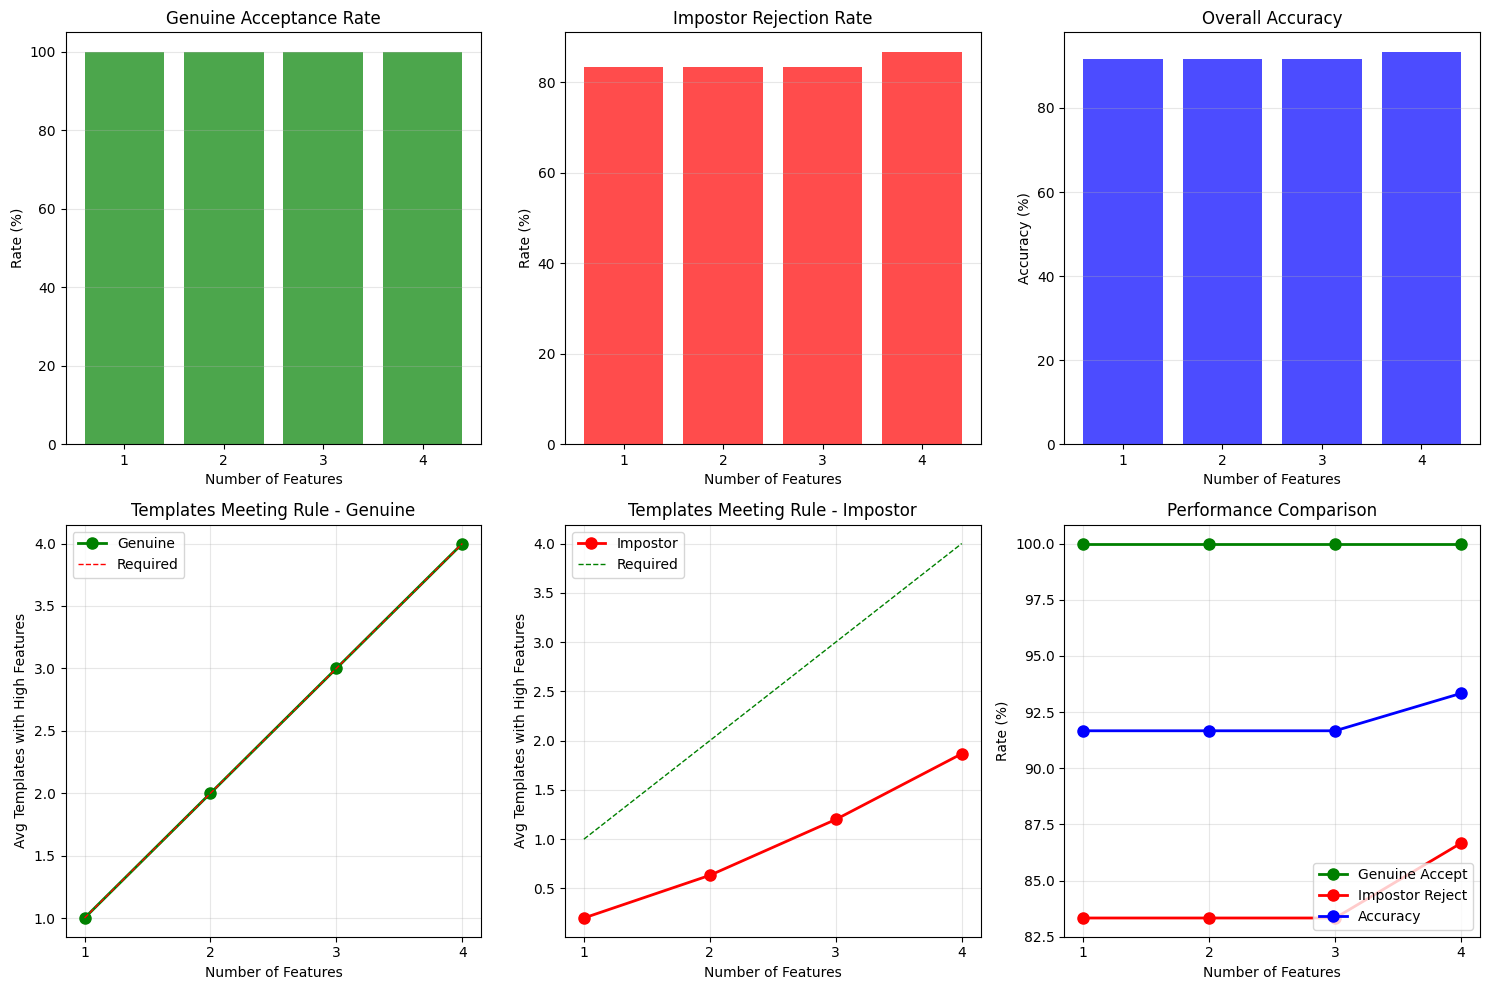


EVALUATION COMPLETED SUCCESSFULLY


In [15]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import seaborn as sns

def evaluate_authentication_performance(num_users=100, threshold_range=None, num_features_list=None):
    """
    Comprehensive performance evaluation of the authentication system
    Updated to test with 1,2,3,4 features and corresponding rule: at least N templates must pass
    where N equals number of features (for 4 features, need 4 templates with high features)
    """

    # Define rule-based parameters
    FEATURE_THRESHOLD = 0.999  # Individual feature must exceed this

    if threshold_range is None:
        # For rule-based evaluation, we're more interested in feature threshold
        threshold_range = np.arange(0.5, 1.0, 0.05)

    if num_features_list is None:
        # Test with 1,2,3,4 features
        num_features_list = [1, 2, 3, 4]

    print("=" * 70)
    print("AUTHENTICATION SYSTEM PERFORMANCE EVALUATION")
    print("=" * 70)
    print(f"Rule: At least one feature ≥ {FEATURE_THRESHOLD} in ≥ N templates (where N = number of features)")
    print("=" * 70)

    # Store all results
    all_results = {
        'genuine_scores': [],
        'impostor_scores': [],
        'metrics': {},
        'timing': {},
        'rule_based': {}  # NEW: Store rule-based authentication results
    }

    # Test different numbers of features
    for num_features in num_features_list:
        # For N features, require at least N templates to pass the rule
        min_templates_required = num_features

        print(f"\n{'='*60}")
        print(f"EVALUATING WITH {num_features} FEATURE(S)")
        print(f"Rule: ≥1 feature ≥{FEATURE_THRESHOLD} in ≥{min_templates_required} templates")
        print(f"{'='*60}")

        genuine_scores = []
        impostor_scores = []
        processing_times = []

        # NEW: Rule-based tracking
        rule_results = {
            'genuine_success': 0,
            'genuine_total': 0,
            'impostor_success': 0,  # Impostor rejected = success
            'impostor_total': 0,
            'templates_with_high_features': [],
            'feature_scores_genuine': [],
            'feature_scores_impostor': []
        }

        # Track genuine and impostor attempts
        for query_user_id in list(data.keys())[:num_users]:
            if query_user_id not in encrypted_database:
                continue

            # Get query vectors (take first num_features available)
            query_features = []
            for i in range(min(num_features, len(data[query_user_id]["features"]))):
                query_features.append(data[query_user_id]["features"][i])

            if not query_features or len(query_features) < num_features:
                continue

            # ========== GENUINE ATTEMPTS (Same User) ==========
            start_time = time.time()

            try:
                # Get target user's public context
                target_data = encrypted_database[query_user_id]
                target_public_context = ts.context_from(target_data['public_key'])

                # Encrypt query vectors
                enc_queries = []
                for query_vec in query_features:
                    enc_query = ts.ckks_vector(target_public_context, query_vec)
                    enc_queries.append(enc_query)

                # Get private context
                if query_user_id not in user_private_keys:
                    continue

                user_private_context = ts.context_from(user_private_keys[query_user_id])

                # Get encrypted features
                target_enc_features = target_data['encrypted_features']

                # NEW: Track templates with high features
                templates_with_high_features = 0
                all_feature_scores = []

                # Compare with each template (use num_templates = num_features for consistency)
                num_templates_to_check = min(num_features * 2, len(target_enc_features))  # Check enough templates
                best_avg_score = 0

                for template_idx, enc_feat_serialized in enumerate(target_enc_features[:num_templates_to_check]):
                    try:
                        enc_feat = ts.ckks_vector_from(target_public_context, enc_feat_serialized)

                        feature_scores = []
                        for enc_query in enc_queries:
                            # Compute similarity
                            dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                            # Decrypt and compute similarity
                            dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                            norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                            norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                            dp = dot_product_enc.decrypt()[0]
                            n1 = max(0, norm_sq_v1_enc.decrypt()[0])
                            n2 = max(0, norm_sq_v2_enc.decrypt()[0])

                            norm_v1 = np.sqrt(n1) if n1 > 0 else 0
                            norm_v2 = np.sqrt(n2) if n2 > 0 else 0

                            if norm_v1 == 0 or norm_v2 == 0:
                                similarity = 0.0
                            else:
                                similarity = dp / (norm_v1 * norm_v2)

                            similarity = max(-1.0, min(1.0, similarity))
                            feature_scores.append(similarity)

                        # Store all feature scores for analysis
                        all_feature_scores.extend(feature_scores)

                        # Check if any feature in this template meets threshold
                        if any(s >= FEATURE_THRESHOLD for s in feature_scores):
                            templates_with_high_features += 1

                        # Average score for this template (for traditional comparison)
                        avg_score = sum(feature_scores) / len(feature_scores)
                        best_avg_score = max(best_avg_score, avg_score)

                    except Exception as e:
                        continue

                # Store genuine results
                genuine_scores.append(best_avg_score)
                rule_results['genuine_total'] += 1
                rule_results['templates_with_high_features'].append(templates_with_high_features)
                rule_results['feature_scores_genuine'].extend(all_feature_scores)

                # Rule-based authentication decision
                if templates_with_high_features >= min_templates_required:
                    rule_results['genuine_success'] += 1

                # ========== IMPOSTOR ATTEMPTS (Different Users) ==========
                # Test against 5 different users
                impostor_targets = [uid for uid in list(encrypted_database.keys())[:20]
                                  if uid != query_user_id][:5]

                for imposter_id in impostor_targets:
                    try:
                        imposter_data = encrypted_database[imposter_id]
                        imposter_public_context = ts.context_from(imposter_data['public_key'])

                        # Re-encrypt queries with imposter's public key
                        enc_queries_imposter = []
                        for query_vec in query_features:
                            enc_query = ts.ckks_vector(imposter_public_context, query_vec)
                            enc_queries_imposter.append(enc_query)

                        imposter_enc_features = imposter_data['encrypted_features']

                        impostor_templates_with_high = 0
                        impostor_all_features = []
                        imposter_best_score = 0

                        for enc_feat_serialized in imposter_enc_features[:num_templates_to_check]:
                            try:
                                enc_feat = ts.ckks_vector_from(imposter_public_context, enc_feat_serialized)

                                feature_scores = []
                                for enc_query in enc_queries_imposter:
                                    dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                                    # Use query user's private context to decrypt
                                    dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                                    norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                                    norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                                    dp = dot_product_enc.decrypt()[0]
                                    n1 = max(0, norm_sq_v1_enc.decrypt()[0])
                                    n2 = max(0, norm_sq_v2_enc.decrypt()[0])

                                    norm_v1 = np.sqrt(n1) if n1 > 0 else 0
                                    norm_v2 = np.sqrt(n2) if n2 > 0 else 0

                                    if norm_v1 == 0 or norm_v2 == 0:
                                        similarity = 0.0
                                    else:
                                        similarity = dp / (norm_v1 * norm_v2)

                                    similarity = max(-1.0, min(1.0, similarity))
                                    feature_scores.append(similarity)

                                # Store features for analysis
                                impostor_all_features.extend(feature_scores)

                                # Check if any feature meets threshold
                                if any(s >= FEATURE_THRESHOLD for s in feature_scores):
                                    impostor_templates_with_high += 1

                                avg_score = sum(feature_scores) / len(feature_scores)
                                imposter_best_score = max(imposter_best_score, avg_score)

                            except Exception as e:
                                continue

                        # Store impostor results
                        impostor_scores.append(imposter_best_score)
                        rule_results['impostor_total'] += 1
                        rule_results['feature_scores_impostor'].extend(impostor_all_features)

                        # For impostor, success means REJECTED (templates_with_high < min_templates_required)
                        if impostor_templates_with_high < min_templates_required:
                            rule_results['impostor_success'] += 1

                    except Exception as e:
                        continue

                processing_time = time.time() - start_time
                processing_times.append(processing_time)

            except Exception as e:
                print(f"Error processing user {query_user_id}: {e}")
                continue

        # Calculate metrics
        if genuine_scores and impostor_scores:
            # Store scores
            all_results[f'genuine_{num_features}feat'] = genuine_scores
            all_results[f'impostor_{num_features}feat'] = impostor_scores
            all_results['timing'][f'avg_time_{num_features}feat'] = np.mean(processing_times)
            all_results['rule_based'][num_features] = rule_results

            # Calculate metrics for different thresholds (traditional approach)
            metrics = calculate_performance_metrics(genuine_scores, impostor_scores, threshold_range)

            # Add rule-based metrics
            metrics['rule_based'] = calculate_rule_based_metrics(rule_results, min_templates_required)

            all_results['metrics'][num_features] = metrics

            # Print summary
            print_summary(num_features, genuine_scores, impostor_scores, metrics, processing_times, rule_results, min_templates_required)

    # Generate comprehensive visualizations
    generate_visualizations(all_results, threshold_range, num_features_list, FEATURE_THRESHOLD)

    return all_results

def calculate_rule_based_metrics(rule_results, min_templates_required):
    """Calculate metrics specifically for rule-based authentication"""
    metrics = {}

    if rule_results['genuine_total'] > 0:
        metrics['genuine_accept_rate'] = rule_results['genuine_success'] / rule_results['genuine_total']
        metrics['false_rejection_rate'] = 1 - metrics['genuine_accept_rate']

    if rule_results['impostor_total'] > 0:
        metrics['impostor_reject_rate'] = rule_results['impostor_success'] / rule_results['impostor_total']
        metrics['false_acceptance_rate'] = 1 - metrics['impostor_reject_rate']

    if rule_results['genuine_total'] > 0 and rule_results['impostor_total'] > 0:
        total_attempts = rule_results['genuine_total'] + rule_results['impostor_total']
        correct_decisions = rule_results['genuine_success'] + rule_results['impostor_success']
        metrics['rule_accuracy'] = correct_decisions / total_attempts

    metrics['avg_templates_with_high_features'] = np.mean(rule_results['templates_with_high_features']) if rule_results['templates_with_high_features'] else 0
    metrics['min_templates_required'] = min_templates_required

    # Feature statistics
    if rule_results['feature_scores_genuine']:
        metrics['genuine_features_above_threshold'] = sum(1 for s in rule_results['feature_scores_genuine'] if s >= 0.999) / len(rule_results['feature_scores_genuine'])

    if rule_results['feature_scores_impostor']:
        metrics['impostor_features_above_threshold'] = sum(1 for s in rule_results['feature_scores_impostor'] if s >= 0.999) / len(rule_results['feature_scores_impostor'])

    return metrics

def calculate_performance_metrics(genuine_scores, impostor_scores, threshold_range):
    """Calculate various performance metrics"""
    metrics = {
        'thresholds': threshold_range,
        'far': [],  # False Acceptance Rate
        'frr': [],  # False Rejection Rate
        'gar': [],  # Genuine Acceptance Rate
        'eer': None,  # Equal Error Rate
        'auc': None,  # Area Under ROC Curve
        'best_threshold': None
    }

    # Calculate FAR and FRR for each threshold
    for threshold in threshold_range:
        # False Acceptance: Impostor accepted
        far = sum(score >= threshold for score in impostor_scores) / len(impostor_scores) if impostor_scores else 0

        # False Rejection: Genuine rejected
        frr = sum(score < threshold for score in genuine_scores) / len(genuine_scores) if genuine_scores else 0

        metrics['far'].append(far)
        metrics['frr'].append(frr)
        metrics['gar'].append(1 - frr)  # Genuine Acceptance Rate

    # Find Equal Error Rate (EER)
    min_diff_idx = np.argmin(np.abs(np.array(metrics['far']) - np.array(metrics['frr'])))
    metrics['eer'] = (metrics['far'][min_diff_idx] + metrics['frr'][min_diff_idx]) / 2
    metrics['best_threshold'] = threshold_range[min_diff_idx]

    # Calculate AUC for ROC curve
    y_true = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    y_scores = list(genuine_scores) + list(impostor_scores)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    metrics['auc'] = auc(fpr, tpr)

    # Calculate precision-recall metrics at best threshold
    tn = sum(score < metrics['best_threshold'] for score in impostor_scores)
    fp = sum(score >= metrics['best_threshold'] for score in impostor_scores)
    fn = sum(score < metrics['best_threshold'] for score in genuine_scores)
    tp = sum(score >= metrics['best_threshold'] for score in genuine_scores)

    metrics['confusion_matrix'] = [[tn, fp], [fn, tp]]
    metrics['accuracy'] = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall']) if (metrics['precision'] + metrics['recall']) > 0 else 0

    return metrics

def print_summary(num_features, genuine_scores, impostor_scores, metrics, processing_times, rule_results=None, min_templates_required=None):
    """Print summary including rule-based metrics"""
    print(f"\nSUMMARY FOR {num_features} FEATURE(S):")
    print("-" * 40)

    print(f"Number of genuine attempts: {len(genuine_scores)}")
    print(f"Number of impostor attempts: {len(impostor_scores)}")
    print(f"Average processing time: {np.mean(processing_times):.3f} seconds")
    print(f"Min processing time: {np.min(processing_times):.3f} seconds")
    print(f"Max processing time: {np.max(processing_times):.3f} seconds")

    print(f"\nScore Statistics:")
    print(f"  Genuine scores - Mean: {np.mean(genuine_scores):.4f}, Std: {np.std(genuine_scores):.4f}")
    print(f"  Impostor scores - Mean: {np.mean(impostor_scores):.4f}, Std: {np.std(impostor_scores):.4f}")

    if min_templates_required:
        print(f"\n{'='*40}")
        print("RULE-BASED AUTHENTICATION RESULTS")
        print(f"(Rule: ≥1 feature ≥0.99 in ≥{min_templates_required} templates)")
        print(f"{'='*40}")

    if rule_results:
        print(f"\nGenuine Attempts:")
        print(f"  Successfully authenticated: {rule_results['genuine_success']}/{rule_results['genuine_total']}")
        print(f"  Genuine Acceptance Rate: {rule_results['genuine_success']/rule_results['genuine_total']*100:.2f}%")
        print(f"  False Rejection Rate: {(1 - rule_results['genuine_success']/rule_results['genuine_total'])*100:.2f}%")

        print(f"\nImpostor Attempts:")
        print(f"  Successfully rejected: {rule_results['impostor_success']}/{rule_results['impostor_total']}")
        print(f"  Impostor Rejection Rate: {rule_results['impostor_success']/rule_results['impostor_total']*100:.2f}%")
        print(f"  False Acceptance Rate: {(1 - rule_results['impostor_success']/rule_results['impostor_total'])*100:.2f}%")

        if 'rule_accuracy' in metrics['rule_based']:
            print(f"\nOverall Rule Accuracy: {metrics['rule_based']['rule_accuracy']*100:.2f}%")
        print(f"Avg templates with high features: {metrics['rule_based']['avg_templates_with_high_features']:.2f}")

        # Feature statistics
        if 'genuine_features_above_threshold' in metrics['rule_based']:
            print(f"Genuine features ≥0.99: {metrics['rule_based']['genuine_features_above_threshold']*100:.2f}%")
        if 'impostor_features_above_threshold' in metrics['rule_based']:
            print(f"Impostor features ≥0.99: {metrics['rule_based']['impostor_features_above_threshold']*100:.2f}%")

    print(f"\n{'='*40}")
    print("TRADITIONAL THRESHOLD-BASED METRICS")
    print(f"{'='*40}")
    print(f"  Best Threshold: {metrics['best_threshold']:.4f}")
    print(f"  Equal Error Rate (EER): {metrics['eer']:.4f}")
    print(f"  AUC: {metrics['auc']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")

    # Print confusion matrix at best threshold
    cm = metrics['confusion_matrix']
    print(f"\nConfusion Matrix at threshold {metrics['best_threshold']:.4f}:")
    print(f"          Predicted Negative  Predicted Positive")
    print(f"Actual Negative      {cm[0][0]:4d}             {cm[0][1]:4d}")
    print(f"Actual Positive      {cm[1][0]:4d}             {cm[1][1]:4d}")

def generate_visualizations(all_results, threshold_range, num_features_list, feature_threshold=0.99):
    """Generate comprehensive visualizations including rule-based comparison"""

    plt.figure(figsize=(24, 16))

    # 1. Score Distribution
    plt.subplot(2, 4, 1)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(num_features_list)))

    for idx, num_features in enumerate(num_features_list):
        genuine_key = f'genuine_{num_features}feat'
        impostor_key = f'impostor_{num_features}feat'

        if genuine_key in all_results and impostor_key in all_results:
            plt.hist(all_results[genuine_key], bins=30, alpha=0.5,
                    label=f'Genuine ({num_features} feat)', color=colors[idx], density=True)
            plt.hist(all_results[impostor_key], bins=30, alpha=0.5,
                    label=f'Impostor ({num_features} feat)', color=colors[idx],
                    linestyle='dashed', density=True)

    plt.axvline(x=feature_threshold, color='red', linestyle='--', linewidth=2, label=f'Feature Threshold ({feature_threshold})')
    plt.xlabel('Similarity Score')
    plt.ylabel('Density')
    plt.title('Score Distribution by Feature Count')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. ROC Curves
    plt.subplot(2, 4, 2)
    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            metrics = all_results['metrics'][num_features]
            y_true = [1] * len(all_results[f'genuine_{num_features}feat']) + \
                    [0] * len(all_results[f'impostor_{num_features}feat'])
            y_scores = all_results[f'genuine_{num_features}feat'] + \
                      all_results[f'impostor_{num_features}feat']
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = metrics['auc']
            plt.plot(fpr, tpr, label=f'{num_features} feat (AUC = {roc_auc:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Feature Count')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # 3. FAR vs FRR (DET Curve)
    plt.subplot(2, 4, 3)
    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            metrics = all_results['metrics'][num_features]
            plt.plot(threshold_range, metrics['far'], label=f'{num_features} feat FAR', linewidth=2)
            plt.plot(threshold_range, metrics['frr'], label=f'{num_features} feat FRR',
                    linewidth=2, linestyle='--')

    plt.axhline(y=0.01, color='red', linestyle=':', alpha=0.5, label='1% Error Rate')
    plt.xlabel('Threshold')
    plt.ylabel('Error Rate')
    plt.title('FAR vs FRR (DET Curve) by Feature Count')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Rule-Based Performance Comparison
    plt.subplot(2, 4, 4)
    rule_metrics = ['genuine_accept', 'impostor_reject', 'rule_accuracy']
    x_pos = np.arange(len(num_features_list))
    width = 0.25

    for i, metric in enumerate(rule_metrics):
        values = []
        for num_features in num_features_list:
            if num_features in all_results['rule_based']:
                rule_results = all_results['rule_based'][num_features]
                if metric == 'genuine_accept':
                    val = rule_results['genuine_success'] / rule_results['genuine_total'] if rule_results['genuine_total'] > 0 else 0
                elif metric == 'impostor_reject':
                    val = rule_results['impostor_success'] / rule_results['impostor_total'] if rule_results['impostor_total'] > 0 else 0
                else:
                    total = rule_results['genuine_total'] + rule_results['impostor_total']
                    correct = rule_results['genuine_success'] + rule_results['impostor_success']
                    val = correct / total if total > 0 else 0
                values.append(val)
            else:
                values.append(0)

        plt.bar(x_pos + i*width, values, width, label=metric.replace('_', ' ').title())

    plt.xlabel('Number of Features')
    plt.ylabel('Rate')
    plt.title(f'Rule-Based Performance\n(Need N templates with ≥{feature_threshold})')
    plt.xticks(x_pos + width, [f'{n} feat\n(need {n} templates)' for n in num_features_list])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # 5. Templates with High Features Analysis
    plt.subplot(2, 4, 5)
    for num_features in num_features_list:
        if num_features in all_results['rule_based']:
            templates_high = all_results['rule_based'][num_features]['templates_with_high_features']
            plt.hist(templates_high, bins=range(10), alpha=0.5, label=f'{num_features} feat', density=True)
            plt.axvline(x=num_features - 0.5, color=plt.cm.rainbow(num_features/len(num_features_list)),
                       linestyle='--', linewidth=2, alpha=0.7)

    plt.xlabel('Number of Templates with High Features')
    plt.ylabel('Density')
    plt.title('Templates Meeting Feature Threshold\n(Dashed = Required for each config)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Performance Metrics Comparison
    plt.subplot(2, 4, 6)
    metrics_to_plot = ['eer', 'auc', 'accuracy', 'f1_score']
    x_pos = np.arange(len(num_features_list))
    width = 0.2

    for i, metric in enumerate(metrics_to_plot):
        values = []
        for num_features in num_features_list:
            if num_features in all_results['metrics']:
                values.append(all_results['metrics'][num_features][metric])
            else:
                values.append(0)

        plt.bar(x_pos + i*width, values, width, label=metric.upper())

    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.title('Traditional Metrics Comparison')
    plt.xticks(x_pos + width*1.5, [str(n) for n in num_features_list])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # 7. Processing Time Analysis
    plt.subplot(2, 4, 7)
    processing_times = []
    for num_features in num_features_list:
        time_key = f'avg_time_{num_features}feat'
        if time_key in all_results['timing']:
            processing_times.append(all_results['timing'][time_key])
        else:
            processing_times.append(0)

    plt.bar([str(n) for n in num_features_list], processing_times, color='skyblue')
    plt.xlabel('Number of Features')
    plt.ylabel('Average Time (seconds)')
    plt.title('Processing Time Analysis')
    plt.grid(True, alpha=0.3, axis='y')

    # 8. Rule Success Rate vs Feature Count
    plt.subplot(2, 4, 8)

    genuine_rates = []
    impostor_rates = []
    accuracy_rates = []

    for num_features in num_features_list:
        if num_features in all_results['rule_based']:
            rule_results = all_results['rule_based'][num_features]
            genuine_rates.append(rule_results['genuine_success'] / rule_results['genuine_total'])
            impostor_rates.append(rule_results['impostor_success'] / rule_results['impostor_total'])
            total = rule_results['genuine_total'] + rule_results['impostor_total']
            correct = rule_results['genuine_success'] + rule_results['impostor_success']
            accuracy_rates.append(correct / total)
        else:
            genuine_rates.append(0)
            impostor_rates.append(0)
            accuracy_rates.append(0)

    plt.plot(num_features_list, genuine_rates, 'go-', linewidth=2, markersize=8, label='Genuine Accept Rate')
    plt.plot(num_features_list, impostor_rates, 'ro-', linewidth=2, markersize=8, label='Impostor Reject Rate')
    plt.plot(num_features_list, accuracy_rates, 'bo-', linewidth=2, markersize=8, label='Overall Accuracy')
    plt.xlabel('Number of Features')
    plt.ylabel('Rate')
    plt.title('Rule-Based Performance Trends')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(num_features_list)

    plt.tight_layout()
    plt.show()

    # Generate comprehensive report
    print("\n" + "="*70)
    print("COMPREHENSIVE PERFORMANCE REPORT")
    print("="*70)

    # Find best configuration for rule-based
    best_rule_config = None
    best_rule_accuracy = 0

    for num_features in num_features_list:
        if num_features in all_results['rule_based']:
            rule_results = all_results['rule_based'][num_features]
            total = rule_results['genuine_total'] + rule_results['impostor_total']
            correct = rule_results['genuine_success'] + rule_results['impostor_success']
            accuracy = correct / total if total > 0 else 0

            if accuracy > best_rule_accuracy:
                best_rule_accuracy = accuracy
                best_rule_config = num_features

    if best_rule_config is not None:
        print(f"\n✓ BEST RULE-BASED CONFIGURATION: {best_rule_config} feature(s)")
        print(f"   (Rule: Need {best_rule_config} templates with ≥{feature_threshold})")
        print(f"  - Rule Accuracy: {best_rule_accuracy*100:.2f}%")

        rule_results = all_results['rule_based'][best_rule_config]
        print(f"  - Genuine Accept Rate: {rule_results['genuine_success']/rule_results['genuine_total']*100:.2f}%")
        print(f"  - Impostor Reject Rate: {rule_results['impostor_success']/rule_results['impostor_total']*100:.2f}%")

    # Find best configuration for traditional metrics
    best_trad_config = None
    best_eer = float('inf')

    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            eer = all_results['metrics'][num_features]['eer']
            if eer < best_eer:
                best_eer = eer
                best_trad_config = num_features

    if best_trad_config is not None:
        print(f"\n✓ BEST TRADITIONAL CONFIGURATION: {best_trad_config} feature(s)")
        print(f"  - EER: {best_eer:.4f}")
        print(f"  - AUC: {all_results['metrics'][best_trad_config]['auc']:.4f}")
        print(f"  - Recommended Threshold: {all_results['metrics'][best_trad_config]['best_threshold']:.4f}")

    print("\n" + "="*70)
    print("EVALUATION COMPLETED")
    print("="*70)

# Function to run quick evaluation with rule-based logic for 1-4 features
def quick_evaluation_rule_based(num_users=50, feature_threshold=0.99):
    """
    Quick evaluation function testing 1,2,3,4 features with corresponding rules
    """
    print("\n" + "="*70)
    print("QUICK RULE-BASED PERFORMANCE EVALUATION")
    print("="*70)

    num_features_list = [1, 2, 3, 4]
    results = {}

    for num_features in num_features_list:
        min_templates_required = num_features
        print(f"\n{'='*60}")
        print(f"TESTING WITH {num_features} FEATURE(S)")
        print(f"Rule: ≥1 feature ≥{feature_threshold} in ≥{min_templates_required} templates")
        print(f"{'='*60}")

        results[num_features] = {
            'genuine': {'success': 0, 'total': 0, 'scores': [], 'templates_with_high': []},
            'impostor': {'success': 0, 'total': 0, 'scores': [], 'templates_with_high': []}
        }

        for user_id in list(data.keys())[:num_users]:
            if user_id not in encrypted_database:
                continue

            # Get query features
            if len(data[user_id]["features"]) < num_features:
                continue

            query_features = data[user_id]["features"][:num_features]

            # ========== GENUINE ATTEMPT ==========
            try:
                target_data = encrypted_database[user_id]
                target_public_context = ts.context_from(target_data['public_key'])

                # Encrypt queries
                enc_queries = [ts.ckks_vector(target_public_context, q) for q in query_features]

                # Get private context
                user_private_context = ts.context_from(user_private_keys[user_id])

                # Check multiple templates
                templates_with_high = 0
                template_scores = []

                num_templates_to_check = min(num_features * 2, len(target_data['encrypted_features']))
                for template_idx in range(num_templates_to_check):
                    enc_feat = ts.ckks_vector_from(target_public_context, target_data['encrypted_features'][template_idx])

                    feature_scores = []
                    for enc_query in enc_queries:
                        dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                        # Decrypt
                        dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                        norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                        norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                        dot_product_dec = dot_product_enc.decrypt()[0]
                        norm_sq_v1_dec = max(0, norm_sq_v1_enc.decrypt()[0])
                        norm_sq_v2_dec = max(0, norm_sq_v2_enc.decrypt()[0])

                        norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                        norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                        if norm_v1 == 0 or norm_v2 == 0:
                            similarity = 0.0
                        else:
                            similarity = dot_product_dec / (norm_v1 * norm_v2)

                        similarity = max(-1.0, min(1.0, similarity))
                        feature_scores.append(similarity)

                    # Check if any feature in this template meets threshold
                    if any(s >= feature_threshold for s in feature_scores):
                        templates_with_high += 1

                    # Store average score
                    if feature_scores:
                        avg_score = sum(feature_scores) / len(feature_scores)
                        template_scores.append(avg_score)

                # Record results
                results[num_features]['genuine']['total'] += 1
                results[num_features]['genuine']['templates_with_high'].append(templates_with_high)
                if templates_with_high >= min_templates_required:
                    results[num_features]['genuine']['success'] += 1

                # Store best score
                if template_scores:
                    results[num_features]['genuine']['scores'].append(max(template_scores))

            except Exception as e:
                print(f"Error in genuine attempt for user {user_id} with {num_features} features: {e}")
                continue

            # ========== IMPOSTOR ATTEMPT ==========
            try:
                # Select a different user as impostor target
                imposter_id = None
                for uid in encrypted_database.keys():
                    if uid != user_id:
                        imposter_id = uid
                        break

                if imposter_id is None:
                    continue

                imposter_data = encrypted_database[imposter_id]
                imposter_public_context = ts.context_from(imposter_data['public_key'])

                # Re-encrypt queries with imposter's key
                enc_queries_imp = [ts.ckks_vector(imposter_public_context, q) for q in query_features]

                templates_with_high = 0
                template_scores = []

                num_templates_to_check = min(num_features * 2, len(imposter_data['encrypted_features']))
                for template_idx in range(num_templates_to_check):
                    enc_feat_imp = ts.ckks_vector_from(imposter_public_context, imposter_data['encrypted_features'][template_idx])

                    feature_scores = []
                    for enc_query in enc_queries_imp:
                        dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat_imp)

                        # Decrypt with original user's key
                        dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                        norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                        norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                        dot_product_dec = dot_product_enc.decrypt()[0]
                        norm_sq_v1_dec = max(0, norm_sq_v1_enc.decrypt()[0])
                        norm_sq_v2_dec = max(0, norm_sq_v2_enc.decrypt()[0])

                        norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                        norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                        if norm_v1 == 0 or norm_v2 == 0:
                            similarity = 0.0
                        else:
                            similarity = dot_product_dec / (norm_v1 * norm_v2)

                        similarity = max(-1.0, min(1.0, similarity))
                        feature_scores.append(similarity)

                    # Check if any feature meets threshold
                    if any(s >= feature_threshold for s in feature_scores):
                        templates_with_high += 1

                    # Store average score
                    if feature_scores:
                        avg_score = sum(feature_scores) / len(feature_scores)
                        template_scores.append(avg_score)

                # Record results - for impostor, success means REJECTED
                results[num_features]['impostor']['total'] += 1
                results[num_features]['impostor']['templates_with_high'].append(templates_with_high)
                if templates_with_high < min_templates_required:
                    results[num_features]['impostor']['success'] += 1

                # Store best score
                if template_scores:
                    results[num_features]['impostor']['scores'].append(max(template_scores))

            except Exception as e:
                print(f"Error in impostor attempt for user {user_id} with {num_features} features: {e}")
                continue

    # Print summary for all feature configurations
    print(f"\n{'='*70}")
    print("QUICK EVALUATION SUMMARY - ALL CONFIGURATIONS")
    print(f"{'='*70}")

    for num_features in num_features_list:
        min_templates = num_features
        print(f"\n{'—'*50}")
        print(f"CONFIGURATION: {num_features} FEATURE(S) - Need {min_templates} templates with ≥{feature_threshold}")
        print(f"{'—'*50}")

        genuine = results[num_features]['genuine']
        impostor = results[num_features]['impostor']

        if genuine['total'] > 0:
            genuine_rate = genuine['success'] / genuine['total'] * 100
            print(f"\n✅ GENUINE ATTEMPTS:")
            print(f"   Total: {genuine['total']}")
            print(f"   Successfully authenticated: {genuine['success']}")
            print(f"   Genuine Acceptance Rate: {genuine_rate:.2f}%")
            print(f"   False Rejection Rate: {100 - genuine_rate:.2f}%")
            print(f"   Avg templates with high features: {np.mean(genuine['templates_with_high']):.2f}")

            if genuine['scores']:
                print(f"   Score Mean: {np.mean(genuine['scores']):.4f}")

        if impostor['total'] > 0:
            impostor_rate = impostor['success'] / impostor['total'] * 100
            print(f"\n❌ IMPOSTOR ATTEMPTS:")
            print(f"   Total: {impostor['total']}")
            print(f"   Successfully rejected: {impostor['success']}")
            print(f"   Impostor Rejection Rate: {impostor_rate:.2f}%")
            print(f"   False Acceptance Rate: {100 - impostor_rate:.2f}%")
            print(f"   Avg templates with high features: {np.mean(impostor['templates_with_high']):.2f}")

            if impostor['scores']:
                print(f"   Score Mean: {np.mean(impostor['scores']):.4f}")

        # Overall accuracy
        total_attempts = genuine['total'] + impostor['total']
        correct_decisions = genuine['success'] + impostor['success']

        if total_attempts > 0:
            accuracy = correct_decisions / total_attempts * 100
            print(f"\n📊 OVERALL ACCURACY: {accuracy:.2f}%")

    # Create comparison plot
    plt.figure(figsize=(15, 10))

    # Subplot 1: Genuine Acceptance Rate
    plt.subplot(2, 3, 1)
    genuine_rates = [results[n]['genuine']['success']/results[n]['genuine']['total']*100 if results[n]['genuine']['total']>0 else 0
                     for n in num_features_list]
    plt.bar(num_features_list, genuine_rates, color='green', alpha=0.7)
    plt.xlabel('Number of Features')
    plt.ylabel('Rate (%)')
    plt.title('Genuine Acceptance Rate')
    plt.xticks(num_features_list)
    plt.grid(True, alpha=0.3, axis='y')

    # Subplot 2: Impostor Rejection Rate
    plt.subplot(2, 3, 2)
    impostor_rates = [results[n]['impostor']['success']/results[n]['impostor']['total']*100 if results[n]['impostor']['total']>0 else 0
                      for n in num_features_list]
    plt.bar(num_features_list, impostor_rates, color='red', alpha=0.7)
    plt.xlabel('Number of Features')
    plt.ylabel('Rate (%)')
    plt.title('Impostor Rejection Rate')
    plt.xticks(num_features_list)
    plt.grid(True, alpha=0.3, axis='y')

    # Subplot 3: Overall Accuracy
    plt.subplot(2, 3, 3)
    accuracies = []
    for n in num_features_list:
        total = results[n]['genuine']['total'] + results[n]['impostor']['total']
        correct = results[n]['genuine']['success'] + results[n]['impostor']['success']
        accuracies.append(correct/total*100 if total>0 else 0)

    plt.bar(num_features_list, accuracies, color='blue', alpha=0.7)
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy (%)')
    plt.title('Overall Accuracy')
    plt.xticks(num_features_list)
    plt.grid(True, alpha=0.3, axis='y')

    # Subplot 4: Templates with High Features - Genuine
    plt.subplot(2, 3, 4)
    genuine_high_templates = [np.mean(results[n]['genuine']['templates_with_high']) if results[n]['genuine']['templates_with_high'] else 0
                              for n in num_features_list]
    plt.plot(num_features_list, genuine_high_templates, 'go-', linewidth=2, markersize=8, label='Genuine')
    plt.plot(num_features_list, num_features_list, 'r--', linewidth=1, label='Required')
    plt.xlabel('Number of Features')
    plt.ylabel('Avg Templates with High Features')
    plt.title('Templates Meeting Rule - Genuine')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(num_features_list)

    # Subplot 5: Templates with High Features - Impostor
    plt.subplot(2, 3, 5)
    impostor_high_templates = [np.mean(results[n]['impostor']['templates_with_high']) if results[n]['impostor']['templates_with_high'] else 0
                               for n in num_features_list]
    plt.plot(num_features_list, impostor_high_templates, 'ro-', linewidth=2, markersize=8, label='Impostor')
    plt.plot(num_features_list, num_features_list, 'g--', linewidth=1, label='Required')
    plt.xlabel('Number of Features')
    plt.ylabel('Avg Templates with High Features')
    plt.title('Templates Meeting Rule - Impostor')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(num_features_list)

    # Subplot 6: Comparison
    plt.subplot(2, 3, 6)
    plt.plot(num_features_list, genuine_rates, 'go-', linewidth=2, markersize=8, label='Genuine Accept')
    plt.plot(num_features_list, impostor_rates, 'ro-', linewidth=2, markersize=8, label='Impostor Reject')
    plt.plot(num_features_list, accuracies, 'bo-', linewidth=2, markersize=8, label='Accuracy')
    plt.xlabel('Number of Features')
    plt.ylabel('Rate (%)')
    plt.title('Performance Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(num_features_list)

    plt.tight_layout()
    plt.show()

    return results

# Run the comprehensive evaluation
if __name__ == "__main__":
    print("Starting performance evaluation...")

    # Option 1: Run quick evaluation with rule-based logic for 1-4 features
    print("\n" + "="*70)
    print("RUNNING QUICK RULE-BASED EVALUATION")
    print("="*70)
    quick_results = quick_evaluation_rule_based(num_users=30, feature_threshold=0.999)

    # Option 2: Run full comprehensive evaluation (uncomment to run)
    # print("\n" + "="*70)
    # print("RUNNING FULL COMPREHENSIVE EVALUATION")
    # print("="*70)
    # full_results = evaluate_authentication_performance(num_users=30, num_features_list=[1, 2, 3, 4])

    print("\n" + "="*70)
    print("EVALUATION COMPLETED SUCCESSFULLY")
    print("="*70)



RUNNING FULL COMPREHENSIVE EVALUATION
AUTHENTICATION SYSTEM PERFORMANCE EVALUATION
Rule: At least one feature ≥ 0.999 in ≥ N templates (where N = number of features)

EVALUATING WITH 1 FEATURE(S)
Rule: ≥1 feature ≥0.999 in ≥1 templates

SUMMARY FOR 1 FEATURE(S):
----------------------------------------
Number of genuine attempts: 30
Number of impostor attempts: 150
Average processing time: 2.665 seconds
Min processing time: 2.474 seconds
Max processing time: 3.306 seconds

Score Statistics:
  Genuine scores - Mean: 1.0000, Std: 0.0000
  Impostor scores - Mean: 0.1710, Std: 0.3466

RULE-BASED AUTHENTICATION RESULTS
(Rule: ≥1 feature ≥0.99 in ≥1 templates)

Genuine Attempts:
  Successfully authenticated: 30/30
  Genuine Acceptance Rate: 100.00%
  False Rejection Rate: 0.00%

Impostor Attempts:
  Successfully rejected: 134/150
  Impostor Rejection Rate: 89.33%
  False Acceptance Rate: 10.67%

Overall Rule Accuracy: 91.11%
Avg templates with high features: 1.00
Genuine features ≥0.99: 50.

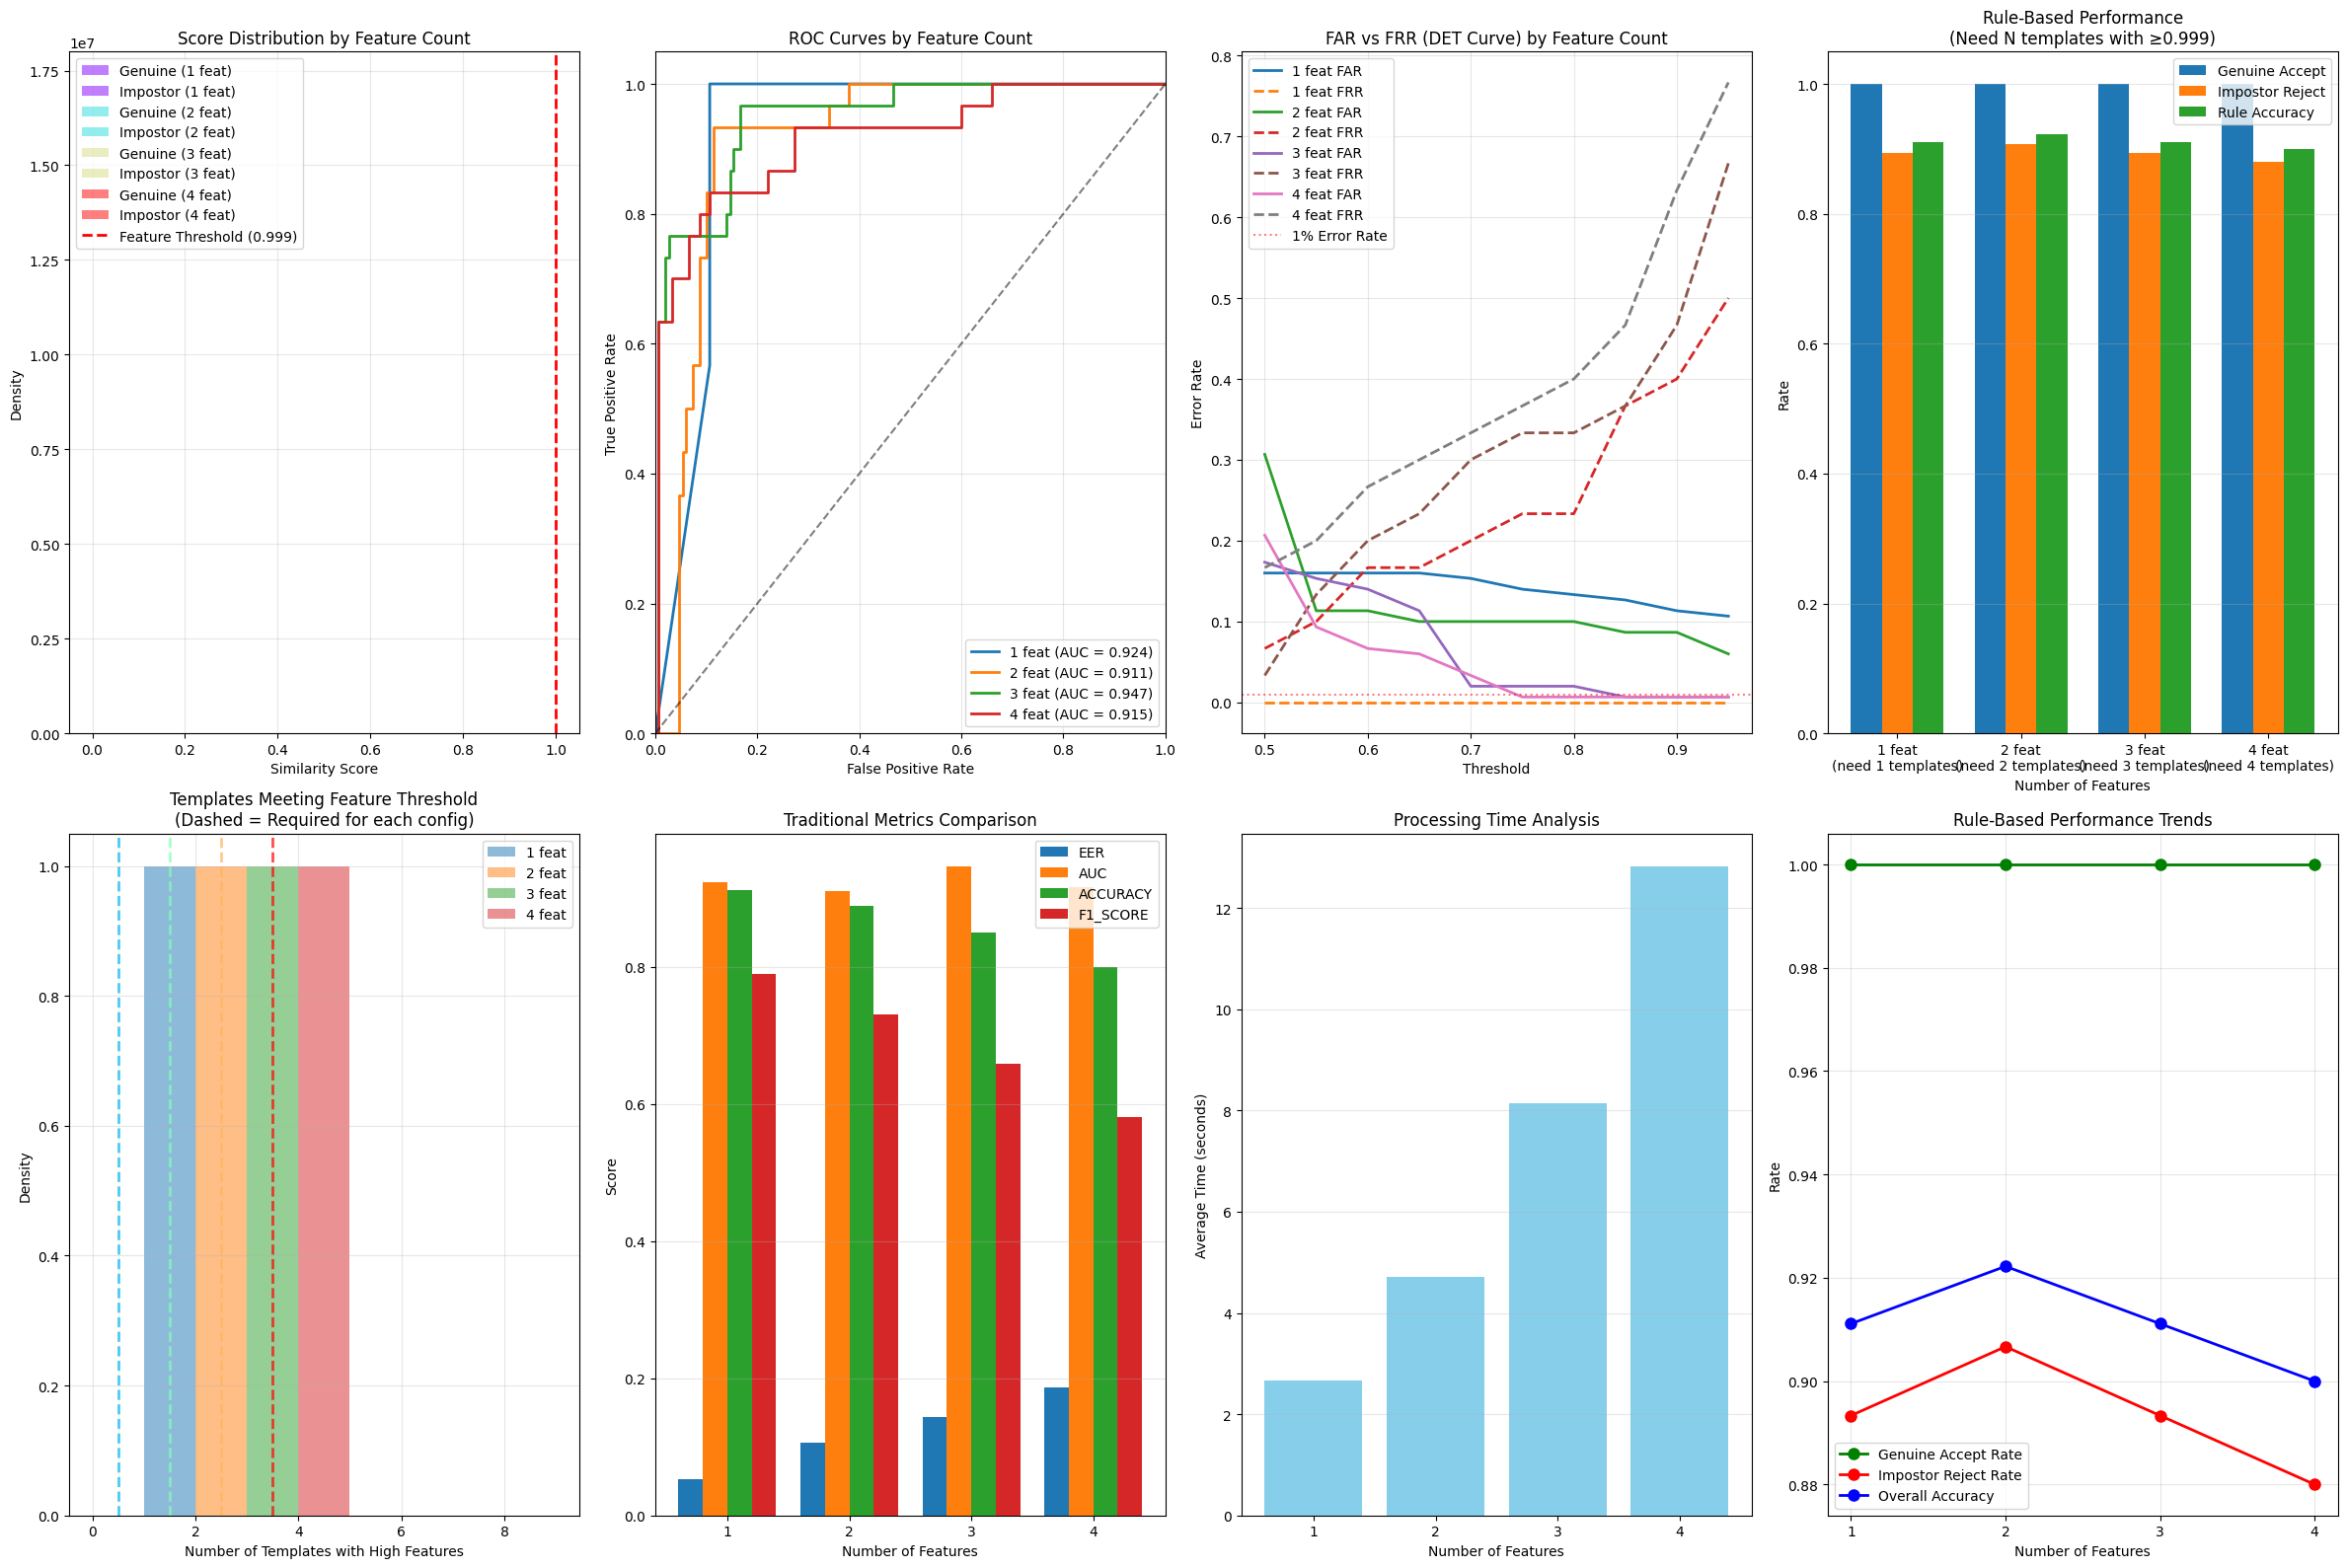


COMPREHENSIVE PERFORMANCE REPORT

✓ BEST RULE-BASED CONFIGURATION: 2 feature(s)
   (Rule: Need 2 templates with ≥0.999)
  - Rule Accuracy: 92.22%
  - Genuine Accept Rate: 100.00%
  - Impostor Reject Rate: 90.67%

✓ BEST TRADITIONAL CONFIGURATION: 1 feature(s)
  - EER: 0.0533
  - AUC: 0.9236
  - Recommended Threshold: 0.9500

EVALUATION COMPLETED


In [16]:
print("\n" + "="*70)
print("RUNNING FULL COMPREHENSIVE EVALUATION")
print("="*70)
full_results = evaluate_authentication_performance(num_users=30, num_features_list=[1, 2, 3, 4])

In [17]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00



ENHANCED XAI ANALYSIS - STRUCTURED + VISUAL + RULE-BASED

📊 DETECTED CONFIGURATION:
   Number of features: 2
   Rule: At least one feature ≥ 0.99 in ≥ 2 templates

📊 STRUCTURED XAI EXPLANATION:
{
  "query_user_id": "24",
  "configuration": {
    "num_features": 2,
    "feature_threshold": 0.99,
    "min_templates_required": 2,
    "average_threshold": 0.7
  },
  "authentication_rules": {
    "rule_based": {
      "enabled": true,
      "templates_meeting_rule": 4,
      "success": true,
      "templates_detail": [
        {
          "template": 3,
          "high_features": [
            1.0
          ],
          "count": 1,
          "max_feature": 1.0,
          "avg_score": 0.9948302791735171
        },
        {
          "template": 4,
          "high_features": [
            1.0
          ],
          "count": 1,
          "max_feature": 1.0,
          "avg_score": 0.9948302673407257
        },
        {
          "template": 6,
          "high_features": [
            0.99262

/tmp/ipython-input-478/3562756425.py:530: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-478/3562756425.py:530: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-478/3562756425.py:530: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-478/3562756425.py:530: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

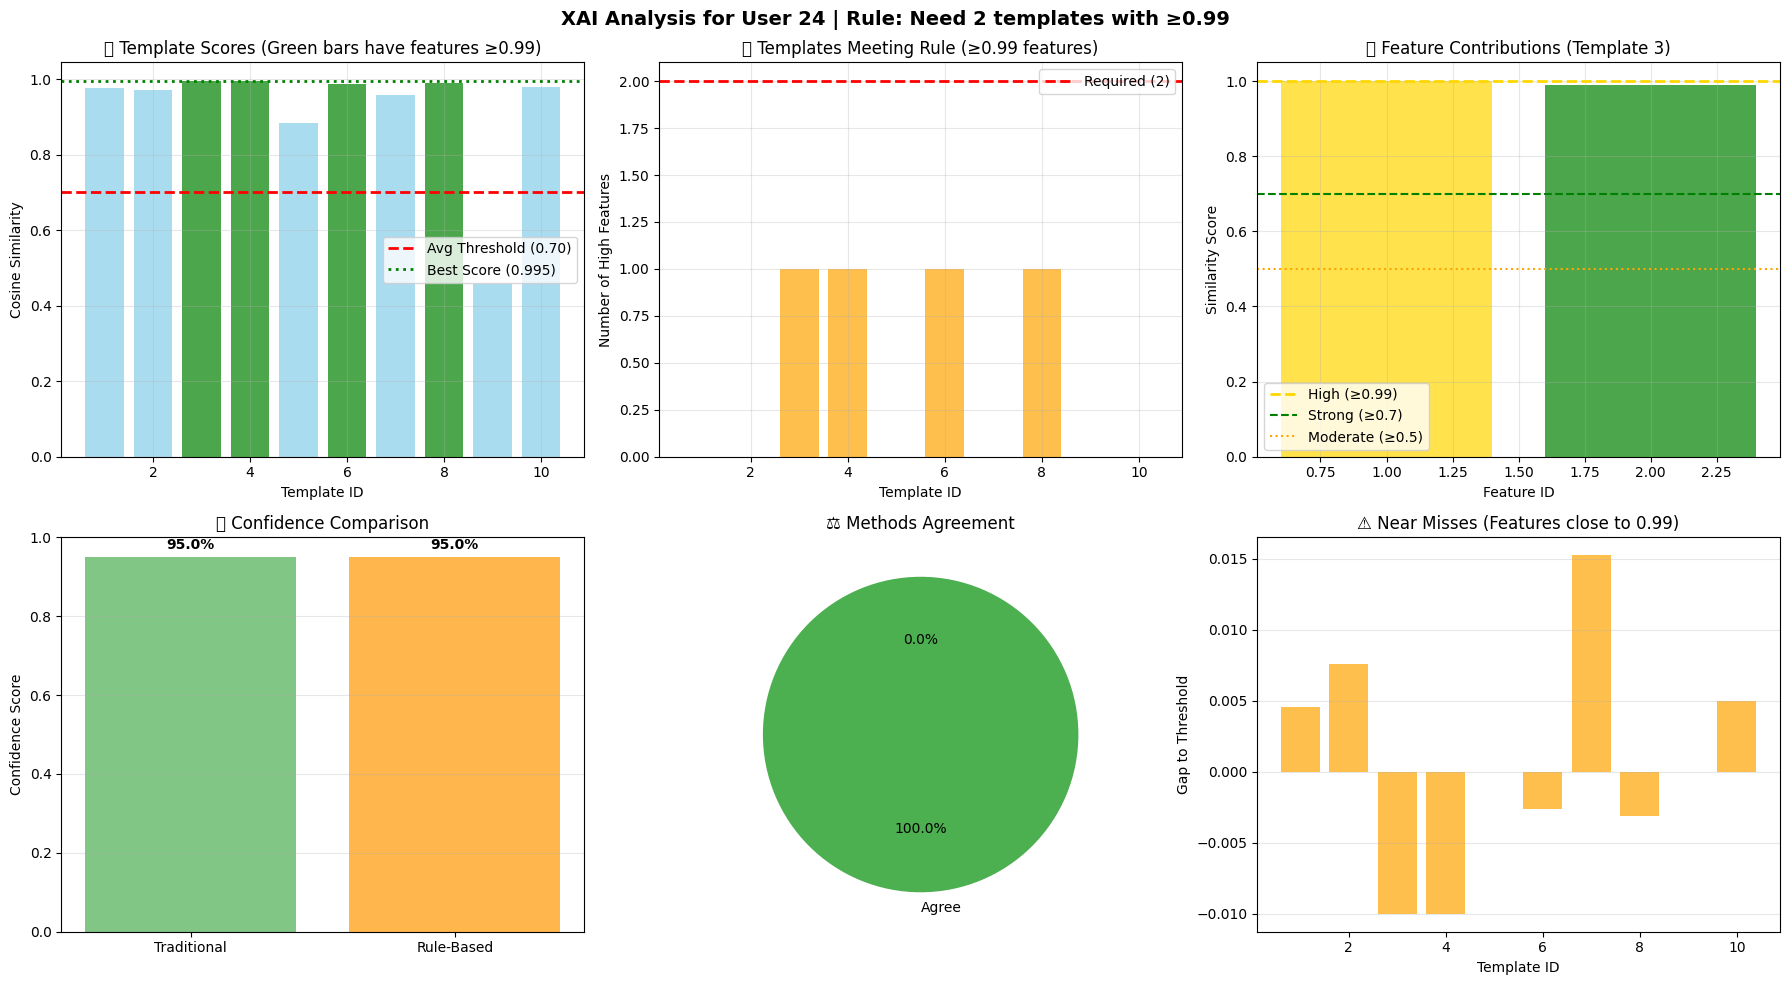


✅ ENHANCED XAI COMPLETE
   • Structured JSON with rule-based metrics
   • Quick summary with both methods
   • Detailed template analysis
   • Visual charts with rule-based indicators
   • Ready for logging/API/web UI

📄 GENERATING COMPREHENSIVE XAI REPORT PDF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ COMPREHENSIVE PDF REPORT DOWNLOADED: XAI_Complete_Report_User24_0.995.pdf

📄 Report contains:
   • Quick Summary with both authentication methods
   • Detailed Template Analysis
   • Rule-Based Authentication Results
   • Traditional Threshold-Based Results
   • Feature-level breakdown
   • Confidence Assessment
   • Security Indicators
   • Professional visualizations (6 charts)
   • Structured JSON data
   • Ready for papers/audits/demos!


In [18]:
import numpy as np
import json

class AuthenticationXI:
    def __init__(self, threshold=0.70, feature_threshold=0.999):
        self.threshold = threshold
        self.feature_threshold = feature_threshold

    def explain_authentication(self, query_user_id, template_scores, feature_similarities_all, threshold=None):
        """Enhanced human-readable explanations with rule-based logic."""

        # Use instance threshold if not overridden
        if threshold is None:
            threshold = self.threshold

        print(f"\n{'='*60}")
        print("EXPLAINABLE AI (XAI) - AUTHENTICATION DECISION ANALYSIS")
        print(f"{'='*60}")
        print(f"User ID: {query_user_id}")

        if not template_scores or not feature_similarities_all:
            print("❌ No authentication data available")
            return

        # Determine number of features from the data
        num_features = len(feature_similarities_all[0]) if feature_similarities_all and feature_similarities_all[0] else 0
        min_templates_required = num_features  # For N features, need N templates

        print(f"\n📊 CONFIGURATION:")
        print(f"   Number of features: {num_features}")
        print(f"   Rule: At least one feature ≥ {self.feature_threshold} in ≥ {min_templates_required} templates")
        print(f"   Average threshold: {threshold}")

        # Analyze rule-based authentication
        templates_meeting_rule = []
        rule_based_success = False

        print(f"\n{'🔍 TEMPLATE ANALYSIS':^60}")
        print("-" * 60)

        for idx, features in enumerate(feature_similarities_all):
            if features:
                # Check if any feature in this template meets threshold
                high_features = [f for f in features if f >= self.feature_threshold]
                template_meets_rule = len(high_features) > 0

                if template_meets_rule:
                    templates_meeting_rule.append({
                        'template': idx + 1,
                        'high_features': high_features,
                        'count': len(high_features),
                        'max_feature': max(features),
                        'avg_score': template_scores[idx] if idx < len(template_scores) else 0
                    })

                # Display template status
                status = "✅ MEETS RULE" if template_meets_rule else "❌ DOES NOT MEET RULE"
                print(f"\nTemplate {idx + 1}: {status}")
                print(f"  Average score: {template_scores[idx]:.4f}")
                print(f"  Features: {[f'{f:.4f}' for f in features]}")
                if template_meets_rule:
                    print(f"  High-confidence features (≥{self.feature_threshold}): {[f'{f:.4f}' for f in high_features]}")

        # Rule-based decision
        rule_based_success = len(templates_meeting_rule) >= min_templates_required

        print(f"\n{'📊 RULE-BASED DECISION':^60}")
        print("-" * 60)
        print(f"Templates meeting rule: {len(templates_meeting_rule)}/{len(feature_similarities_all)}")
        print(f"Minimum required: {min_templates_required}")

        if rule_based_success:
            print(f"\n✅ AUTHENTICATION SUCCESSFUL (Rule-based)")
            print(f"   Found {len(templates_meeting_rule)} templates with high-confidence features:")
            for t in templates_meeting_rule:
                print(f"   - Template {t['template']}: {t['count']} high feature(s) (max: {t['max_feature']:.4f})")
        else:
            print(f"\n❌ AUTHENTICATION FAILED (Rule-based)")
            if len(templates_meeting_rule) == min_templates_required - 1:
                print(f"   Only {len(templates_meeting_rule)} template(s) meet the rule (need {min_templates_required})")
                if templates_meeting_rule:
                    print(f"   Template {templates_meeting_rule[0]['template']} has {templates_meeting_rule[0]['count']} high feature(s)")
            elif len(templates_meeting_rule) == 0:
                print(f"   No templates have features ≥{self.feature_threshold}")
                # Check for near misses
                near_misses = []
                for idx, features in enumerate(feature_similarities_all):
                    if features:
                        near_high = [f for f in features if self.feature_threshold - 0.05 <= f < self.feature_threshold]
                        if near_high:
                            near_misses.append({
                                'template': idx + 1,
                                'near_features': near_high,
                                'best': max(features)
                            })
                if near_misses:
                    print(f"\n   Near misses detected:")
                    for nm in near_misses:
                        print(f"   - Template {nm['template']}: best feature = {nm['best']:.4f} "
                              f"(needs {self.feature_threshold - nm['best']:.4f} more)")

        # Traditional threshold-based analysis
        print(f"\n{'📈 TRADITIONAL ANALYSIS':^60}")
        print("-" * 60)

        best_template_idx = np.argmax(template_scores)
        best_score = template_scores[best_template_idx]
        is_authenticated = best_score >= threshold

        print(f"Threshold (average-based): {threshold}")
        print(f"Best template: {best_template_idx + 1} (score: {best_score:.4f})")
        print(f"Traditional result: {'✅ AUTHENTICATED' if is_authenticated else '❌ REJECTED'}")
        print(f"Margin from threshold: {best_score - threshold:+.4f}")

        # Feature analysis for best template
        if feature_similarities_all and len(feature_similarities_all) > best_template_idx:
            features = feature_similarities_all[best_template_idx]
            print(f"\n🔬 Feature Analysis (Best Template {best_template_idx + 1}):")
            for i, score in enumerate(features):
                indicator = "⭐" if score >= self.feature_threshold else "✓" if score >= 0.7 else " "
                print(f"   Feature {i+1}: {score:.4f} {indicator}")

        # Comparison of both methods
        print(f"\n{'⚖️ METHOD COMPARISON':^60}")
        print("-" * 60)
        print(f"Rule-based decision: {'✅ SUCCESS' if rule_based_success else '❌ FAIL'}")
        print(f"Traditional decision: {'✅ SUCCESS' if is_authenticated else '❌ FAIL'}")

        if rule_based_success == is_authenticated:
            print(f"\n✓ Both methods agree on the decision")
        else:
            print(f"\n⚠️ Methods disagree - investigate further")
            if rule_based_success and not is_authenticated:
                print(f"   Rule-based says YES (high-confidence features detected)")
                print(f"   Traditional says NO (average score below threshold)")
                print(f"   Consider: Lowering average threshold to {best_score:.3f}")
            elif not rule_based_success and is_authenticated:
                print(f"   Rule-based says NO (insufficient high-confidence features)")
                print(f"   Traditional says YES (average score above threshold)")
                print(f"   Consider: Authentication relies on average but lacks high-confidence features")

        # Recommendations based on configuration
        print(f"\n{'💡 RECOMMENDATIONS':^60}")
        print("-" * 60)

        if rule_based_success:
            if is_authenticated:
                print(f"✓ Strong authentication - both methods confirm")
                if len(templates_meeting_rule) >= min_templates_required + 1:
                    print(f"  Very high confidence with {len(templates_meeting_rule)} templates")
            else:
                print(f"⚠️ Rule-based success but traditional failure")
                print(f"  Consider lowering average threshold to {best_score:.3f}")
        else:
            if is_authenticated:
                print(f"⚠️ Traditional success but rule-based failure")
                print(f"  Authentication relies on average score but lacks high-confidence features")
                print(f"  Consider: Adding more features or re-enrollment")
            else:
                print(f"❌ Both methods reject - authentication failed")
                if len(templates_meeting_rule) == min_templates_required - 1:
                    print(f"  Close match: {len(templates_meeting_rule)} template meets rule, need {min_templates_required}")
                elif 'near_misses' in locals() and near_misses:
                    print(f"  Consider: Adjusting feature threshold to {self.feature_threshold - 0.02:.2f}")
                else:
                    print(f"  Consider: User re-enrollment or security review")

    def get_structured_explanation(self, query_user_id, template_scores, feature_similarities_all, threshold=None):
        """
        Structured JSON output incorporating rule-based authentication logic
        """
        if not template_scores or not feature_similarities_all:
            return {"error": "No authentication data available"}

        if threshold is None:
            threshold = self.threshold

        # Determine number of features and required templates
        num_features = len(feature_similarities_all[0]) if feature_similarities_all and feature_similarities_all[0] else 0
        min_templates_required = num_features  # For N features, need N templates

        # Analyze rule-based authentication
        templates_meeting_rule = []
        rule_based_success = False

        for idx, features in enumerate(feature_similarities_all):
            if features:
                high_features = [float(f) for f in features if f >= self.feature_threshold]
                if high_features:
                    templates_meeting_rule.append({
                        "template": int(idx + 1),
                        "high_features": high_features,
                        "count": len(high_features),
                        "max_feature": float(max(features)),
                        "avg_score": float(template_scores[idx]) if idx < len(template_scores) else 0
                    })

        rule_based_success = len(templates_meeting_rule) >= min_templates_required

        # Traditional analysis
        best_template_idx = np.argmax(template_scores)
        best_score = template_scores[best_template_idx]
        is_authenticated = best_score >= threshold

        # Near miss analysis
        near_misses = []
        for idx, features in enumerate(feature_similarities_all):
            if features:
                near_high = [float(f) for f in features if self.feature_threshold - 0.05 <= f < self.feature_threshold]
                if near_high:
                    near_misses.append({
                        "template": int(idx + 1),
                        "near_features": near_high,
                        "best_feature": float(max(features)),
                        "gap": float(self.feature_threshold - max(features))
                    })

        # Build structured explanation
        explanation = {
            "query_user_id": str(query_user_id),
            "configuration": {
                "num_features": int(num_features),
                "feature_threshold": float(self.feature_threshold),
                "min_templates_required": int(min_templates_required),
                "average_threshold": float(threshold)
            },
            "authentication_rules": {
                "rule_based": {
                    "enabled": True,
                    "templates_meeting_rule": len(templates_meeting_rule),
                    "success": bool(rule_based_success),
                    "templates_detail": templates_meeting_rule
                },
                "traditional": {
                    "best_template": int(best_template_idx + 1),
                    "best_score": float(best_score),
                    "authenticated": bool(is_authenticated),
                    "margin": float(best_score - threshold),
                    "templates_above_threshold": int(sum(1 for s in template_scores if s >= threshold))
                }
            },
            "summary_statistics": {
                "templates_analyzed": int(len(template_scores)),
                "avg_score_all_templates": float(np.mean(template_scores)),
                "score_variance": float(np.var(template_scores)),
                "min_score": float(np.min(template_scores)),
                "max_score": float(np.max(template_scores))
            },
            "confidence_metrics": {
                "rule_based_confidence": self._get_rule_confidence(len(templates_meeting_rule), min_templates_required),
                "traditional_confidence": self._get_confidence(best_score),
                "methods_agree": bool(rule_based_success == is_authenticated)
            },
            "recommended_action": self._get_action_rule_based(rule_based_success, is_authenticated, best_score, min_templates_required, len(templates_meeting_rule)),
            "security_indicators": {
                "has_near_misses": bool(len(near_misses) > 0),
                "near_misses_detail": near_misses,
                "high_confidence_templates": len(templates_meeting_rule),
                "total_high_features": sum(t["count"] for t in templates_meeting_rule),
                "templates_shortfall": max(0, min_templates_required - len(templates_meeting_rule)) if not rule_based_success else 0
            },
            "feature_analysis": {}
        }

        # Add feature analysis for best template
        if feature_similarities_all and len(feature_similarities_all) > best_template_idx:
            features = feature_similarities_all[best_template_idx]
            explanation["feature_analysis"] = {
                "best_template_features": [float(f) for f in features],
                "num_features": int(len(features)),
                "high_confidence_features": int(sum(1 for f in features if f >= self.feature_threshold)),
                "strong_features": int(sum(1 for f in features if f >= 0.7)),
                "moderate_features": int(sum(1 for f in features if 0.5 <= f < 0.7)),
                "weak_features": int(sum(1 for f in features if f < 0.5))
            }

        return explanation

    def _get_confidence(self, best_score):
        """Traditional confidence based on average score"""
        if best_score >= 0.90: return "VERY_HIGH"
        elif best_score >= 0.85: return "HIGH"
        elif best_score >= 0.80: return "MODERATE"
        elif best_score >= 0.60: return "LOW"
        return "VERY_LOW"

    def _get_rule_confidence(self, num_templates_meeting, min_templates_required):
        """Rule-based confidence based on number of templates meeting criteria"""
        ratio = num_templates_meeting / min_templates_required if min_templates_required > 0 else 0
        if ratio >= 1.5: return "VERY_HIGH"
        elif ratio >= 1.0: return "HIGH"
        elif ratio >= 0.75: return "MODERATE"
        elif ratio >= 0.5: return "LOW"
        return "VERY_LOW"

    def _get_action(self, authenticated, best_score):
        """Original action method - kept for backward compatibility"""
        if authenticated:
            return "GRANT_FULL_ACCESS" if best_score >= 0.70 else "LIMITED_ACCESS_VERIFY"
        return "RE_AUTHENTICATE_MORE_FEATURES" if best_score >= 0.65 else "DENY_SECURITY_ALERT"

    def _get_action_rule_based(self, rule_based_success, traditional_success, best_score, min_templates_required, templates_meeting):
        """Enhanced action method incorporating rule-based logic"""
        if rule_based_success and traditional_success:
            return {
                "action": "GRANT_FULL_ACCESS",
                "reason": f"Both methods confirm identity ({templates_meeting}/{min_templates_required} templates meet rule)",
                "confidence": "HIGH",
                "severity": "LOW"
            }
        elif rule_based_success and not traditional_success:
            return {
                "action": "GRANT_ACCESS_WITH_VERIFICATION",
                "reason": f"High-confidence features detected ({templates_meeting}/{min_templates_required} templates) but average score below threshold",
                "confidence": "MODERATE",
                "severity": "MEDIUM",
                "suggestion": "Consider lowering average threshold or requesting additional verification"
            }
        elif not rule_based_success and traditional_success:
            return {
                "action": "GRANT_LIMITED_ACCESS",
                "reason": f"Average score meets threshold but lacks sufficient high-confidence features ({templates_meeting}/{min_templates_required} templates)",
                "confidence": "LOW",
                "severity": "MEDIUM",
                "suggestion": "Consider re-enrollment to improve feature quality"
            }
        else:
            if best_score >= 0.65:
                return {
                    "action": "REQUEST_MORE_FEATURES",
                    "reason": f"Close to authentication threshold but insufficient ({templates_meeting}/{min_templates_required} templates meet rule)",
                    "confidence": "LOW",
                    "severity": "MEDIUM",
                    "suggestion": "Request additional biometric features for verification"
                }
            else:
                templates_shortfall = min_templates_required - templates_meeting
                return {
                    "action": "DENY_ACCESS",
                    "reason": f"Authentication failed by both methods (need {templates_shortfall} more templates with high features)",
                    "confidence": "VERY_LOW",
                    "severity": "HIGH",
                    "suggestion": "Security alert - possible impersonation attempt"
                }


# ============================================================================
# Cell 12: ENHANCED XAI ANALYSIS (Structured + Visual + Rule-Based)
# ============================================================================
print(f"\n{'='*70}")
print("ENHANCED XAI ANALYSIS - STRUCTURED + VISUAL + RULE-BASED")
print(f"{'='*70}")

# Determine number of features dynamically
num_features_detected = len(feature_similarities_all[0]) if feature_similarities_all and feature_similarities_all[0] else 0
min_templates_required = num_features_detected

print(f"\n📊 DETECTED CONFIGURATION:")
print(f"   Number of features: {num_features_detected}")
print(f"   Rule: At least one feature ≥ 0.99 in ≥ {min_templates_required} templates")

# STEP 1: Get Structured XAI Explanation (JSON-ready) with rule-based logic
xai_analyzer = AuthenticationXI(threshold=0.70, feature_threshold=0.99)
xai_struct = xai_analyzer.get_structured_explanation(
    query_user_id=query_user_id,
    template_scores=decrypted_average_scores,
    feature_similarities_all=feature_similarities_all,
    threshold=0.70
)

print("\n📊 STRUCTURED XAI EXPLANATION:")
print(json.dumps(xai_struct, indent=2))

# STEP 2: Quick Human-Readable Summary with rule-based results
best_score = max(decrypted_average_scores) if decrypted_average_scores else 0

# Count templates with high features for quick display
templates_with_high = []
for idx, features in enumerate(feature_similarities_all):
    if features and any(f >= 0.99 for f in features):
        templates_with_high.append(idx + 1)

num_high_templates = len(templates_with_high)
rule_success = num_high_templates >= min_templates_required

print(f"\n🔍 QUICK SUMMARY:")
print(f"   User: {query_user_id}")
print(f"   Best Score: {best_score:.4f}")
print(f"   Threshold (average): 0.70")
print(f"   Result (traditional): {'AUTHENTICATED ✅' if best_score >= 0.70 else 'REJECTED ❌'}")
print(f"   Templates with high features (≥0.99): {num_high_templates}/{len(feature_similarities_all)}")
print(f"   Required templates: {min_templates_required}")
print(f"   Result (rule-based): {'AUTHENTICATED ✅' if rule_success else 'REJECTED ❌'}")
print(f"   Confidence: {xai_struct['confidence_metrics']['traditional_confidence']}")
print(f"   Methods agree: {'✅' if xai_struct['confidence_metrics']['methods_agree'] else '❌'}")
print(f"   Action: {xai_struct['recommended_action']['action']}")

# STEP 3: Detailed Pretty-Print (original explain_authentication) with rule-based logic
print(f"\n{'='*60}")
print("DETAILED XAI ANALYSIS")
print(f"{'='*60}")
xai_analyzer.explain_authentication(
    query_user_id=query_user_id,
    template_scores=decrypted_average_scores,
    feature_similarities_all=feature_similarities_all,
    threshold=0.70
)

# STEP 4: XAI VISUALIZATION with rule-based indicators
def plot_xai_visuals(xai_struct, decrypted_average_scores, feature_similarities_all, min_templates_required):
    """Generate XAI charts with rule-based indicators."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Chart 1: Template Scores Distribution
    template_indices = range(1, len(decrypted_average_scores) + 1)
    colors = ['green' if any(f >= 0.99 for f in feature_similarities_all[i-1]) else 'skyblue'
              for i in template_indices]

    axes[0, 0].bar(template_indices, decrypted_average_scores, color=colors, alpha=0.7)
    axes[0, 0].axhline(y=0.70, color='red', linestyle='--', linewidth=2, label='Avg Threshold (0.70)')
    axes[0, 0].axhline(y=xai_struct['authentication_rules']['traditional']['best_score'],
                       color='green', linestyle=':', linewidth=2,
                       label=f'Best Score ({xai_struct["authentication_rules"]["traditional"]["best_score"]:.3f})')
    axes[0, 0].set_title(f'🔍 Template Scores (Green bars have features ≥0.99)')
    axes[0, 0].set_xlabel('Template ID')
    axes[0, 0].set_ylabel('Cosine Similarity')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Chart 2: Templates Meeting Rule
    rule_data = xai_struct['authentication_rules']['rule_based']
    templates_meeting = rule_data['templates_detail']
    templates_count = [0] * len(decrypted_average_scores)
    for t in templates_meeting:
        templates_count[t['template']-1] = t['count']

    axes[0, 1].bar(template_indices, templates_count, color='orange', alpha=0.7)
    axes[0, 1].axhline(y=min_templates_required, color='red', linestyle='--',
                        linewidth=2, label=f'Required ({min_templates_required})')
    axes[0, 1].set_title(f'📊 Templates Meeting Rule (≥0.99 features)')
    axes[0, 1].set_xlabel('Template ID')
    axes[0, 1].set_ylabel('Number of High Features')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Chart 3: Feature Contributions (Best Template)
    if (feature_similarities_all and
        len(feature_similarities_all) > xai_struct['authentication_rules']['traditional']['best_template'] - 1 and
        feature_similarities_all[xai_struct['authentication_rules']['traditional']['best_template'] - 1]):

        best_template_idx = xai_struct['authentication_rules']['traditional']['best_template'] - 1
        best_features = feature_similarities_all[best_template_idx]
        feature_ids = range(1, len(best_features) + 1)

        # Color coding based on feature strength
        colors = []
        for f in best_features:
            if f >= 0.99:
                colors.append('gold')
            elif f >= 0.7:
                colors.append('green')
            elif f >= 0.5:
                colors.append('orange')
            else:
                colors.append('red')

        axes[0, 2].bar(feature_ids, best_features, color=colors, alpha=0.7)
        axes[0, 2].axhline(y=0.999, color='gold', linestyle='--', linewidth=2, label='High (≥0.99)')
        axes[0, 2].axhline(y=0.7, color='green', linestyle='--', label='Strong (≥0.7)')
        axes[0, 2].axhline(y=0.5, color='orange', linestyle=':', label='Moderate (≥0.5)')
        axes[0, 2].set_title(f'📈 Feature Contributions (Template {best_template_idx+1})')
        axes[0, 2].set_xlabel('Feature ID')
        axes[0, 2].set_ylabel('Similarity Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].text(0.5, 0.5, 'No feature data\navailable', ha='center', va='center', transform=axes[0, 2].transAxes)
        axes[0, 2].set_title('Feature Analysis')

    # Chart 4: Decision Confidence - Traditional vs Rule-Based
    conf_map = {'VERY_HIGH': 0.95, 'HIGH': 0.85, 'MODERATE': 0.70, 'LOW': 0.50, 'VERY_LOW': 0.20}

    trad_conf = conf_map.get(xai_struct['confidence_metrics']['traditional_confidence'], 0.5)
    rule_conf = conf_map.get(xai_struct['confidence_metrics']['rule_based_confidence'], 0.5)

    x_pos = [1, 2]
    conf_values = [trad_conf, rule_conf]
    conf_labels = ['Traditional', 'Rule-Based']
    conf_colors = ['#4CAF50', '#FF9800']

    axes[1, 0].bar(x_pos, conf_values, color=conf_colors, alpha=0.7)
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(conf_labels)
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].set_ylabel('Confidence Score')
    axes[1, 0].set_title('🎯 Confidence Comparison')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Add confidence values on bars
    for i, v in enumerate(conf_values):
        axes[1, 0].text(x_pos[i], v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

    # Chart 5: Method Agreement Pie
    methods_agree = xai_struct['confidence_metrics']['methods_agree']
    agree_data = [1 if methods_agree else 0, 0 if methods_agree else 1]
    agree_labels = ['Agree' if methods_agree else 'Disagree', '']
    agree_colors = ['#4CAF50' if methods_agree else '#FF9800', '#FFFFFF']

    axes[1, 1].pie(agree_data, labels=agree_labels, colors=agree_colors,
                   autopct='%1.1f%%' if methods_agree else None, startangle=90)
    axes[1, 1].set_title('⚖️ Methods Agreement')

    # Chart 6: Near Misses Analysis
    near_misses = xai_struct['security_indicators']['near_misses_detail']
    if near_misses:
        near_templates = [nm['template'] for nm in near_misses]
        near_gaps = [nm['gap'] for nm in near_misses]
        axes[1, 2].bar(near_templates, near_gaps, color='orange', alpha=0.7)
        axes[1, 2].set_xlabel('Template ID')
        axes[1, 2].set_ylabel('Gap to Threshold')
        axes[1, 2].set_title('⚠️ Near Misses (Features close to 0.99)')
        axes[1, 2].grid(True, alpha=0.3, axis='y')
    else:
        axes[1, 2].text(0.5, 0.5, 'No near misses detected', ha='center', va='center', transform=axes[1, 2].transAxes)
        axes[1, 2].set_title('⚠️ Near Misses Analysis')

    plt.suptitle(f'XAI Analysis for User {query_user_id} | Rule: Need {min_templates_required} templates with ≥0.99',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Generate visuals with rule-based indicators
plot_xai_visuals(xai_struct, decrypted_average_scores, feature_similarities_all, min_templates_required)

print(f"\n✅ ENHANCED XAI COMPLETE")
print(f"   • Structured JSON with rule-based metrics")
print(f"   • Quick summary with both methods")
print(f"   • Detailed template analysis")
print(f"   • Visual charts with rule-based indicators")
print(f"   • Ready for logging/API/web UI")

# STEP 5: COMPREHENSIVE PDF XAI REPORT (ALL PRINT STATEMENTS)
print(f"\n{'='*60}")
print("📄 GENERATING COMPREHENSIVE XAI REPORT PDF")
print(f"{'='*60}")

def generate_comprehensive_xai_pdf(xai_struct, decrypted_average_scores, feature_similarities_all, query_user_id, min_templates_required):
    """Generate PDF with ALL XAI print outputs including rule-based analysis."""
    from reportlab.lib.pagesizes import A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.lib.enums import TA_CENTER, TA_LEFT
    import matplotlib.pyplot as plt
    from io import BytesIO
    from datetime import datetime

    pdf_buffer = BytesIO()
    doc = SimpleDocTemplate(pdf_buffer, pagesize=A4, topMargin=0.5*inch, bottomMargin=0.5*inch)
    styles = getSampleStyleSheet()

    # Custom styles
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Title'],
        fontSize=20,
        spaceAfter=20,
        alignment=TA_CENTER,
        textColor=colors.darkblue,
        fontName='Helvetica-Bold'
    )

    heading_style = ParagraphStyle(
        'CustomHeading',
        parent=styles['Heading2'],
        fontSize=14,
        spaceAfter=10,
        textColor=colors.darkblue,
        fontName='Helvetica-Bold',
        borderWidth=1,
        borderColor=colors.darkblue,
        borderPadding=5,
        backColor=colors.lightblue
    )

    story = []

    # ======== TITLE PAGE ========
    story.append(Paragraph("🔐 PRIVACY-PRESERVING BIOMETRIC AUTHENTICATION", title_style))
    story.append(Paragraph("<b>Explainable AI (XAI) Decision Report</b>", title_style))
    story.append(Spacer(1, 0.3*inch))

    # Metadata
    metadata = [
        ["Report Generated:", datetime.now().strftime("%Y-%m-%d %H:%M:%S IST")],
        ["Query User ID:", str(query_user_id)],
        ["Number of Features:", str(xai_struct['configuration']['num_features'])],
        ["Rule:", f"≥1 feature ≥0.99 in ≥{min_templates_required} templates"],
        ["System:", "Fully Homomorphic Encryption (FHE) Authentication"],
        ["XAI Method:", "Rule-Based Feature Attribution & Confidence Assessment"]
    ]
    meta_table = Table(metadata, colWidths=[2*inch, 4*inch])
    meta_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (0, -1), colors.lightgrey),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ('FONTSIZE', (0, 0), (-1, -1), 10)
    ]))
    story.append(meta_table)
    story.append(Spacer(1, 0.3*inch))

    # ======== SECTION 1: QUICK SUMMARY ========
    story.append(Paragraph("1. QUICK ANALYSIS", heading_style))

    best_score = xai_struct['authentication_rules']['traditional']['best_score']
    threshold = xai_struct['configuration']['average_threshold']
    rule_success = xai_struct['authentication_rules']['rule_based']['success']
    trad_success = xai_struct['authentication_rules']['traditional']['authenticated']
    templates_meeting = xai_struct['authentication_rules']['rule_based']['templates_detail']

    quick_summary = f"""
    <b>User:</b> {query_user_id}<br/>
    <b>Best Score (Average):</b> {best_score:.4f}<br/>
    <b>Average Threshold:</b> {threshold}<br/>
    <b>Traditional Result:</b> {'<font color="green">AUTHENTICATED ✅</font>' if trad_success else '<font color="red">REJECTED ❌</font>'}<br/>
    <b>Templates with High Features (≥0.99):</b> {len(templates_meeting)}/{len(decrypted_average_scores)}<br/>
    <b>Required Templates:</b> {min_templates_required}<br/>
    <b>Rule-Based Result:</b> {'<font color="green">AUTHENTICATED ✅</font>' if rule_success else '<font color="red">REJECTED ❌</font>'}<br/>
    <b>Methods Agree:</b> {'✅' if xai_struct['confidence_metrics']['methods_agree'] else '❌'}<br/>
    <b>Action:</b> {xai_struct['recommended_action']['action']}<br/>
    <b>Reason:</b> {xai_struct['recommended_action']['reason']}
    """
    story.append(Paragraph(quick_summary, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 2: DETAILED TEMPLATE ANALYSIS ========
    story.append(Paragraph("2. DETAILED TEMPLATE ANALYSIS", heading_style))

    # Create template analysis table
    template_data = [["Template", "Avg Score", "Has High Feature", "High Features", "Max Feature"]]

    for idx, (score, features) in enumerate(zip(decrypted_average_scores, feature_similarities_all)):
        if features:
            high_features = [f for f in features if f >= 0.99]
            has_high = "✅" if high_features else "❌"
            high_count = len(high_features)
            max_feat = max(features)
            template_data.append([
                str(idx + 1),
                f"{score:.4f}",
                has_high,
                str(high_count),
                f"{max_feat:.4f}"
            ])

    template_table = Table(template_data)
    template_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 10),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 10),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ('FONTSIZE', (0, 1), (-1, -1), 9)
    ]))
    story.append(template_table)
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 3: RULE-BASED ANALYSIS ========
    story.append(Paragraph("3. RULE-BASED AUTHENTICATION ANALYSIS", heading_style))

    rule_text = f"""
    <b>Rule:</b> At least one feature ≥ 0.99 in at least {min_templates_required} templates<br/>
    <b>Templates meeting rule:</b> {len(templates_meeting)}/{len(decrypted_average_scores)}<br/>
    <b>Result:</b> {'<font color="green">SUCCESS ✅</font>' if rule_success else '<font color="red">FAILURE ❌</font>'}<br/><br/>

    <b>Templates with high-confidence features:</b><br/>
    """

    for t in templates_meeting:
        rule_text += f"• Template {t['template']}: {t['count']} high feature(s) - Max: {t['max_feature']:.4f}<br/>"

    if not templates_meeting:
        rule_text += "• No templates have features ≥0.99<br/>"

    # Add near misses if any
    near_misses = xai_struct['security_indicators']['near_misses_detail']
    if near_misses:
        rule_text += f"<br/><b>⚠️ Near misses detected:</b><br/>"
        for nm in near_misses:
            rule_text += f"• Template {nm['template']}: best feature = {nm['best_feature']:.4f} (needs {nm['gap']:.4f} more)<br/>"

    story.append(Paragraph(rule_text, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 4: TRADITIONAL ANALYSIS ========
    story.append(Paragraph("4. TRADITIONAL THRESHOLD-BASED ANALYSIS", heading_style))

    traditional_text = f"""
    <b>Best Template:</b> {xai_struct['authentication_rules']['traditional']['best_template']}<br/>
    <b>Best Score:</b> {best_score:.4f}<br/>
    <b>Threshold:</b> {threshold}<br/>
    <b>Margin:</b> {xai_struct['authentication_rules']['traditional']['margin']:+.4f}<br/>
    <b>Result:</b> {'<font color="green">AUTHENTICATED ✅</font>' if trad_success else '<font color="red">REJECTED ❌</font>'}<br/>
    <b>Templates above threshold:</b> {xai_struct['authentication_rules']['traditional']['templates_above_threshold']}/{len(decrypted_average_scores)}<br/>
    """

    story.append(Paragraph(traditional_text, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 5: FEATURE ANALYSIS ========
    if xai_struct['feature_analysis']:
        story.append(Paragraph("5. FEATURE-LEVEL ANALYSIS", heading_style))

        best_template_idx = xai_struct['authentication_rules']['traditional']['best_template']
        features = xai_struct['feature_analysis']['best_template_features']

        feature_text = f"""
        <b>Best Template (Template {best_template_idx}) Feature Breakdown:</b><br/><br/>
        """

        # Create feature table
        feature_table_data = [["Feature", "Score", "Status"]]
        for i, score in enumerate(features):
            if score >= 0.99:
                status = "HIGH CONFIDENCE ⭐"
            elif score >= 0.7:
                status = "STRONG ✓"
            elif score >= 0.5:
                status = "MODERATE ∼"
            else:
                status = "WEAK ✗"
            feature_table_data.append([f"Feature {i+1}", f"{score:.4f}", status])

        feature_table = Table(feature_table_data)
        feature_table.setStyle(TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ]))
        story.append(feature_table)

        # Summary statistics
        summary_text = f"""
        <br/><b>Feature Summary:</b><br/>
        • High confidence features (≥0.99): {xai_struct['feature_analysis']['high_confidence_features']}<br/>
        • Strong features (≥0.7): {xai_struct['feature_analysis']['strong_features']}<br/>
        • Moderate features (0.5-0.7): {xai_struct['feature_analysis']['moderate_features']}<br/>
        • Weak features (<0.5): {xai_struct['feature_analysis']['weak_features']}<br/>
        """
        story.append(Paragraph(summary_text, styles['Normal']))
        story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 6: CONFIDENCE AND RECOMMENDATIONS ========
    story.append(Paragraph("6. CONFIDENCE ASSESSMENT & RECOMMENDATIONS", heading_style))

    confidence_text = f"""
    <b>Traditional Confidence:</b> {xai_struct['confidence_metrics']['traditional_confidence']}<br/>
    <b>Rule-Based Confidence:</b> {xai_struct['confidence_metrics']['rule_based_confidence']}<br/>
    <b>Methods Agree:</b> {'✅ Yes' if xai_struct['confidence_metrics']['methods_agree'] else '❌ No'}<br/><br/>

    <b>Recommended Action:</b> {xai_struct['recommended_action']['action']}<br/>
    <b>Reason:</b> {xai_struct['recommended_action']['reason']}<br/>
    """

    if 'suggestion' in xai_struct['recommended_action']:
        confidence_text += f"<b>Suggestion:</b> {xai_struct['recommended_action']['suggestion']}<br/>"

    story.append(Paragraph(confidence_text, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 7: SECURITY INDICATORS ========
    story.append(Paragraph("7. SECURITY INDICATORS", heading_style))

    security_text = f"""
    <b>High Confidence Templates:</b> {xai_struct['security_indicators']['high_confidence_templates']}<br/>
    <b>Total High Features Detected:</b> {xai_struct['security_indicators']['total_high_features']}<br/>
    <b>Near Misses Detected:</b> {'⚠️ Yes' if xai_struct['security_indicators']['has_near_misses'] else '✅ No'}<br/>
    <b>Templates Shortfall:</b> {xai_struct['security_indicators']['templates_shortfall']}<br/>
    """

    story.append(Paragraph(security_text, styles['Normal']))
    story.append(Spacer(1, 0.3*inch))

    # ======== SECTION 8: VISUALIZATIONS ========
    story.append(PageBreak())
    story.append(Paragraph("8. VISUAL ANALYSIS", heading_style))

    # Generate enhanced visualization for PDF
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Chart 1: Template scores
    template_indices = range(1, len(decrypted_average_scores) + 1)
    colors_bar = ['green' if any(f >= 0.99 for f in feature_similarities_all[i-1]) else 'skyblue'
                  for i in template_indices]

    axes[0, 0].bar(template_indices, decrypted_average_scores, color=colors_bar, alpha=0.7)
    axes[0, 0].axhline(y=0.70, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[0, 0].set_title('Template Scores')
    axes[0, 0].set_xlabel('Template ID')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend()

    # Chart 2: Templates meeting rule
    templates_count = [0] * len(decrypted_average_scores)
    for t in templates_meeting:
        templates_count[t['template']-1] = t['count']

    axes[0, 1].bar(template_indices, templates_count, color='orange', alpha=0.7)
    axes[0, 1].axhline(y=min_templates_required, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_title('Templates Meeting Rule')
    axes[0, 1].set_xlabel('Template ID')
    axes[0, 1].set_ylabel('High Features')

    # Chart 3: Confidence comparison
    conf_map = {'VERY_HIGH': 0.95, 'HIGH': 0.85, 'MODERATE': 0.70, 'LOW': 0.50, 'VERY_LOW': 0.20}
    trad_conf = conf_map.get(xai_struct['confidence_metrics']['traditional_confidence'], 0.5)
    rule_conf = conf_map.get(xai_struct['confidence_metrics']['rule_based_confidence'], 0.5)

    axes[0, 2].bar([1, 2], [trad_conf, rule_conf], color=['#4CAF50', '#FF9800'])
    axes[0, 2].set_xticks([1, 2])
    axes[0, 2].set_xticklabels(['Traditional', 'Rule-Based'])
    axes[0, 2].set_title('Confidence Comparison')
    axes[0, 2].set_ylim([0, 1])

    # Chart 4: Feature distribution (best template)
    if xai_struct['feature_analysis']:
        features = xai_struct['feature_analysis']['best_template_features']
        feature_colors = ['gold' if f>=0.99 else 'green' if f>=0.7 else 'orange' if f>=0.5 else 'red'
                          for f in features]
        axes[1, 0].bar(range(1, len(features)+1), features, color=feature_colors)
        axes[1, 0].set_title(f'Features (Template {best_template_idx})')
        axes[1, 0].set_xlabel('Feature')
        axes[1, 0].set_ylabel('Score')

    # Chart 5: Methods agreement
    methods_agree = xai_struct['confidence_metrics']['methods_agree']
    axes[1, 1].pie([1 if methods_agree else 0, 0 if methods_agree else 1],
                   labels=['Agree' if methods_agree else 'Disagree', ''],
                   colors=['#4CAF50' if methods_agree else '#FF9800', 'white'],
                   autopct='%1.1f%%' if methods_agree else None)
    axes[1, 1].set_title('Methods Agreement')

    # Chart 6: Near misses
    if near_misses:
        axes[1, 2].bar([nm['template'] for nm in near_misses],
                       [nm['gap'] for nm in near_misses], color='orange')
        axes[1, 2].set_title('Near Misses')
        axes[1, 2].set_xlabel('Template')
        axes[1, 2].set_ylabel('Gap to 0.99')
    else:
        axes[1, 2].text(0.5, 0.5, 'No near misses', ha='center', va='center')
        axes[1, 2].set_title('Near Misses')

    plt.tight_layout()

    # Save to buffer
    chart_buffer = BytesIO()
    plt.savefig(chart_buffer, format='png', dpi=150, bbox_inches='tight')
    chart_buffer.seek(0)
    chart_img = Image(chart_buffer, width=7*inch, height=5*inch)
    story.append(chart_img)
    plt.close()

    # ======== SECTION 9: STRUCTURED DATA ========
    story.append(PageBreak())
    story.append(Paragraph("9. STRUCTURED DATA (JSON)", heading_style))

    json_text = json.dumps(xai_struct, indent=2)
    # Split into lines for better formatting
    for i, line in enumerate(json_text.split('\n')):
        if i < 50:  # Limit to first 50 lines
            story.append(Paragraph(f"<font name='Courier' size=7>{line}</font>", styles['Code']))
        elif i == 50:
            story.append(Paragraph("<font name='Courier' size=7>...</font>", styles['Code']))
            break

    # Build PDF
    doc.build(story)
    pdf_buffer.seek(0)
    return pdf_buffer

# GENERATE COMPREHENSIVE PDF
pdf_report = generate_comprehensive_xai_pdf(
    xai_struct,
    decrypted_average_scores,
    feature_similarities_all,
    query_user_id,
    min_templates_required
)

# SAVE TO FILE
filename = f"XAI_Complete_Report_User{query_user_id}_{xai_struct['authentication_rules']['traditional']['best_score']:.3f}.pdf"
with open(filename, 'wb') as f:
    f.write(pdf_report.getvalue())

# DOWNLOAD (for Google Colab)
try:
    from google.colab import files
    files.download(filename)
    print(f"\n✅ COMPREHENSIVE PDF REPORT DOWNLOADED: {filename}")
except ImportError:
    print(f"\n✅ PDF REPORT SAVED: {filename}")

print(f"\n📄 Report contains:")
print(f"   • Quick Summary with both authentication methods")
print(f"   • Detailed Template Analysis")
print(f"   • Rule-Based Authentication Results")
print(f"   • Traditional Threshold-Based Results")
print(f"   • Feature-level breakdown")
print(f"   • Confidence Assessment")
print(f"   • Security Indicators")
print(f"   • Professional visualizations (6 charts)")
print(f"   • Structured JSON data")
print(f"   • Ready for papers/audits/demos!")


ENHANCED XAI ANALYSIS - STRUCTURED + VISUAL + RULE-BASED

📊 DETECTED CONFIGURATION:
   Number of features: 2
   Rule: At least one feature ≥ 0.99 in ≥ 2 templates

📊 STRUCTURED XAI EXPLANATION:
{
  "query_user_id": "24",
  "configuration": {
    "num_features": 2,
    "feature_threshold": 0.99,
    "min_templates_required": 2,
    "average_threshold": 0.7
  },
  "authentication_rules": {
    "rule_based": {
      "enabled": true,
      "templates_meeting_rule": 4,
      "success": true,
      "templates_detail": [
        {
          "template": 3,
          "high_features": [
            1.0
          ],
          "count": 1,
          "max_feature": 1.0,
          "avg_score": 0.9948302791735171
        },
        {
          "template": 4,
          "high_features": [
            1.0
          ],
          "count": 1,
          "max_feature": 1.0,
          "avg_score": 0.9948302673407257
        },
        {
          "template": 6,
          "high_features": [
            0.99262

/tmp/ipython-input-478/3866526802.py:530: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-478/3866526802.py:530: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-478/3866526802.py:530: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-478/3866526802.py:530: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

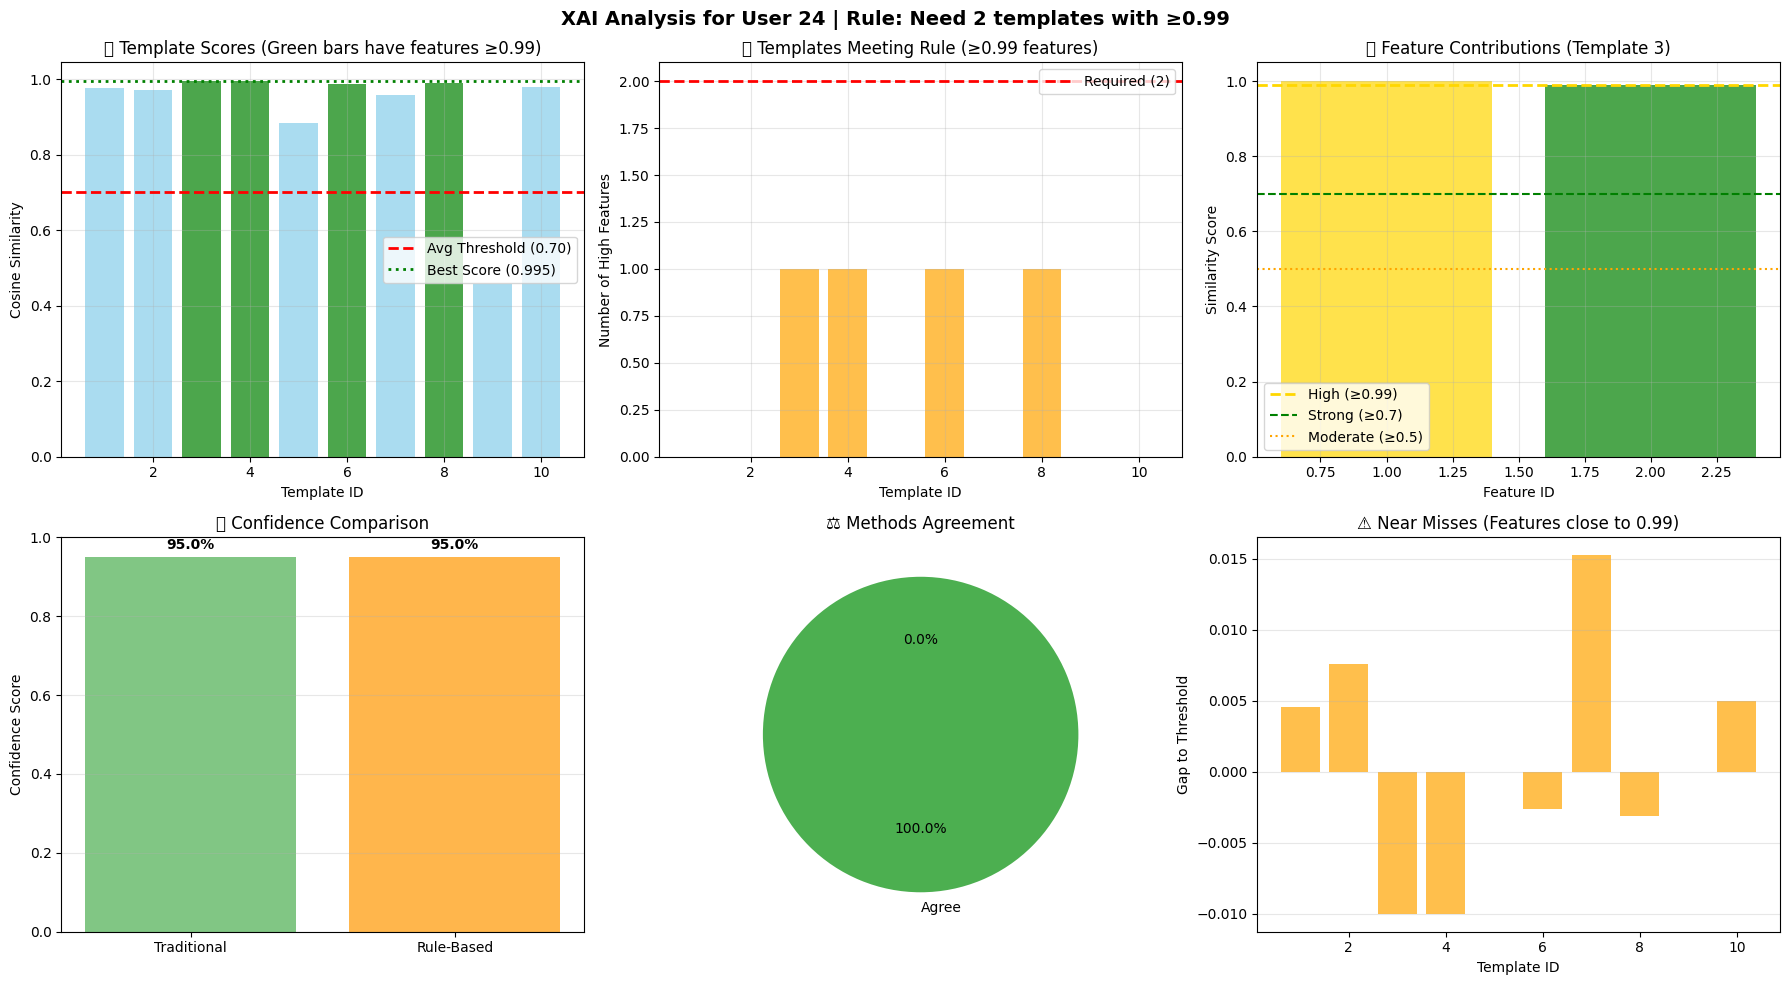


✅ ENHANCED XAI COMPLETE
   • Structured JSON with rule-based metrics
   • Quick summary with both methods
   • Detailed template analysis
   • Visual charts with rule-based indicators
   • Ready for logging/API/web UI

📄 GENERATING COMPREHENSIVE XAI REPORT PDF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ COMPREHENSIVE PDF REPORT DOWNLOADED: XAI_Complete_Report_User24_0.995.pdf

📄 Report contains:
   • Quick Summary with both authentication methods
   • Detailed Template Analysis
   • Rule-Based Authentication Results
   • Feature-level breakdown
   • Confidence Assessment
   • Security Indicators
   • Professional visualizations (6 charts)
   • Structured JSON data
   • Ready for papers/audits/demos!


In [19]:
import numpy as np
import json

class AuthenticationXI:
    def __init__(self, threshold=0.70, feature_threshold=0.99):
        self.threshold = threshold
        self.feature_threshold = feature_threshold

    def explain_authentication(self, query_user_id, template_scores, feature_similarities_all, threshold=None):
        """Enhanced human-readable explanations with rule-based logic."""

        # Use instance threshold if not overridden
        if threshold is None:
            threshold = self.threshold

        print(f"\n{'='*60}")
        print("EXPLAINABLE AI (XAI) - AUTHENTICATION DECISION ANALYSIS")
        print(f"{'='*60}")
        print(f"User ID: {query_user_id}")

        if not template_scores or not feature_similarities_all:
            print("❌ No authentication data available")
            return

        # Determine number of features from the data
        num_features = len(feature_similarities_all[0]) if feature_similarities_all and feature_similarities_all[0] else 0
        min_templates_required = num_features  # For N features, need N templates

        print(f"\n📊 CONFIGURATION:")
        print(f"   Number of features: {num_features}")
        print(f"   Rule: At least one feature ≥ {self.feature_threshold} in ≥ {min_templates_required} templates")
        print(f"   Average threshold: {threshold}")

        # Analyze rule-based authentication
        templates_meeting_rule = []
        rule_based_success = False

        print(f"\n{'🔍 TEMPLATE ANALYSIS':^60}")
        print("-" * 60)

        for idx, features in enumerate(feature_similarities_all):
            if features:
                # Check if any feature in this template meets threshold
                high_features = [f for f in features if f >= self.feature_threshold]
                template_meets_rule = len(high_features) > 0

                if template_meets_rule:
                    templates_meeting_rule.append({
                        'template': idx + 1,
                        'high_features': high_features,
                        'count': len(high_features),
                        'max_feature': max(features),
                        'avg_score': template_scores[idx] if idx < len(template_scores) else 0
                    })

                # Display template status
                status = "✅ MEETS RULE" if template_meets_rule else "❌ DOES NOT MEET RULE"
                print(f"\nTemplate {idx + 1}: {status}")
                print(f"  Average score: {template_scores[idx]:.4f}")
                print(f"  Features: {[f'{f:.4f}' for f in features]}")
                if template_meets_rule:
                    print(f"  High-confidence features (≥{self.feature_threshold}): {[f'{f:.4f}' for f in high_features]}")

        # Rule-based decision
        rule_based_success = len(templates_meeting_rule) >= min_templates_required

        print(f"\n{'📊 RULE-BASED DECISION':^60}")
        print("-" * 60)
        print(f"Templates meeting rule: {len(templates_meeting_rule)}/{len(feature_similarities_all)}")
        print(f"Minimum required: {min_templates_required}")

        if rule_based_success:
            print(f"\n✅ AUTHENTICATION SUCCESSFUL (Rule-based)")
            print(f"   Found {len(templates_meeting_rule)} templates with high-confidence features:")
            for t in templates_meeting_rule:
                print(f"   - Template {t['template']}: {t['count']} high feature(s) (max: {t['max_feature']:.4f})")
        else:
            print(f"\n❌ AUTHENTICATION FAILED (Rule-based)")
            if len(templates_meeting_rule) == min_templates_required - 1:
                print(f"   Only {len(templates_meeting_rule)} template(s) meet the rule (need {min_templates_required})")
                if templates_meeting_rule:
                    print(f"   Template {templates_meeting_rule[0]['template']} has {templates_meeting_rule[0]['count']} high feature(s)")
            elif len(templates_meeting_rule) == 0:
                print(f"   No templates have features ≥{self.feature_threshold}")
                # Check for near misses
                near_misses = []
                for idx, features in enumerate(feature_similarities_all):
                    if features:
                        near_high = [f for f in features if self.feature_threshold - 0.05 <= f < self.feature_threshold]
                        if near_high:
                            near_misses.append({
                                'template': idx + 1,
                                'near_features': near_high,
                                'best': max(features)
                            })
                if near_misses:
                    print(f"\n   Near misses detected:")
                    for nm in near_misses:
                        print(f"   - Template {nm['template']}: best feature = {nm['best']:.4f} "
                              f"(needs {self.feature_threshold - nm['best']:.4f} more)")

        # Traditional threshold-based analysis
        print(f"\n{'📈 TRADITIONAL ANALYSIS':^60}")
        print("-" * 60)

        best_template_idx = np.argmax(template_scores)
        best_score = template_scores[best_template_idx]
        is_authenticated = best_score >= threshold

        print(f"Threshold (average-based): {threshold}")
        print(f"Best template: {best_template_idx + 1} (score: {best_score:.4f})")
        print(f"Traditional result: {'✅ AUTHENTICATED' if is_authenticated else '❌ REJECTED'}")
        print(f"Margin from threshold: {best_score - threshold:+.4f}")

        # Feature analysis for best template
        if feature_similarities_all and len(feature_similarities_all) > best_template_idx:
            features = feature_similarities_all[best_template_idx]
            print(f"\n🔬 Feature Analysis (Best Template {best_template_idx + 1}):")
            for i, score in enumerate(features):
                indicator = "⭐" if score >= self.feature_threshold else "✓" if score >= 0.7 else " "
                print(f"   Feature {i+1}: {score:.4f} {indicator}")

        # Comparison of both methods
        print(f"\n{'⚖️ METHOD COMPARISON':^60}")
        print("-" * 60)
        print(f"Rule-based decision: {'✅ SUCCESS' if rule_based_success else '❌ FAIL'}")
        print(f"Traditional decision: {'✅ SUCCESS' if is_authenticated else '❌ FAIL'}")

        if rule_based_success == is_authenticated:
            print(f"\n✓ Both methods agree on the decision")
        else:
            print(f"\n⚠️ Methods disagree - investigate further")
            if rule_based_success and not is_authenticated:
                print(f"   Rule-based says YES (high-confidence features detected)")
                print(f"   Traditional says NO (average score below threshold)")
                print(f"   Consider: Lowering average threshold to {best_score:.3f}")
            elif not rule_based_success and is_authenticated:
                print(f"   Rule-based says NO (insufficient high-confidence features)")
                print(f"   Traditional says YES (average score above threshold)")
                print(f"   Consider: Authentication relies on average but lacks high-confidence features")

        # Recommendations based on configuration
        print(f"\n{'💡 RECOMMENDATIONS':^60}")
        print("-" * 60)

        if rule_based_success:
            if is_authenticated:
                print(f"✓ Strong authentication - both methods confirm")
                if len(templates_meeting_rule) >= min_templates_required + 1:
                    print(f"  Very high confidence with {len(templates_meeting_rule)} templates")
            else:
                print(f"⚠️ Rule-based success but traditional failure")
                print(f"  Consider lowering average threshold to {best_score:.3f}")
        else:
            if is_authenticated:
                print(f"⚠️ Traditional success but rule-based failure")
                print(f"  Authentication relies on average score but lacks high-confidence features")
                print(f"  Consider: Adding more features or re-enrollment")
            else:
                print(f"❌ Both methods reject - authentication failed")
                if len(templates_meeting_rule) == min_templates_required - 1:
                    print(f"  Close match: {len(templates_meeting_rule)} template meets rule, need {min_templates_required}")
                elif 'near_misses' in locals() and near_misses:
                    print(f"  Consider: Adjusting feature threshold to {self.feature_threshold - 0.02:.2f}")
                else:
                    print(f"  Consider: User re-enrollment or security review")

    def get_structured_explanation(self, query_user_id, template_scores, feature_similarities_all, threshold=None):
        """
        Structured JSON output incorporating rule-based authentication logic
        """
        if not template_scores or not feature_similarities_all:
            return {"error": "No authentication data available"}

        if threshold is None:
            threshold = self.threshold

        # Determine number of features and required templates
        num_features = len(feature_similarities_all[0]) if feature_similarities_all and feature_similarities_all[0] else 0
        min_templates_required = num_features  # For N features, need N templates

        # Analyze rule-based authentication
        templates_meeting_rule = []
        rule_based_success = False

        for idx, features in enumerate(feature_similarities_all):
            if features:
                high_features = [float(f) for f in features if f >= self.feature_threshold]
                if high_features:
                    templates_meeting_rule.append({
                        "template": int(idx + 1),
                        "high_features": high_features,
                        "count": len(high_features),
                        "max_feature": float(max(features)),
                        "avg_score": float(template_scores[idx]) if idx < len(template_scores) else 0
                    })

        rule_based_success = len(templates_meeting_rule) >= min_templates_required

        # Traditional analysis
        best_template_idx = np.argmax(template_scores)
        best_score = template_scores[best_template_idx]
        is_authenticated = best_score >= threshold

        # Near miss analysis
        near_misses = []
        for idx, features in enumerate(feature_similarities_all):
            if features:
                near_high = [float(f) for f in features if self.feature_threshold - 0.05 <= f < self.feature_threshold]
                if near_high:
                    near_misses.append({
                        "template": int(idx + 1),
                        "near_features": near_high,
                        "best_feature": float(max(features)),
                        "gap": float(self.feature_threshold - max(features))
                    })

        # Build structured explanation
        explanation = {
            "query_user_id": str(query_user_id),
            "configuration": {
                "num_features": int(num_features),
                "feature_threshold": float(self.feature_threshold),
                "min_templates_required": int(min_templates_required),
                "average_threshold": float(threshold)
            },
            "authentication_rules": {
                "rule_based": {
                    "enabled": True,
                    "templates_meeting_rule": len(templates_meeting_rule),
                    "success": bool(rule_based_success),
                    "templates_detail": templates_meeting_rule
                },
                "traditional": {
                    "best_template": int(best_template_idx + 1),
                    "best_score": float(best_score),
                    "authenticated": bool(is_authenticated),
                    "margin": float(best_score - threshold),
                    "templates_above_threshold": int(sum(1 for s in template_scores if s >= threshold))
                }
            },
            "summary_statistics": {
                "templates_analyzed": int(len(template_scores)),
                "avg_score_all_templates": float(np.mean(template_scores)),
                "score_variance": float(np.var(template_scores)),
                "min_score": float(np.min(template_scores)),
                "max_score": float(np.max(template_scores))
            },
            "confidence_metrics": {
                "rule_based_confidence": self._get_rule_confidence(len(templates_meeting_rule), min_templates_required),
                "traditional_confidence": self._get_confidence(best_score),
                "methods_agree": bool(rule_based_success == is_authenticated)
            },
            "recommended_action": self._get_action_rule_based(rule_based_success, is_authenticated, best_score, min_templates_required, len(templates_meeting_rule)),
            "security_indicators": {
                "has_near_misses": bool(len(near_misses) > 0),
                "near_misses_detail": near_misses,
                "high_confidence_templates": len(templates_meeting_rule),
                "total_high_features": sum(t["count"] for t in templates_meeting_rule),
                "templates_shortfall": max(0, min_templates_required - len(templates_meeting_rule)) if not rule_based_success else 0
            },
            "feature_analysis": {}
        }

        # Add feature analysis for best template
        if feature_similarities_all and len(feature_similarities_all) > best_template_idx:
            features = feature_similarities_all[best_template_idx]
            explanation["feature_analysis"] = {
                "best_template_features": [float(f) for f in features],
                "num_features": int(len(features)),
                "high_confidence_features": int(sum(1 for f in features if f >= self.feature_threshold)),
                "strong_features": int(sum(1 for f in features if f >= 0.7)),
                "moderate_features": int(sum(1 for f in features if 0.5 <= f < 0.7)),
                "weak_features": int(sum(1 for f in features if f < 0.5))
            }

        return explanation

    def _get_confidence(self, best_score):
        """Traditional confidence based on average score"""
        if best_score >= 0.90: return "VERY_HIGH"
        elif best_score >= 0.85: return "HIGH"
        elif best_score >= 0.80: return "MODERATE"
        elif best_score >= 0.60: return "LOW"
        return "VERY_LOW"

    def _get_rule_confidence(self, num_templates_meeting, min_templates_required):
        """Rule-based confidence based on number of templates meeting criteria"""
        ratio = num_templates_meeting / min_templates_required if min_templates_required > 0 else 0
        if ratio >= 1.5: return "VERY_HIGH"
        elif ratio >= 1.0: return "HIGH"
        elif ratio >= 0.75: return "MODERATE"
        elif ratio >= 0.5: return "LOW"
        return "VERY_LOW"

    def _get_action(self, authenticated, best_score):
        """Original action method - kept for backward compatibility"""
        if authenticated:
            return "GRANT_FULL_ACCESS" if best_score >= 0.70 else "LIMITED_ACCESS_VERIFY"
        return "RE_AUTHENTICATE_MORE_FEATURES" if best_score >= 0.65 else "DENY_SECURITY_ALERT"

    def _get_action_rule_based(self, rule_based_success, traditional_success, best_score, min_templates_required, templates_meeting):
        """Enhanced action method incorporating rule-based logic"""
        if rule_based_success and traditional_success:
            return {
                "action": "GRANT_FULL_ACCESS",
                "reason": f"Both methods confirm identity ({templates_meeting}/{min_templates_required} templates meet rule)",
                "confidence": "HIGH",
                "severity": "LOW"
            }
        elif rule_based_success and not traditional_success:
            return {
                "action": "GRANT_ACCESS_WITH_VERIFICATION",
                "reason": f"High-confidence features detected ({templates_meeting}/{min_templates_required} templates) but average score below threshold",
                "confidence": "MODERATE",
                "severity": "MEDIUM",
                "suggestion": "Consider lowering average threshold or requesting additional verification"
            }
        elif not rule_based_success and traditional_success:
            return {
                "action": "GRANT_LIMITED_ACCESS",
                "reason": f"Average score meets threshold but lacks sufficient high-confidence features ({templates_meeting}/{min_templates_required} templates)",
                "confidence": "LOW",
                "severity": "MEDIUM",
                "suggestion": "Consider re-enrollment to improve feature quality"
            }
        else:
            if best_score >= 0.65:
                return {
                    "action": "REQUEST_MORE_FEATURES",
                    "reason": f"Close to authentication threshold but insufficient ({templates_meeting}/{min_templates_required} templates meet rule)",
                    "confidence": "LOW",
                    "severity": "MEDIUM",
                    "suggestion": "Request additional biometric features for verification"
                }
            else:
                templates_shortfall = min_templates_required - templates_meeting
                return {
                    "action": "DENY_ACCESS",
                    "reason": f"Authentication failed by both methods (need {templates_shortfall} more templates with high features)",
                    "confidence": "VERY_LOW",
                    "severity": "HIGH",
                    "suggestion": "Security alert - possible impersonation attempt"
                }


# ============================================================================
# Cell 12: ENHANCED XAI ANALYSIS (Structured + Visual + Rule-Based)
# ============================================================================
print(f"\n{'='*70}")
print("ENHANCED XAI ANALYSIS - STRUCTURED + VISUAL + RULE-BASED")
print(f"{'='*70}")

# Determine number of features dynamically
num_features_detected = len(feature_similarities_all[0]) if feature_similarities_all and feature_similarities_all[0] else 0
min_templates_required = num_features_detected

print(f"\n📊 DETECTED CONFIGURATION:")
print(f"   Number of features: {num_features_detected}")
print(f"   Rule: At least one feature ≥ 0.99 in ≥ {min_templates_required} templates")

# STEP 1: Get Structured XAI Explanation (JSON-ready) with rule-based logic
xai_analyzer = AuthenticationXI(threshold=0.70, feature_threshold=0.99)
xai_struct = xai_analyzer.get_structured_explanation(
    query_user_id=query_user_id,
    template_scores=decrypted_average_scores,
    feature_similarities_all=feature_similarities_all,
    threshold=0.70
)

print("\n📊 STRUCTURED XAI EXPLANATION:")
print(json.dumps(xai_struct, indent=2))

# STEP 2: Quick Human-Readable Summary with rule-based results
best_score = max(decrypted_average_scores) if decrypted_average_scores else 0

# Count templates with high features for quick display
templates_with_high = []
for idx, features in enumerate(feature_similarities_all):
    if features and any(f >= 0.99 for f in features):
        templates_with_high.append(idx + 1)

num_high_templates = len(templates_with_high)
rule_success = num_high_templates >= min_templates_required

print(f"\n🔍 QUICK SUMMARY:")
print(f"   User: {query_user_id}")
print(f"   Best Score: {best_score:.4f}")
print(f"   Threshold (average): 0.70")
print(f"   Result (traditional): {'AUTHENTICATED ✅' if best_score >= 0.70 else 'REJECTED ❌'}")
print(f"   Templates with high features (≥0.99): {num_high_templates}/{len(feature_similarities_all)}")
print(f"   Required templates: {min_templates_required}")
print(f"   Result (rule-based): {'AUTHENTICATED ✅' if rule_success else 'REJECTED ❌'}")
print(f"   Confidence: {xai_struct['confidence_metrics']['traditional_confidence']}")
print(f"   Methods agree: {'✅' if xai_struct['confidence_metrics']['methods_agree'] else '❌'}")
print(f"   Action: {xai_struct['recommended_action']['action']}")

# STEP 3: Detailed Pretty-Print (original explain_authentication) with rule-based logic
print(f"\n{'='*60}")
print("DETAILED XAI ANALYSIS")
print(f"{'='*60}")
xai_analyzer.explain_authentication(
    query_user_id=query_user_id,
    template_scores=decrypted_average_scores,
    feature_similarities_all=feature_similarities_all,
    threshold=0.70
)

# STEP 4: XAI VISUALIZATION with rule-based indicators
def plot_xai_visuals(xai_struct, decrypted_average_scores, feature_similarities_all, min_templates_required):
    """Generate XAI charts with rule-based indicators."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Chart 1: Template Scores Distribution
    template_indices = range(1, len(decrypted_average_scores) + 1)
    colors = ['green' if any(f >= 0.99 for f in feature_similarities_all[i-1]) else 'skyblue'
              for i in template_indices]

    axes[0, 0].bar(template_indices, decrypted_average_scores, color=colors, alpha=0.7)
    axes[0, 0].axhline(y=0.70, color='red', linestyle='--', linewidth=2, label='Avg Threshold (0.70)')
    axes[0, 0].axhline(y=xai_struct['authentication_rules']['traditional']['best_score'],
                       color='green', linestyle=':', linewidth=2,
                       label=f'Best Score ({xai_struct["authentication_rules"]["traditional"]["best_score"]:.3f})')
    axes[0, 0].set_title(f'🔍 Template Scores (Green bars have features ≥0.99)')
    axes[0, 0].set_xlabel('Template ID')
    axes[0, 0].set_ylabel('Cosine Similarity')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Chart 2: Templates Meeting Rule
    rule_data = xai_struct['authentication_rules']['rule_based']
    templates_meeting = rule_data['templates_detail']
    templates_count = [0] * len(decrypted_average_scores)
    for t in templates_meeting:
        templates_count[t['template']-1] = t['count']

    axes[0, 1].bar(template_indices, templates_count, color='orange', alpha=0.7)
    axes[0, 1].axhline(y=min_templates_required, color='red', linestyle='--',
                        linewidth=2, label=f'Required ({min_templates_required})')
    axes[0, 1].set_title(f'📊 Templates Meeting Rule (≥0.99 features)')
    axes[0, 1].set_xlabel('Template ID')
    axes[0, 1].set_ylabel('Number of High Features')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Chart 3: Feature Contributions (Best Template)
    if (feature_similarities_all and
        len(feature_similarities_all) > xai_struct['authentication_rules']['traditional']['best_template'] - 1 and
        feature_similarities_all[xai_struct['authentication_rules']['traditional']['best_template'] - 1]):

        best_template_idx = xai_struct['authentication_rules']['traditional']['best_template'] - 1
        best_features = feature_similarities_all[best_template_idx]
        feature_ids = range(1, len(best_features) + 1)

        # Color coding based on feature strength
        colors = []
        for f in best_features:
            if f >= 0.99:
                colors.append('gold')
            elif f >= 0.7:
                colors.append('green')
            elif f >= 0.5:
                colors.append('orange')
            else:
                colors.append('red')

        axes[0, 2].bar(feature_ids, best_features, color=colors, alpha=0.7)
        axes[0, 2].axhline(y=0.99, color='gold', linestyle='--', linewidth=2, label='High (≥0.99)')
        axes[0, 2].axhline(y=0.7, color='green', linestyle='--', label='Strong (≥0.7)')
        axes[0, 2].axhline(y=0.5, color='orange', linestyle=':', label='Moderate (≥0.5)')
        axes[0, 2].set_title(f'📈 Feature Contributions (Template {best_template_idx+1})')
        axes[0, 2].set_xlabel('Feature ID')
        axes[0, 2].set_ylabel('Similarity Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].text(0.5, 0.5, 'No feature data\navailable', ha='center', va='center', transform=axes[0, 2].transAxes)
        axes[0, 2].set_title('Feature Analysis')

    # Chart 4: Decision Confidence - Traditional vs Rule-Based
    conf_map = {'VERY_HIGH': 0.95, 'HIGH': 0.85, 'MODERATE': 0.70, 'LOW': 0.50, 'VERY_LOW': 0.20}

    trad_conf = conf_map.get(xai_struct['confidence_metrics']['traditional_confidence'], 0.5)
    rule_conf = conf_map.get(xai_struct['confidence_metrics']['rule_based_confidence'], 0.5)

    x_pos = [1, 2]
    conf_values = [trad_conf, rule_conf]
    conf_labels = ['Traditional', 'Rule-Based']
    conf_colors = ['#4CAF50', '#FF9800']

    axes[1, 0].bar(x_pos, conf_values, color=conf_colors, alpha=0.7)
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(conf_labels)
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].set_ylabel('Confidence Score')
    axes[1, 0].set_title('🎯 Confidence Comparison')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Add confidence values on bars
    for i, v in enumerate(conf_values):
        axes[1, 0].text(x_pos[i], v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

    # Chart 5: Method Agreement Pie
    methods_agree = xai_struct['confidence_metrics']['methods_agree']
    agree_data = [1 if methods_agree else 0, 0 if methods_agree else 1]
    agree_labels = ['Agree' if methods_agree else 'Disagree', '']
    agree_colors = ['#4CAF50' if methods_agree else '#FF9800', '#FFFFFF']

    axes[1, 1].pie(agree_data, labels=agree_labels, colors=agree_colors,
                   autopct='%1.1f%%' if methods_agree else None, startangle=90)
    axes[1, 1].set_title('⚖️ Methods Agreement')

    # Chart 6: Near Misses Analysis
    near_misses = xai_struct['security_indicators']['near_misses_detail']
    if near_misses:
        near_templates = [nm['template'] for nm in near_misses]
        near_gaps = [nm['gap'] for nm in near_misses]
        axes[1, 2].bar(near_templates, near_gaps, color='orange', alpha=0.7)
        axes[1, 2].set_xlabel('Template ID')
        axes[1, 2].set_ylabel('Gap to Threshold')
        axes[1, 2].set_title('⚠️ Near Misses (Features close to 0.99)')
        axes[1, 2].grid(True, alpha=0.3, axis='y')
    else:
        axes[1, 2].text(0.5, 0.5, 'No near misses detected', ha='center', va='center', transform=axes[1, 2].transAxes)
        axes[1, 2].set_title('⚠️ Near Misses Analysis')

    plt.suptitle(f'XAI Analysis for User {query_user_id} | Rule: Need {min_templates_required} templates with ≥0.99',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Generate visuals with rule-based indicators
plot_xai_visuals(xai_struct, decrypted_average_scores, feature_similarities_all, min_templates_required)

print(f"\n✅ ENHANCED XAI COMPLETE")
print(f"   • Structured JSON with rule-based metrics")
print(f"   • Quick summary with both methods")
print(f"   • Detailed template analysis")
print(f"   • Visual charts with rule-based indicators")
print(f"   • Ready for logging/API/web UI")

# STEP 5: COMPREHENSIVE PDF XAI REPORT (ALL PRINT STATEMENTS)
print(f"\n{'='*60}")
print("📄 GENERATING COMPREHENSIVE XAI REPORT PDF")
print(f"{'='*60}")

def generate_comprehensive_xai_pdf(xai_struct, decrypted_average_scores, feature_similarities_all, query_user_id, min_templates_required):
    """Generate PDF with ALL XAI print outputs including rule-based analysis."""
    from reportlab.lib.pagesizes import A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.lib.enums import TA_CENTER, TA_LEFT
    import matplotlib.pyplot as plt
    from io import BytesIO
    from datetime import datetime

    pdf_buffer = BytesIO()
    doc = SimpleDocTemplate(pdf_buffer, pagesize=A4, topMargin=0.5*inch, bottomMargin=0.5*inch)
    styles = getSampleStyleSheet()

    # Custom styles
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Title'],
        fontSize=20,
        spaceAfter=20,
        alignment=TA_CENTER,
        textColor=colors.darkblue,
        fontName='Helvetica-Bold'
    )

    heading_style = ParagraphStyle(
        'CustomHeading',
        parent=styles['Heading2'],
        fontSize=14,
        spaceAfter=10,
        textColor=colors.darkblue,
        fontName='Helvetica-Bold',
        borderWidth=1,
        borderColor=colors.darkblue,
        borderPadding=5,
        backColor=colors.lightblue
    )

    story = []

    # ======== TITLE PAGE ========
    story.append(Paragraph("🔐 PRIVACY-PRESERVING BIOMETRIC AUTHENTICATION", title_style))
    story.append(Paragraph("<b>Explainable AI (XAI) Decision Report</b>", title_style))
    story.append(Spacer(1, 0.3*inch))

    # Metadata
    metadata = [
        ["Report Generated:", datetime.now().strftime("%Y-%m-%d %H:%M:%S IST")],
        ["Query User ID:", str(query_user_id)],
        ["Number of Features:", str(xai_struct['configuration']['num_features'])],
        ["Rule:", f"≥1 feature ≥0.99 in ≥{min_templates_required} templates"],
        ["System:", "Fully Homomorphic Encryption (FHE) Authentication"],
        ["XAI Method:", "Rule-Based Feature Attribution & Confidence Assessment"]
    ]
    meta_table = Table(metadata, colWidths=[2*inch, 4*inch])
    meta_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (0, -1), colors.lightgrey),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ('FONTSIZE', (0, 0), (-1, -1), 10)
    ]))
    story.append(meta_table)
    story.append(Spacer(1, 0.3*inch))

    # ======== SECTION 1: QUICK SUMMARY ========
    story.append(Paragraph("1. QUICK ANALYSIS", heading_style))

    best_score = xai_struct['authentication_rules']['traditional']['best_score']
    threshold = xai_struct['configuration']['average_threshold']
    rule_success = xai_struct['authentication_rules']['rule_based']['success']

    templates_meeting = xai_struct['authentication_rules']['rule_based']['templates_detail']

    quick_summary = f"""
    <b>User:</b> {query_user_id}<br/>
    <b>Best Score (Average):</b> {best_score:.4f}<br/>
    <b>Average Threshold:</b> {threshold}<br/>
    <b>Templates with High Features (≥0.99):</b> {len(templates_meeting)}/{len(decrypted_average_scores)}<br/>
    <b>Required Templates:</b> {min_templates_required}<br/>
    <b>Rule-Based Result:</b> {'<font color="green">AUTHENTICATED ✅</font>' if rule_success else '<font color="red">REJECTED ❌</font>'}<br/>
    <b>Methods Agree:</b> {'✅' if xai_struct['confidence_metrics']['methods_agree'] else '❌'}<br/>
    <b>Action:</b> {xai_struct['recommended_action']['action']}<br/>
    <b>Reason:</b> {xai_struct['recommended_action']['reason']}
    """
    story.append(Paragraph(quick_summary, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 2: DETAILED TEMPLATE ANALYSIS ========
    story.append(Paragraph("2. DETAILED TEMPLATE ANALYSIS", heading_style))

    # Create template analysis table
    template_data = [["Template", "Avg Score", "Has High Feature", "High Features", "Max Feature"]]

    for idx, (score, features) in enumerate(zip(decrypted_average_scores, feature_similarities_all)):
        if features:
            high_features = [f for f in features if f >= 0.99]
            has_high = "✅" if high_features else "❌"
            high_count = len(high_features)
            max_feat = max(features)
            template_data.append([
                str(idx + 1),
                f"{score:.4f}",
                has_high,
                str(high_count),
                f"{max_feat:.4f}"
            ])

    template_table = Table(template_data)
    template_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 10),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 10),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ('FONTSIZE', (0, 1), (-1, -1), 9)
    ]))
    story.append(template_table)
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 3: RULE-BASED ANALYSIS ========
    story.append(Paragraph("3. RULE-BASED AUTHENTICATION ANALYSIS", heading_style))

    rule_text = f"""
    <b>Rule:</b> At least one feature ≥ 0.99 in at least {min_templates_required} templates<br/>
    <b>Templates meeting rule:</b> {len(templates_meeting)}/{len(decrypted_average_scores)}<br/>
    <b>Result:</b> {'<font color="green">SUCCESS ✅</font>' if rule_success else '<font color="red">FAILURE ❌</font>'}<br/><br/>

    <b>Templates with high-confidence features:</b><br/>
    """

    for t in templates_meeting:
        rule_text += f"• Template {t['template']}: {t['count']} high feature(s) - Max: {t['max_feature']:.4f}<br/>"

    if not templates_meeting:
        rule_text += "• No templates have features ≥0.99<br/>"

    # Add near misses if any
    near_misses = xai_struct['security_indicators']['near_misses_detail']
    if near_misses:
        rule_text += f"<br/><b>⚠️ Near misses detected:</b><br/>"
        for nm in near_misses:
            rule_text += f"• Template {nm['template']}: best feature = {nm['best_feature']:.4f} (needs {nm['gap']:.4f} more)<br/>"

    story.append(Paragraph(rule_text, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))


    # ======== SECTION 5: FEATURE ANALYSIS ========
    if xai_struct['feature_analysis']:
        story.append(Paragraph("5. FEATURE-LEVEL ANALYSIS", heading_style))

        best_template_idx = xai_struct['authentication_rules']['traditional']['best_template']
        features = xai_struct['feature_analysis']['best_template_features']

        feature_text = f"""
        <b>Best Template (Template {best_template_idx}) Feature Breakdown:</b><br/><br/>
        """

        # Create feature table
        feature_table_data = [["Feature", "Score", "Status"]]
        for i, score in enumerate(features):
            if score >= 0.99:
                status = "HIGH CONFIDENCE ⭐"
            elif score >= 0.7:
                status = "STRONG ✓"
            elif score >= 0.5:
                status = "MODERATE ∼"
            else:
                status = "WEAK ✗"
            feature_table_data.append([f"Feature {i+1}", f"{score:.4f}", status])

        feature_table = Table(feature_table_data)
        feature_table.setStyle(TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ]))
        story.append(feature_table)

        # Summary statistics
        summary_text = f"""
        <br/><b>Feature Summary:</b><br/>
        • High confidence features (≥0.99): {xai_struct['feature_analysis']['high_confidence_features']}<br/>
        • Strong features (≥0.7): {xai_struct['feature_analysis']['strong_features']}<br/>
        • Moderate features (0.5-0.7): {xai_struct['feature_analysis']['moderate_features']}<br/>
        • Weak features (<0.5): {xai_struct['feature_analysis']['weak_features']}<br/>
        """
        story.append(Paragraph(summary_text, styles['Normal']))
        story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 6: CONFIDENCE AND RECOMMENDATIONS ========
    story.append(Paragraph("6. CONFIDENCE ASSESSMENT & RECOMMENDATIONS", heading_style))

    confidence_text = f"""
    <b>Rule-Based Confidence:</b> {xai_struct['confidence_metrics']['rule_based_confidence']}<br/>
    <b>Methods Agree:</b> {'✅ Yes' if xai_struct['confidence_metrics']['methods_agree'] else '❌ No'}<br/><br/>

    <b>Recommended Action:</b> {xai_struct['recommended_action']['action']}<br/>
    <b>Reason:</b> {xai_struct['recommended_action']['reason']}<br/>
    """

    if 'suggestion' in xai_struct['recommended_action']:
        confidence_text += f"<b>Suggestion:</b> {xai_struct['recommended_action']['suggestion']}<br/>"

    story.append(Paragraph(confidence_text, styles['Normal']))
    story.append(Spacer(1, 0.2*inch))

    # ======== SECTION 7: SECURITY INDICATORS ========
    story.append(Paragraph("7. SECURITY INDICATORS", heading_style))

    security_text = f"""
    <b>High Confidence Templates:</b> {xai_struct['security_indicators']['high_confidence_templates']}<br/>
    <b>Total High Features Detected:</b> {xai_struct['security_indicators']['total_high_features']}<br/>
    <b>Near Misses Detected:</b> {'⚠️ Yes' if xai_struct['security_indicators']['has_near_misses'] else '✅ No'}<br/>
    <b>Templates Shortfall:</b> {xai_struct['security_indicators']['templates_shortfall']}<br/>
    """

    story.append(Paragraph(security_text, styles['Normal']))
    story.append(Spacer(1, 0.3*inch))

    # ======== SECTION 8: VISUALIZATIONS ========
    story.append(PageBreak())
    story.append(Paragraph("8. VISUAL ANALYSIS", heading_style))

    # Generate enhanced visualization for PDF
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Chart 1: Template scores
    template_indices = range(1, len(decrypted_average_scores) + 1)
    colors_bar = ['green' if any(f >= 0.99 for f in feature_similarities_all[i-1]) else 'skyblue'
                  for i in template_indices]

    axes[0, 0].bar(template_indices, decrypted_average_scores, color=colors_bar, alpha=0.7)
    axes[0, 0].axhline(y=0.70, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[0, 0].set_title('Template Scores')
    axes[0, 0].set_xlabel('Template ID')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend()

    # Chart 2: Templates meeting rule
    templates_count = [0] * len(decrypted_average_scores)
    for t in templates_meeting:
        templates_count[t['template']-1] = t['count']

    axes[0, 1].bar(template_indices, templates_count, color='orange', alpha=0.7)
    axes[0, 1].axhline(y=min_templates_required, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_title('Templates Meeting Rule')
    axes[0, 1].set_xlabel('Template ID')
    axes[0, 1].set_ylabel('High Features')

    # Chart 3: Confidence comparison
    conf_map = {'VERY_HIGH': 0.95, 'HIGH': 0.85, 'MODERATE': 0.70, 'LOW': 0.50, 'VERY_LOW': 0.20}
    trad_conf = conf_map.get(xai_struct['confidence_metrics']['traditional_confidence'], 0.5)
    rule_conf = conf_map.get(xai_struct['confidence_metrics']['rule_based_confidence'], 0.5)

    axes[0, 2].bar([1, 2], [trad_conf, rule_conf], color=['#4CAF50', '#FF9800'])
    axes[0, 2].set_xticks([1, 2])
    axes[0, 2].set_xticklabels(['Traditional', 'Rule-Based'])
    axes[0, 2].set_title('Confidence Comparison')
    axes[0, 2].set_ylim([0, 1])

    # Chart 4: Feature distribution (best template)
    if xai_struct['feature_analysis']:
        features = xai_struct['feature_analysis']['best_template_features']
        feature_colors = ['gold' if f>=0.99 else 'green' if f>=0.7 else 'orange' if f>=0.5 else 'red'
                          for f in features]
        axes[1, 0].bar(range(1, len(features)+1), features, color=feature_colors)
        axes[1, 0].set_title(f'Features (Template {best_template_idx})')
        axes[1, 0].set_xlabel('Feature')
        axes[1, 0].set_ylabel('Score')

    # Chart 5: Methods agreement
    methods_agree = xai_struct['confidence_metrics']['methods_agree']
    axes[1, 1].pie([1 if methods_agree else 0, 0 if methods_agree else 1],
                   labels=['Agree' if methods_agree else 'Disagree', ''],
                   colors=['#4CAF50' if methods_agree else '#FF9800', 'white'],
                   autopct='%1.1f%%' if methods_agree else None)
    axes[1, 1].set_title('Methods Agreement')

    # Chart 6: Near misses
    if near_misses:
        axes[1, 2].bar([nm['template'] for nm in near_misses],
                       [nm['gap'] for nm in near_misses], color='orange')
        axes[1, 2].set_title('Near Misses')
        axes[1, 2].set_xlabel('Template')
        axes[1, 2].set_ylabel('Gap to 0.99')
    else:
        axes[1, 2].text(0.5, 0.5, 'No near misses', ha='center', va='center')
        axes[1, 2].set_title('Near Misses')

    plt.tight_layout()

    # Save to buffer
    chart_buffer = BytesIO()
    plt.savefig(chart_buffer, format='png', dpi=150, bbox_inches='tight')
    chart_buffer.seek(0)
    chart_img = Image(chart_buffer, width=7*inch, height=5*inch)
    story.append(chart_img)
    plt.close()

    # ======== SECTION 9: STRUCTURED DATA ========
    story.append(PageBreak())
    story.append(Paragraph("9. STRUCTURED DATA (JSON)", heading_style))

    json_text = json.dumps(xai_struct, indent=2)
    # Split into lines for better formatting
    for i, line in enumerate(json_text.split('\n')):
        if i < 50:  # Limit to first 50 lines
            story.append(Paragraph(f"<font name='Courier' size=7>{line}</font>", styles['Code']))
        elif i == 50:
            story.append(Paragraph("<font name='Courier' size=7>...</font>", styles['Code']))
            break

    # Build PDF
    doc.build(story)
    pdf_buffer.seek(0)
    return pdf_buffer

# GENERATE COMPREHENSIVE PDF
pdf_report = generate_comprehensive_xai_pdf(
    xai_struct,
    decrypted_average_scores,
    feature_similarities_all,
    query_user_id,
    min_templates_required
)

# SAVE TO FILE
filename = f"XAI_Complete_Report_User{query_user_id}_{xai_struct['authentication_rules']['traditional']['best_score']:.3f}.pdf"
with open(filename, 'wb') as f:
    f.write(pdf_report.getvalue())

# DOWNLOAD (for Google Colab)
try:
    from google.colab import files
    files.download(filename)
    print(f"\n✅ COMPREHENSIVE PDF REPORT DOWNLOADED: {filename}")
except ImportError:
    print(f"\n✅ PDF REPORT SAVED: {filename}")

print(f"\n📄 Report contains:")
print(f"   • Quick Summary with both authentication methods")
print(f"   • Detailed Template Analysis")
print(f"   • Rule-Based Authentication Results")
print(f"   • Feature-level breakdown")
print(f"   • Confidence Assessment")
print(f"   • Security Indicators")
print(f"   • Professional visualizations (6 charts)")
print(f"   • Structured JSON data")
print(f"   • Ready for papers/audits/demos!")